**Auteur** : Viktoriya Zeruk<br>
**Date dernière version** : 12/04/2022<br>

# <center><font color=#7DF9FF>PROJET 3: <br>Anticipez les besoins en consommation électrique de bâtiments</font> </center>

# <center><font color=#15f4ee> Modeling</font></center>


---
# <font color=#00d4ff>1. Environnement</font>

## <font color= #00ADEF>1.1 - Environnement </font>

In [1]:
## df_analysis
import io
import gc
import timeit
import math
from math import prod

## General
import pandas as pd
import numpy as np
from numpy import asarray
from numpy.random import seed, randint
import matplotlib.pyplot as plt
import seaborn as sns

## Scikit Learn library
from sklearn.model_selection import train_test_split, ShuffleSplit, permutation_test_score
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate, KFold, GridSearchCV, validation_curve, learning_curve, cross_val_predict, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

%matplotlib inline

sns.set_theme(style="darkgrid")

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")


## <font color= #00ADEF>1.2 - Functions</font>

In [2]:
def df_analysis(df, name_df, *args, **kwargs):
    """
    Method used to analyze on the DataFrame.

    Parameters:
    -----------------
        df : pandas.DataFrame
        Dataset to analyze.
        
        name_df : str
        Dataset name.
        
        *args, **kwargs:
        -----------------
            columns : list
            Dataframe keys in list format.
            
            flag : str
            Flag to show complete information about the dataset to analyse
            "complete" shows all information about the dataset.

    Returns:
    -----------------
        None. 
        Print the analysis on the Dataset. 
        
    """
    
    # Getting the variables
    columns = kwargs.get("columns", None)
    type_analysis = kwargs.get("type_analysis", None)
    
    ORDERING_COMPLETE = [
        "name", "type", "records", "unique", "# NaN", "% NaN", "mean", "min", "25%", "50%", "75%", "max", "std"
    ]
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
    
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["name", "type"])
        df_resume["records"] = list(df.count())
        df_resume["# NaN"] = list(df.isnull().sum())
        df_resume["% NaN"] = list(((df.isnull().sum() / len(df.index))*100).round(2))
        
        print("\nAnalysis of", name_df, "dataset")
        print("--------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        print("- Unique indexes:                ", df.index.is_unique)
        
        if columns is not None:
            print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
                print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
        
        if type_analysis == "summarized":
            print("\n")
        
        if type_analysis is None or type_analysis != "summarized":
            pd.set_option("display.max_rows", None) # show full of showing rows
            pd.set_option("display.max_columns", None) # show full of showing cols
            pd.set_option("display.max_colwidth", None) # show full width of showing cols
            pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell    
            
            if type_analysis is None or type_analysis != "complete":
                print("\n- Type object and records by columns      (",memory_usage,")")
                print("--------------------------------------------------------------------")
            elif type_analysis == "complete":
                df_resume["unique"] = list(df.nunique())
                df_desc = pd.DataFrame(df.describe().T).reset_index()
                df_desc = df_desc.rename(columns={"index": "name"})
                df_resume = df_resume.merge(right=df_desc[["name", "mean", "min", "25%", "50%", "75%", "max", "std"]], on="name", how="left")
                df_resume = df_resume[ORDERING_COMPLETE]
                print("\n- Type object and records by columns      (",memory_usage,")")
                print("--------------------------------------------------------------------")
                
            display(df_resume.sort_values("records", ascending=False))
            
            pd.reset_option("display.max_rows") # reset max of showing rows
            pd.reset_option("display.max_columns") # reset max of showing cols
            pd.reset_option("display.max_colwidth") # reset width of showing cols
            pd.reset_option("display.float_format") # reset show full content in cell
            
        # deleting dataframe to free memory
        if type_analysis == "complete":
            del [[df_resume, df_desc]]
            gc.collect()
            df_resume, df_desc = (pd.DataFrame() for i in range(2))
        else:
            del df_resume
            gc.collect()
            df_resume = pd.DataFrame()

    
def plot_validation_curve_by(estimator, name_model, validation_by, X_train, y_train, param_name, param_range, param_name_short, scoring=None, cv=None):
    """
    Generate 1 plots: 
        1. The test and training validation curve
    
    Parameters
    -----------------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.
        
    name_model : str
        Name of the model as title for the chart. 
        
    validation_by : str 
        Name of the metric to plot the curve. Possible values ["R2SCORE", "MAE"]
        
    X_train : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y_train : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.      
        
    param_name : str
        Name of the parameter that will be varied.
    
    param_range : array-like of shape (n_values,)
        The values of the parameter that will be evaluated.
    
    param_name_short : str
        Short name for param_name
        
    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.
        
    Returns:
    -----------------
        None. 
        Plot the graph. 
        
    """    
    # Initializing figure
    fig = plt.figure(figsize=(8, 6))
    
    if validation_by == "R2SCORE":
        
        # Get the validation_curves results
        train_scores, test_scores = validation_curve(estimator, X_train, y_train, param_name=param_name, param_range=param_range, cv=kfold)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plot = sns.lineplot(x=param_range, y=train_scores_mean, label="Train", marker="o")
        plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="blue")

        plot = sns.lineplot(x=param_range, y=test_scores_mean, label="Validation", marker="o")
        plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="orange")

        plt.legend(bbox_to_anchor=(1.22, 1), borderaxespad=0)
        
        plt.title(name_model + " Validation curve", fontdict={ "fontsize": 16, "fontweight": "normal" })
        plot.set(xlabel=param_name_short, ylabel="R2-score".translate(SUP))
        
    elif validation_by == "MAE":
    
        # Get the validation_curves results
        train_scores, test_scores = validation_curve(estimator, X_train, y_train, param_name=param_name, param_range=param_range, scoring=scoring, cv=kfold)
        
        train_errors, test_errors = -train_scores, -test_scores
        
        plot = plt.errorbar(param_range, train_errors.mean(axis=1), yerr=train_errors.std(axis=1), label="Train")
        plot = plt.errorbar(param_range, test_errors.mean(axis=1), yerr=test_errors.std(axis=1), label="Validation")

        plt.legend(bbox_to_anchor=(1.235, 1), borderaxespad=0)
        
        plt.ylabel("MAE\n(smaller is better)")
        plt.xlabel(param_name_short)
        _ = plt.title(name_model + " Validation curve", fontdict={ "fontsize": 16, "fontweight": "normal" })
     
    plt.tight_layout()
    plt.savefig("img/" + name_model + "-validation-curve-by-" + validation_by + ".png")
    sns.despine(fig)
    plt.show()
    
            
def plot_learning_curve(estimator, name_model, X_train, y_train, cv=None, train_sizes=np.linspace(0.2, 1.0, 10)):
    """
    Generate 3 plots: 
        1. The test and training learning curve
        2. The training samples vs fit times curve
        3. The fit times vs score curve
    
    Parameters
    -----------------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.
        
    name_model : str
        Name of the model as title for the chart.        
        
    X_train : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y_train : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.        
        
    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5) or (0.2, 1.0, 10))
        
    Returns:
    -----------------
        None. 
        Plot the graphs. 
        
    """
    
    # Get the learning_curves results
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X_train, y_train, cv=cv, \
                                                                           train_sizes=train_sizes, n_jobs=-1, return_times=True)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    # Initializing figure
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
    
    # Plot learning curve
    plot = sns.lineplot(x=train_sizes, y=train_scores_mean, label="Train", marker="o", ax=ax1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="blue")

    plot = sns.lineplot(x=train_sizes, y=test_scores_mean, label="Validation", marker="o", ax=ax1)
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="orange")
    
    ax1.legend(loc="best")
    ax1.set_title(" Learning curve (" + name_model + ")", fontdict={ "fontsize": 16, "fontweight": "normal" })
    plot.set(xlabel="Training examples", ylabel="R2-score".translate(SUP))
    
    # Plot Scalability of the model
    plot = sns.lineplot(x=train_sizes, y=fit_times_mean, marker="o", ax=ax2)
    ax2.fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1, color="blue")
    
    ax2.set_title("Scalability of the model", fontdict={ "fontsize": 16, "fontweight": "normal" })
    plot.set(xlabel="Training examples", ylabel="Fit times")

    # Performance of the model
    plot = sns.lineplot(x=fit_times_mean, y=test_scores_mean, marker="o", ax=ax3)
    ax3.fill_between(fit_times_mean, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    
    ax3.set_title("Performance of the model", fontdict={ "fontsize": 16, "fontweight": "normal" })
    plot.set(xlabel="Fit times examples", ylabel="R2-score".translate(SUP))
    
    plt.savefig("img/" + name_model + "-performance-model.png")
    sns.despine(fig)
    plt.show()


def plot_cross_val_predi(estimator, name_model, target_variable, X_train, y_train, cv=None):
    """
    Generate 1 plots: 
        1. The validation between real values vs predicted values
    
    Parameters
    -----------------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.
        
    name_model : str
        Name of the model as title for the chart.   

    target_variable : str
        Name of the target variable.    
        
    X_train : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y_train : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.      
        
    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.
        
    Returns:
    -----------------
        None. 
        Plot the graph. 
        
    """   
    
    # Get the predicted values
    predicted = cross_val_predict(estimator, X_train, y_train, cv=kfold)
    
    # Initializing figure
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
    
    # Main title
    plt.suptitle("Real values vs Predicted values", size=24)
    
    ax1.scatter(predicted, y_train, edgecolors=(0, 0, 0))
    ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "--k", lw=4)
    
    ax1.text(min(y_train)+0.2, 0.98*max(y_train), r'$R^2$ = %.2f, RMSE = %.2f' % (
            round(r2_score(y_train, predicted), 3),
            round(math.sqrt(mean_squared_error(y_train, predicted)), 3)), 
            style="italic", fontsize=13,
            bbox={"facecolor": "grey", "alpha": 0.4, "pad": 5})
    ax1.set_title(name_model + " Cross-Values Predictions", fontdict={ "fontsize": 16, "fontweight": "normal" })
    ax1.set_xlabel("Predicted values")
    ax1.set_ylabel("Real values")

    
    ax2.scatter(predicted, (y_train - predicted), edgecolors=(0, 0, 0))
    ax2.hlines(y=0, xmin=predicted.min(), xmax=predicted.max(), colors="red", linestyles="--", lw=4)
    ax2.set_title(name_model + " Residuals", fontdict={ "fontsize": 16, "fontweight": "normal" })
    ax2.set_xlabel("Predicted values")
    ax2.set_ylabel("Standardized residuals")
    
    
    sns.kdeplot(y_train, color="r", label="Real values", ax=ax3)
    sns.kdeplot(predicted, color="b", label="Predicted values", ax=ax3)
    
    ax3.set_title(name_model + " Distribution plot based on density", fontdict={ "fontsize": 16, "fontweight": "normal" })
    ax3.set_xlabel("SiteEnergyUse(kBtu)")
    ax3.set_ylabel("Density")
    plt.legend(bbox_to_anchor=(0.99, 0.99), borderaxespad=0)
    
    plt.savefig("img/" + name_model + "-cross-val-predict.png")
    plt.show()
    

def plot_features_importance(estimator, name_model, X_train, y_train, scoring=None):
    """
    Generate 1 plots: 
        1. The importance by feature
    
    Parameters
    -----------------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.
        
    name_model : str
        Name of the model as title for the chart.     
        
    X_train : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y_train : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning. 
        
    scoring : string, callable or None, default=None
        Scorer to use. It can be a single string or a callable. 
        If None, the estimator’s default scorer is used. 
        
    Returns:
    -----------------
        None. 
        Plot the graph. 
        
    """     
    # Get the importance by feature
    results = permutation_importance(estimator, X_train, y_train, scoring=scoring)
    
    # Making a dataframe to work easily
    df_importance = pd.DataFrame({
                        "Feature" : X_train.columns,
                        "Importance" : results.importances_mean
                    })
    
    # Sorting by importance before plotting
    df_importance = df_importance.sort_values("Importance")
    
    # Initializing figure    
    fig = plt.subplots(figsize=(10, 8))
    
    plot = sns.barplot(data=df_importance, y=df_importance["Feature"], x=df_importance["Importance"])
    
    plt.title(name_model + " Features Importance", fontdict={ "fontsize": 16, "fontweight": "normal" })
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.savefig("img/" + name_model + "-feature-importance.png")
    plt.show()


---
# <font color=#00d4ff>2. Imports</font>


## <font color= #00ADEF>2.1. Importing and preparing files</font>

<div class="alert alert-block alert-info">
    <p>It is necessary to remember that the following dataset doesn't have any transformation/preprocessing of data.</p>
    <p>So, we have to do the following:</p>
    <ul style="list-style-type: square;">
        <li>Transform features and target to Normal distribution</li>
        <li>Treat missing values</li>
        <li>Standarization of data</li>
    </ul>  
</div>

In [3]:
data = pd.read_csv(r"df_to_work2.csv")

In [4]:
data.head()

,NumberofFloors,NumberofBuildings,BUILDING_AGE,PropertyGFATotal,PropertyGFATotal-binned,Neighborhood,PropertyType,RATIO_ELECTRICITY,NaturalGas,SteamUse,OtherFuelUse,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e),ENERGYSTARScore
0,12.0,1.0,95.0,88434.0,Medium,DOWNTOWN,Hotel,52.79951,True,True,False,6981428.0,249.43,65.0
1,11.0,1.0,26.0,103566.0,Medium,DOWNTOWN,Hotel,46.74768,True,False,False,8354235.0,263.51,51.0
2,10.0,1.0,96.0,61320.0,Medium,DOWNTOWN,Hotel,9.80903,True,True,False,28229320.0,1936.34,1.0
3,18.0,1.0,42.0,175580.0,Medium,DOWNTOWN,Hotel,40.90771,True,False,False,14829099.0,507.70,67.0
4,11.0,1.0,96.0,83008.0,Medium,DOWNTOWN,Hotel,42.85568,True,False,False,6252842.0,208.46,25.0


In [5]:
df_analysis(data, "data", type_analysis="complete")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  1613 rows and 14 columns
- Total of NaN values:            524
- Percentage of NaN:              2.32 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 143.5+ KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,NumberofFloors,float64,1613,28,0,0.00000,3.42033,1.00000,1.00000,2.00000,4.00000,33.00000,3.73643
1,NumberofBuildings,float64,1613,5,0,0.00000,1.01612,1.00000,1.00000,1.00000,1.00000,11.00000,0.30052
2,BUILDING_AGE,float64,1613,113,0,0.00000,60.45753,7.00000,33.00000,57.00000,92.00000,122.00000,32.76327
3,PropertyGFATotal,float64,1613,1527,0,0.00000,90695.87973,3.00000,28800.00000,47368.00000,97720.00000,1158691.00000,115427.84464
4,PropertyGFATotal-binned,object,1613,3,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Neighborhood,object,1613,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,PropertyType,object,1613,8,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,RATIO_ELECTRICITY,float64,1613,1252,0,0.00000,70.70959,0.00033,50.47997,72.50703,100.00002,100.00874,26.02542
8,NaturalGas,bool,1613,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,SteamUse,bool,1613,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN



---
# <font color=#00d4ff>3. Splitting data - SiteEnergyUse(kBtu)</font>




## <font color= #00ADEF>3.1 - Splitting dataset based on the features and targets</font>

<div class="alert alert-block alert-info">
    Splitting dataset based on the features and targets
</div>

In [6]:
X = data.drop(columns=["SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)", "ENERGYSTARScore"])

In [7]:
X.head()

,NumberofFloors,NumberofBuildings,BUILDING_AGE,PropertyGFATotal,PropertyGFATotal-binned,Neighborhood,PropertyType,RATIO_ELECTRICITY,NaturalGas,SteamUse,OtherFuelUse
0,12.0,1.0,95.0,88434.0,Medium,DOWNTOWN,Hotel,52.79951,True,True,False
1,11.0,1.0,26.0,103566.0,Medium,DOWNTOWN,Hotel,46.74768,True,False,False
2,10.0,1.0,96.0,61320.0,Medium,DOWNTOWN,Hotel,9.80903,True,True,False
3,18.0,1.0,42.0,175580.0,Medium,DOWNTOWN,Hotel,40.90771,True,False,False
4,11.0,1.0,96.0,83008.0,Medium,DOWNTOWN,Hotel,42.85568,True,False,False


<div class="alert alert-block alert-info">
    Based on the Exploratory Data Analysis realized, we are going to transform to log2 the target variable
</div>

In [8]:
y_energy = np.log2(data.loc[:,"SiteEnergyUse(kBtu)"])
y_energy.head()

0    22.735091
1    22.994076
2    24.750691
3    23.821928
4    22.576081
Name: SiteEnergyUse(kBtu), dtype: float64

In [9]:
y_energy_values = y_energy.values
y_energy_values[:5]

array([22.73509073, 22.9940763 , 24.75069104, 23.82192761, 22.57608063])


## <font color= #00ADEF>3.2 - Train/Test split</font>

<div class="alert alert-block alert-info">
    At this point, we are going to predict <b>SiteEnergyUse(kBtu)</b>
</div>

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_energy, test_size=0.33, random_state=42)

In [11]:
print("X_train: {}".format(X_train.shape))
print("y_train: {}".format(y_train.shape))
print("---------------------")
print("X_test: {}".format(X_test.shape))
print("y_test: {}".format(y_test.shape))

X_train: (1080, 11)
y_train: (1080,)
---------------------
X_test: (533, 11)
y_test: (533,)



---
# <font color=#00d4ff>4. Data preprocessing</font>

<div class="alert alert-block alert-info">
     We are going to process the features as follows<br><br>
    <p><b>Boolean features</b><br>
    Transforming them into int</p>
    <p><b>Categorical features</b><br>
    Transforming all features through LabelEncoder</p>
    <p><b>Ordinal features</b><br>
    Transforming the feature through OrdinalEncoder</p>
    <p><b>Features to Log</b><br>
    Based on the Exploratory Data Analysis, we detected the features that can be transformed into log2 to achieve a better normal distribution </p>
    <p><b>Numerical features</b><br>
    Normalizing the features through StandardScaler due to all of them do not have a normal distribution</p>
</div>

In [12]:
def boolean_transformation(X):
    # Transforming the boolean features into int
    return X.astype(int)

def log_transformation(X):
    # transforming some features into log2
    return np.log2(X + 1)

In [13]:
BOOLEAN_FEATURES = ["NaturalGas", "SteamUse", "OtherFuelUse"] # Features to be transformed into int
CATEGORICAL_FEATURES = ["Neighborhood", "PropertyType"] # Features to be transformed with OneHotEncoder()
ORDINAL_FEATURES = ["PropertyGFATotal-binned"]
FEATURES_TO_LOG = ["PropertyGFATotal"] # Features to be transformed into log2
NUMERICAL_FEATURES = ["NumberofFloors", "NumberofBuildings", "BUILDING_AGE", "PropertyGFATotal", "RATIO_ELECTRICITY"] # Features to be treated considering numerical values

In [14]:
boolean_pipeline = make_pipeline(FunctionTransformer(boolean_transformation))

categorical_pipeline = make_pipeline(OneHotEncoder(sparse=False, drop="first"))

ordinal_pipeline = make_pipeline(OrdinalEncoder(categories=[["Small", "Medium", "Large"]]))

log_transformation_pipeline = make_pipeline(KNNImputer(), FunctionTransformer(log_transformation))

numerical_pipeline = make_pipeline(KNNImputer(), StandardScaler())

In [15]:
preprocessor = make_column_transformer(
                (boolean_pipeline, BOOLEAN_FEATURES), 
                (categorical_pipeline, CATEGORICAL_FEATURES),
                (ordinal_pipeline, ORDINAL_FEATURES),
                (log_transformation_pipeline, FEATURES_TO_LOG), 
                (numerical_pipeline, NUMERICAL_FEATURES)
)


---
# <font color=#00d4ff>5. Modelisation</font>


## <font color= #00ADEF>5.1 - Supervised models</font>

<div class="alert alert-block alert-info">
    List of models to use. for now, in default mode
</div>

In [16]:
regressors = {
    "Linear" : LinearRegression(),
    "KNeighbors" : KNeighborsRegressor(n_neighbors=2),
    "Lasso" : Lasso(),
    "SVR" : SVR(),
    "Random Forest" : RandomForestRegressor(),
    "Gradient Boosting" : GradientBoostingRegressor()
}

<div class="alert alert-block alert-info">
    Models metrics
</div>

In [17]:
# Dataframe with y_test_transformed to compared againts predictions
df_y_pred = pd.DataFrame({
        "Model" : "Original",
        "y_pred" : y_test
})

# List of metrics results for each models 
LIST_MODEL, LIST_R2SCORE, LIST_MAE, LIST_RMSE, LIST_DURATION  = ([] for i in range(5))

for k, v in regressors.items():
    
    start_time_model = timeit.default_timer()
    
    # Data preprocessing based on the pipelines and the regressors setup
    reg = make_pipeline(preprocessor, v)
    
    # Fit the model using the training data and training target
    reg.fit(X_train, y_train)
    
    # Making the prediction using the testing data
    y_pred = reg.predict(X_test)
    
    end_time_model =  round(timeit.default_timer() - start_time_model, 3)
    
    # Concatenating predictions to compare against y_test_transformed
    df_temp = pd.DataFrame({
        "Model" : k,
        "y_pred" : y_pred
    })
    
    # Concatenating predictions to compare against y_test_transformed
    df_y_pred = pd.concat([df_y_pred, df_temp])
    
    # Calculating R2 Coefficient of determination for each model (Best possible score is 1.0, lower values are worse.)
    R2SCORE = round(1 - r2_score(y_test, y_pred), 3)
    
    # Calculating the Mean absolute error (The best value is 0.0)
    MAE = round(mean_absolute_error(y_test, y_pred), 3)
    
    # Calculating Root Mean Square Error for each model (The best value is 0.0)
    RMSE = round(mean_squared_error(y_test, y_pred, squared=False), 3)
    
    # Adding results into LIST
    LIST_MODEL.append(k)
    LIST_R2SCORE.append(R2SCORE)
    LIST_MAE.append(MAE)
    LIST_RMSE.append(RMSE)
    LIST_DURATION.append(end_time_model)

<div class="alert alert-block alert-info">
    Comparison of energy predictions against original data
</div>

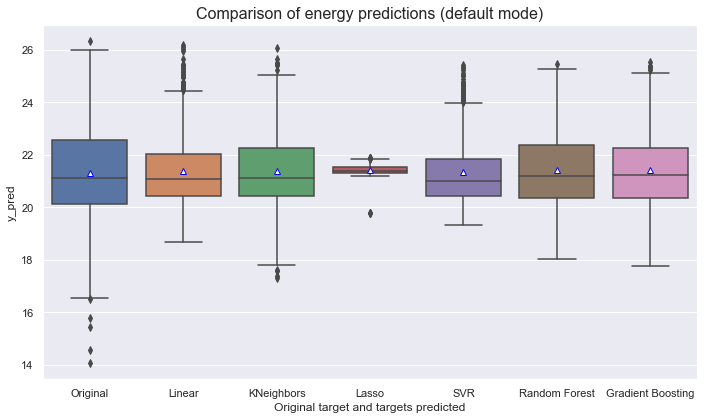

In [18]:
plt.figure(figsize=[10,6])
sns.boxplot(x=df_y_pred["Model"], y=df_y_pred["y_pred"], showmeans=True, 
            meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
plt.title("Comparison of energy predictions (default mode)", size=16)
plt.xlabel("Original target and targets predicted", size=12)
plt.tight_layout()
plt.savefig("img/Comparison-of-imputations.png")
plt.show()

   <p><b>Observations / Conclusions</b></p>    
    <p>At this point, we can see that <b>Kneighbors</b>, <b>Random Forest</b> and <b>Gradient Boosting</b> are the most <b>similar to Original data</b></p>



## <font color= #00ADEF>5.2. Predictions metrics</font>

<div class="alert alert-block alert-info">
    Creating dataframe based on metrics results for each models
</div>

In [19]:
df_models_metrics = pd.DataFrame({
    "Model" : LIST_MODEL,
    "1 - " + "R2".translate(SUP) : LIST_R2SCORE, 
    "MAE" : LIST_MAE,    
    "RMSE" : LIST_RMSE,
    "Duration" : LIST_DURATION,
})

df_models_metrics

,Model,1 - R²,MAE,RMSE,Duration
0,Linear,0.466,0.921,1.255,0.052
1,KNeighbors,0.535,0.963,1.345,0.050
2,Lasso,0.919,1.364,1.762,0.034
3,SVR,0.424,0.837,1.197,0.209
4,Random Forest,0.373,0.798,1.122,0.713
5,Gradient Boosting,0.347,0.790,1.083,0.239


<p><b>Observations / Conclusions</b></p>    
    <b>Best results</b> with default mode considering each model
         <li><b>1-R2:</b> Gradient Boosting(0.347) </li>
        <li><b>MAE:</b> Gradient Boosting(0.791) </li>
        <li><b>RMSE:</b> Gradient Boosting(1.083) </li>
        <li><b>Duration:</b> Lasso(0.0352) </li>

<p><b>Observations / Conclusions</b></p>    
    <b>Best results</b> with default mode considering each model
         <li><b>1-R2:</b> Gradient Boosting(0.323) </li>
        <li><b>MAE:</b> Gradient Boosting(0.787) </li>
        <li><b>RMSE:</b> Gradient Boosting(1.044) </li>
        <li><b>Duration:</b> Lasso(0.076) </li>


In [20]:
df_models_metrics_melt = pd.melt(df_models_metrics, id_vars="Model", var_name="Metric", value_name="Value")
df_models_metrics_melt.head(3)

,Model,Metric,Value
0,Linear,1 - R²,0.466
1,KNeighbors,1 - R²,0.535
2,Lasso,1 - R²,0.919


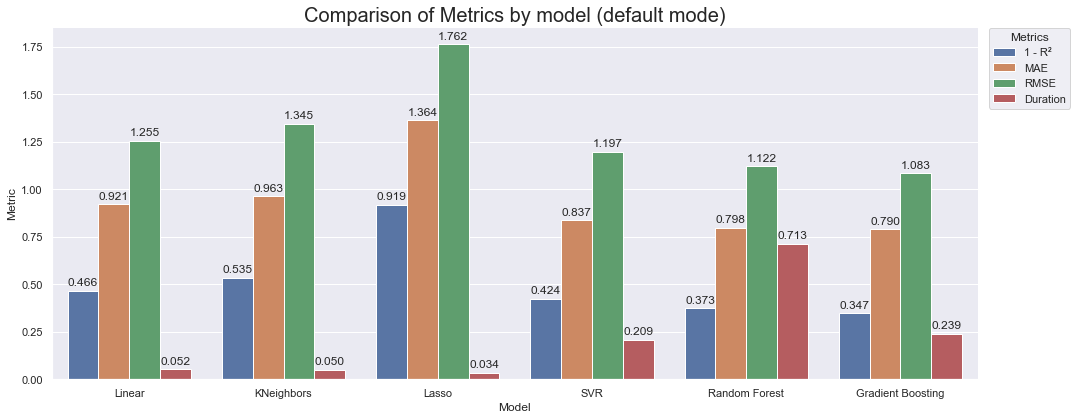

In [21]:
fig, ax1 = plt.subplots(figsize=(15, 6))
plot = sns.barplot(x="Model", y="Value", hue="Metric", data=df_models_metrics_melt, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.title("Comparison of Metrics by model (default mode)", size=20)
plt.legend(bbox_to_anchor=(1.10, 1), borderaxespad=0, title="Metrics")
plt.tight_layout()
plt.xlabel("Model", size=12)
plt.ylabel("Metric", size=12)
plt.savefig("img/comparisonMetricsByModel.png")
sns.despine(fig)

   <p><b>Observations / Conclusions</b></p>    
    So far, <b>Gradient Boosting</b> is giving the best result with <b>default parameters</b>




## <font color= #00ADEF>5.3. Cross Validation K-Fold</font>

In [22]:
# List of metrics results for each models 
LIST_MODEL, LIST_R2SCORE, LIST_MAE, LIST_RMSE, LIST_DURATION, LIST_SCORES  = ([] for i in range(6))

for k, v in regressors.items():

    # Data preprocessing based on the pipelines and the regressors setup
    reg = make_pipeline(preprocessor, v)
    
    kfold = KFold(n_splits=5, shuffle=False, random_state=None)
    
    # Get the score for each validation score method to get accuracy of model
    scores = cross_validate(reg, X_train, y_train, cv=kfold, scoring=("r2", "neg_mean_absolute_error", "neg_mean_squared_error"), return_train_score=True)
    
    # Adding results into LIST
    LIST_MODEL.append(k)
    LIST_R2SCORE.append(round((1 - scores.get("test_r2").mean()), 3))
    LIST_MAE.append(round(abs(scores.get("test_neg_mean_absolute_error").mean()), 3))
    LIST_RMSE.append(round(math.sqrt((abs(scores.get("test_neg_mean_squared_error").mean()))), 3))
    LIST_DURATION.append(round(scores.get("fit_time").mean(), 3))
    LIST_SCORES.append(scores.get("test_r2"))

<div class="alert alert-block alert-info">
    Plotting the cross validation executions
</div>

In [23]:
df_cross_val = pd.DataFrame(LIST_SCORES, columns=[1, 2, 3, 4, 5])
df_cross_val["Model"] = LIST_MODEL
df_cross_val_melt = df_cross_val.melt(id_vars="Model", var_name="Execution", value_name="Score")

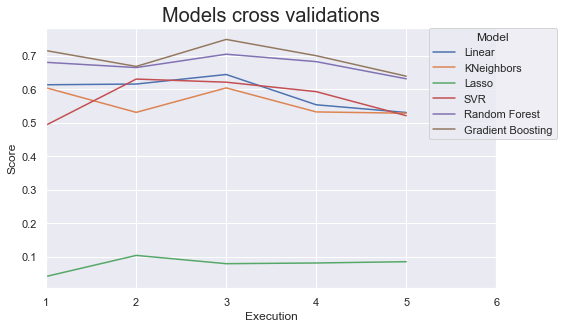

In [24]:
plt.figure(figsize=(8, 6))
plot = sns.lineplot(x="Execution",
                    y="Score",
                    hue="Model",
                    data=df_cross_val_melt
)
plt.legend(bbox_to_anchor=(0.85, 1), borderaxespad=0, title="Model")
plt.tight_layout()
plt.title("Models cross validations", size=20)
plot.set(xlabel="Execution", ylabel="Score", xlim=(1, 6))

plt.savefig("img/models-cross-validations-Scores.png")
sns.despine(fig)

  <p><b>Observations / Conclusions</b></p>
    At this point, we can see
        <li><b>Gradient Boosting</b> is the best result </li>
        <li><b>Lasso</b> is the worst result </li>




### <font color= #00ADEF>5.3.1 Predictions metrics</font>

<div class="alert alert-block alert-info">
    Creating dataframe based on metrics results for each models
</div>

In [25]:
df_models_metrics_cross = pd.DataFrame({
    "Model" : LIST_MODEL,
    "1 - "+"R2".translate(SUP) : LIST_R2SCORE, 
    "MAE" : LIST_MAE,    
    "RMSE" : LIST_RMSE,
    "Duration" : LIST_DURATION,
})

df_models_metrics_cross

,Model,1 - R²,MAE,RMSE,Duration
0,Linear,0.408,0.888,1.145,0.021
1,KNeighbors,0.440,0.904,1.189,0.020
2,Lasso,0.922,1.353,1.727,0.019
3,SVR,0.428,0.861,1.177,0.071
4,Random Forest,0.327,0.783,1.027,0.673
5,Gradient Boosting,0.306,0.776,0.991,0.262


   <b>Results</b> with Cross-Validation considering each model
          <li><b>1-R2:</b> Gradient Boosting(0.305) </li>
        <li><b>MAE:</b> Gradient Boosting(0.785) </li>
        <li><b>RMSE:</b> Gradient Boosting(0.99) </li>
        <li><b>Duration:</b> Linear(0.206) </li>
    </ul> 
</div>

   <b>Best results</b> with Cross-Validation considering each model
        <li><b>1-R2:</b> Gradient Boosting(0.330) </li>
        <li><b>MAE:</b> Gradient Boosting(0.794) </li>
        <li><b>RMSE:</b> Gradient Boosting(1.037) </li>
        <li><b>Duration:</b> Linear(0.040) </li>


In [26]:
df_models_metrics_melt_cross = pd.melt(df_models_metrics_cross, id_vars="Model", var_name="Metric", value_name="Value")
df_models_metrics_melt_cross.head()

,Model,Metric,Value
0,Linear,1 - R²,0.408
1,KNeighbors,1 - R²,0.440
2,Lasso,1 - R²,0.922
3,SVR,1 - R²,0.428
4,Random Forest,1 - R²,0.327


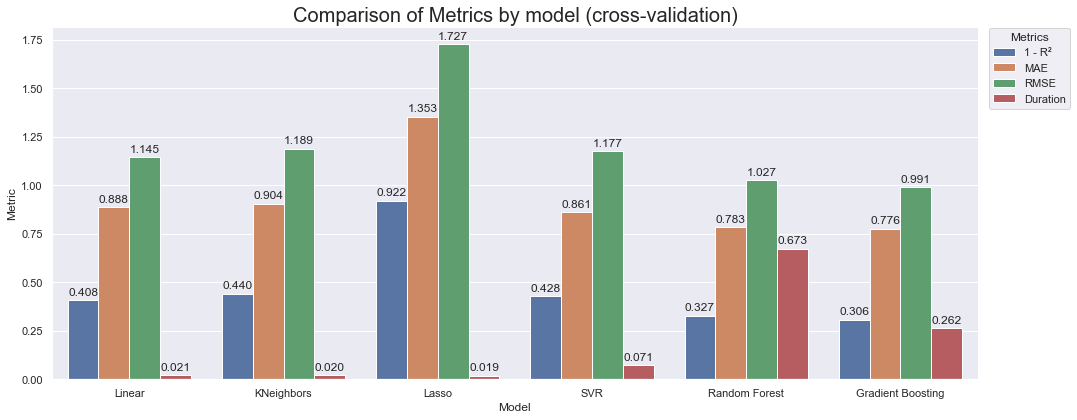

In [27]:
fig, ax1 = plt.subplots(figsize=(15, 6))
plot = sns.barplot(x="Model", y="Value", hue="Metric", data=df_models_metrics_melt_cross, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.title("Comparison of Metrics by model (cross-validation)", size=20)
plt.legend(bbox_to_anchor=(1.10, 1), borderaxespad=0, title="Metrics")
plt.tight_layout()
plt.xlabel("Model", size=12)
plt.ylabel("Metric", size=12)
plt.savefig("img/comparisonMetrics_crossByModel.png")
sns.despine(fig)

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>Some results improved their values</li>
        <li>Despite the decrease of his result, <b>Gradient Boosting</b> is still giving the best result with <b>default parameters</b> and <b>cross-validation</b></li>
    </ul>
</div>


---
# <font color=#00d4ff>6. Optimization</font>

   We are going to optimize each model separately, to see the results more in detail<br>    
    Also, we are going to add all predictions and metrics base on parameters optimization to compare the results


In [28]:
# Dataframe for metrics to compare
df_models_metrics_gsc = pd.DataFrame({})

# Dataframe with final results for each models withs theirs best parameters
df_models_hyperparameters = pd.DataFrame({})

# Dataframe with y_test_transformed to compared againts predictions
df_y_pred_hyperparameters = pd.DataFrame({
        "Model" : "Original",
        "y_pred" : y_test
})

# List of metrics results for each models 
LIST_MODEL_GSC, LIST_R2SCORE_GSC, LIST_MAE_GSC, LIST_RMSE_GSC, LIST_DURATION_GSC, LIST_SCORES_GSC  = ([] for i in range(6))

<div class="alert alert-block alert-info">
    At the same time, we are going to get the following metrics
</div>

In [29]:
SCORINGS = {
    "R2" : "r2",
    "MSE" : "neg_mean_squared_error", 
    "MAE" : "neg_mean_absolute_error"
}



## <font color= #00ADEF>6.1. Linear Regression optimization</font>

   <p>It is necessary to take in account that we are treating with <b>Non-linear Dataset</b> based on EDA done</p>
        <p>Initializing model</p>


### <font color= #00ADEF>6.1.1 - Linear Regression </font>

In [30]:
lr = LinearRegression()

<div class="alert alert-block alert-info">
    Data preprocessing based on the pipelines and the regressors setup
</div>

In [31]:
reg = make_pipeline(preprocessor, lr)

<div class="alert alert-block alert-info">
    Identifying the names of each parameter
</div>

In [32]:
sorted(reg.get_params().keys())

['columntransformer',
 'columntransformer__n_jobs',
 'columntransformer__pipeline-1',
 'columntransformer__pipeline-1__functiontransformer',
 'columntransformer__pipeline-1__functiontransformer__accept_sparse',
 'columntransformer__pipeline-1__functiontransformer__check_inverse',
 'columntransformer__pipeline-1__functiontransformer__func',
 'columntransformer__pipeline-1__functiontransformer__inv_kw_args',
 'columntransformer__pipeline-1__functiontransformer__inverse_func',
 'columntransformer__pipeline-1__functiontransformer__kw_args',
 'columntransformer__pipeline-1__functiontransformer__validate',
 'columntransformer__pipeline-1__memory',
 'columntransformer__pipeline-1__steps',
 'columntransformer__pipeline-1__verbose',
 'columntransformer__pipeline-2',
 'columntransformer__pipeline-2__memory',
 'columntransformer__pipeline-2__onehotencoder',
 'columntransformer__pipeline-2__onehotencoder__categories',
 'columntransformer__pipeline-2__onehotencoder__drop',
 'columntransformer__pipe

<div class="alert alert-block alert-info">
    Parameters settings 
</div>

In [33]:
param_grid = {
    "linearregression__copy_X" : [True, False], # If True, X will be copied; else, it may be overwritten.
    "linearregression__fit_intercept" : [True, False] # Whether to calculate the intercept for this model. 
}

<div class="alert alert-block alert-info">
    Executing the model
</div>

In [34]:
# K-Folds cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

search = GridSearchCV(reg, param_grid, n_jobs=-2, cv=kfold, scoring=SCORINGS, refit="R2", return_train_score=True)

search.fit(X_train, y_train)

# Transforming the result to dataframe format
df_results = pd.DataFrame(search.cv_results_)

# Get the results
print("Metrics based on the best R2".translate(SUP))
print("- 1 - " + "R2:".translate(SUP), round((1 - search.best_score_), 3))
print("- MAE:", round(abs(df_results.iloc[search.best_index_]["mean_test_MAE"]), 3))
print("- RMSE:", round(math.sqrt(abs(df_results.iloc[search.best_index_]["mean_test_MSE"])), 3))
print("- Duration:", round(df_results.iloc[search.best_index_]["mean_score_time"], 3))
print("- Parameters:", search.best_params_)

Metrics based on the best R²
- 1 - R²: 0.418
- MAE: 0.891
- RMSE: 1.164
- Duration: 0.027
- Parameters: {'linearregression__copy_X': True, 'linearregression__fit_intercept': True}


<div class="alert alert-block alert-info">
    Adding metrics to compare at the end
</div>

In [35]:
df_temp = pd.DataFrame({
    "Model" : ["LinearRegression"],
    "1 - " + "R2".translate(SUP) : round((1 - search.best_score_), 3), 
    "MAE" : round(abs(df_results.iloc[search.best_index_]["mean_test_MAE"]), 3),    
    "RMSE" : round(math.sqrt(abs(df_results.iloc[search.best_index_]["mean_test_MSE"])), 3),
    "Duration" : round(df_results.iloc[search.best_index_]["mean_score_time"], 3)
})

In [36]:
# Concatenating metrics to compare against model with default parameters
df_models_metrics_gsc = pd.concat([df_models_metrics_gsc, df_temp])

In [37]:
df_models_metrics_gsc

,Model,1 - R²,MAE,RMSE,Duration
0,LinearRegression,0.418,0.891,1.164,0.027


<div class="alert alert-block alert-success">
    We got the <b>best parameters</b> so, we are going to <b>analyze</b> them more in details 
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.1.1. Linear Regression Learning curve</h4>
</div>
6.1. Linear Regression optimization

<div class="alert alert-block alert-info">
    To plot the <b>Learning curve</b>, we are going to use the <b>best  parameters</b> to analyze the model
</div>

In [38]:
kfold = KFold(n_splits=5, shuffle=False, random_state=None)

reg = make_pipeline(preprocessor, LinearRegression(copy_X=search.best_params_.get("linearregression__copy_X"), 
                                                   fit_intercept=search.best_params_.get("linearregression__fit_intercept")
                                                  )
                   )

<div class="alert alert-block alert-info">
    Plotting <b>the learning curve</b> based on the best parameters
</div>

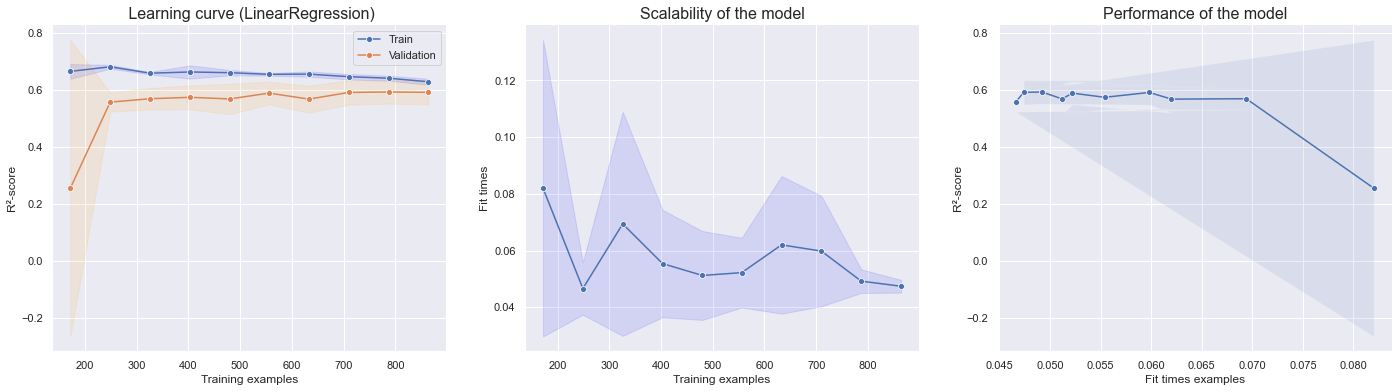

In [39]:
plot_learning_curve(reg, "LinearRegression", X_train, y_train, cv=kfold)

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>We can see as the training example increase, the R2 improves.</li>
    </ul>
</div>

### <font color= #00ADEF>6.1.2. Linear Regression predictions validations</font>

<div class="alert alert-block alert-info">
    To plot the <b>predictions validations</b>, we are going to use the <b>best  parameters</b> to analyze the model after <b>fitting</b> and <b>predicting</b> values</b>
</div>

In [40]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

reg = make_pipeline(preprocessor, LinearRegression(copy_X=search.best_params_.get("linearregression__copy_X"), 
                                                   fit_intercept=search.best_params_.get("linearregression__fit_intercept")
                                                  )
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

<div class="alert alert-block alert-info">
    Plotting <b>the Cross-Validated Predictions</b> based on the best parameters for <b>training data</b>
</div>

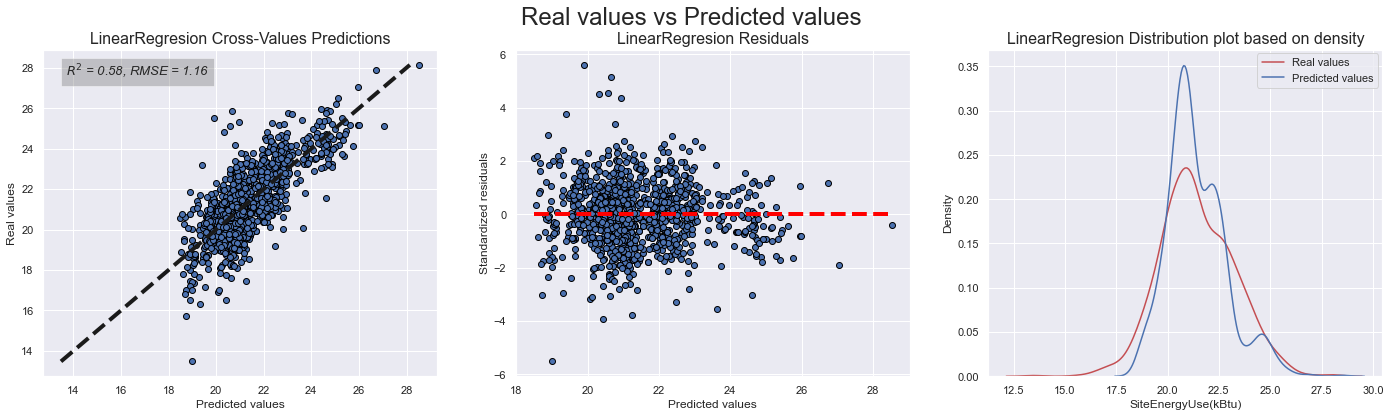

In [41]:
# Making the prediction using the testing data
plot_cross_val_predi(reg, "LinearRegresion", "SiteEnergyUse(kBtu)", X_train, y_train, cv=kfold)

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>In the Cross-Values Predictions we can compare in details the real values vs predicted values. <br>In this one, it is easy to see some correlation between the model's predictions and its actual results.</li>
        <li>On Residuals, we get positive values (on the y-axis) that mean the prediction was too low, and negative values mean the prediction was too high; 0 means the guess was exactly correct.</li>
    </ul>
</div>

### <font color= #00ADEF>6.1.3. Linear Regression Features Importance</font>

<div class="alert alert-block alert-info">
    To plot the <b>Features Importance</b>, we are going to use the <b>best  parameters</b> to analyze the model after <b>fitting</b> values</b>
</div>

In [42]:
reg = make_pipeline(preprocessor, LinearRegression(copy_X=search.best_params_.get("linearregression__copy_X"), 
                                                   fit_intercept=search.best_params_.get("linearregression__fit_intercept")
                                                  )
                   )

reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function boolean_transformation at 0x000002A42C107AC0>))]),
                                                  ['NaturalGas', 'SteamUse',
                                                   'OtherFuelUse']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Neighborhoo...
                                                                  ('functiontransformer',
          

<div class="alert alert-block alert-info">
    Plotting <b>the Features Importance</b> based on the best parameters
</div>

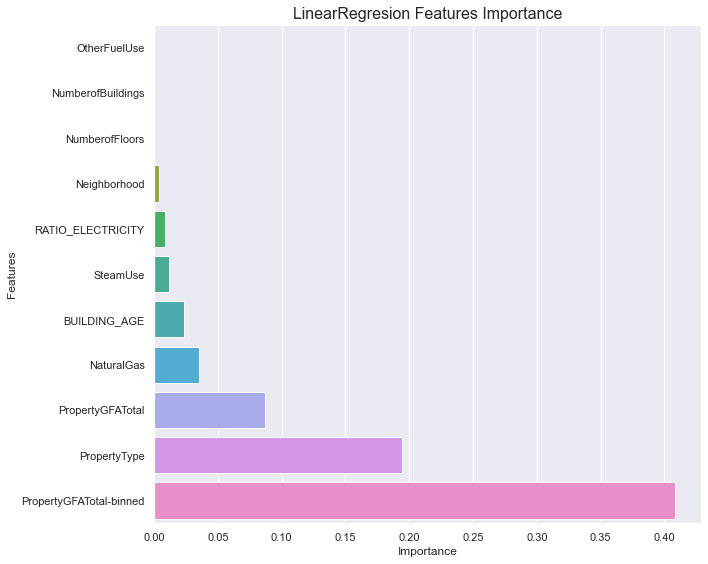

In [43]:
plot_features_importance(reg, "LinearRegresion", X_train, y_train, scoring="r2")


### <font color= #00ADEF>6.1.4. Polynomial Features</font>

   <p>we are going to work with a <b>Polynomial Features</b> to make a model more complex</p>
        <p>Initializing model</p>


In [44]:
poly = PolynomialFeatures()

lr = LinearRegression()

<div class="alert alert-block alert-info">
    Data preprocessing based on the pipelines and the regressors setup
</div>

In [45]:
poly_reg = make_pipeline(preprocessor, poly, lr)

<div class="alert alert-block alert-info">
    Identifying the names of each parameter
</div>

In [46]:
sorted(poly_reg.get_params().keys())

['columntransformer',
 'columntransformer__n_jobs',
 'columntransformer__pipeline-1',
 'columntransformer__pipeline-1__functiontransformer',
 'columntransformer__pipeline-1__functiontransformer__accept_sparse',
 'columntransformer__pipeline-1__functiontransformer__check_inverse',
 'columntransformer__pipeline-1__functiontransformer__func',
 'columntransformer__pipeline-1__functiontransformer__inv_kw_args',
 'columntransformer__pipeline-1__functiontransformer__inverse_func',
 'columntransformer__pipeline-1__functiontransformer__kw_args',
 'columntransformer__pipeline-1__functiontransformer__validate',
 'columntransformer__pipeline-1__memory',
 'columntransformer__pipeline-1__steps',
 'columntransformer__pipeline-1__verbose',
 'columntransformer__pipeline-2',
 'columntransformer__pipeline-2__memory',
 'columntransformer__pipeline-2__onehotencoder',
 'columntransformer__pipeline-2__onehotencoder__categories',
 'columntransformer__pipeline-2__onehotencoder__drop',
 'columntransformer__pipe

<div class="alert alert-block alert-info">
    Parameters settings 
</div>

In [47]:
param_grid = {
    "polynomialfeatures__degree" : [1, 2, 3, 4],
    "linearregression__copy_X" : [True, False],
    "linearregression__fit_intercept" : [True, False]
}

<div class="alert alert-block alert-info">
    Executing the model
</div>

In [48]:
# K-Folds cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

search = GridSearchCV(poly_reg, param_grid, n_jobs=-2, cv=kfold, scoring=SCORINGS, refit="R2", return_train_score=True)

search.fit(X_train, y_train)

# Transforming the result to dataframe format
df_results = pd.DataFrame(search.cv_results_)

# Get the results
print("Metrics based on the best R2".translate(SUP))
print("- 1 - " + "R2:".translate(SUP), round((1 - search.best_score_), 3)) 
print("- MAE:", round(abs(df_results.iloc[search.best_index_]["mean_test_MAE"]), 3))
print("- RMSE:", round(math.sqrt(abs(df_results.iloc[search.best_index_]["mean_test_MSE"])), 3))
print("- Duration:", round(df_results.iloc[search.best_index_]["mean_score_time"], 3))
print("- Parameters:", search.best_params_)

Metrics based on the best R²
- 1 - R²: 0.418
- MAE: 0.891
- RMSE: 1.164
- Duration: 0.03
- Parameters: {'linearregression__copy_X': True, 'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 1}


<div class="alert alert-block alert-info">
    We got the <b>best parameters</b> so, we are going to <b>analyze</b> them more in details 
</div>


#### <font color= #00ADEF>6.1.4.1. Linear Regression and Polynomial Features Validation curve</font>

<div class="alert alert-block alert-info">
    To plot the <b>Validation curve</b>, we are going to use a <b>range of neighbors</b> to analyze the model through them
</div>

In [49]:
kfold = KFold(n_splits=5, shuffle=False, random_state=None)

degree = [1, 2, 3, 4, 5]

reg = make_pipeline(preprocessor, PolynomialFeatures(), 
                    LinearRegression(fit_intercept=search.best_params_.get("linearregression__fit_intercept"), copy_X=search.best_params_.get("linearregression__copy_X"))
                   )

<div class="alert alert-block alert-info">
    Plotting <b>the validacion curve</b> based on the best parameters
</div>

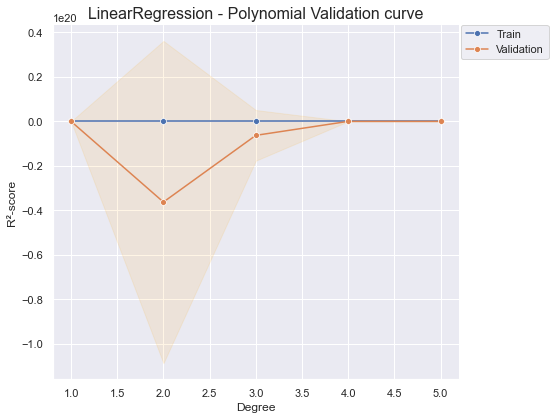

In [50]:
plot_validation_curve_by(reg, "LinearRegression - Polynomial", "R2SCORE", X_train, y_train, param_name="polynomialfeatures__degree", param_range=degree, param_name_short="Degree", cv=kfold)

<div class="alert alert-block alert-warning">
    It is necessary to remenber that we are treating with Non-linear Dataset. 
</div>


#### <font color= #00ADEF>6.1.4.2. Linear Regression and Polynomial Features Learning curve</font>

<div class="alert alert-block alert-info">
    To plot the <b>Learning curve</b>, we are going to use the <b>best  parameters</b> to analyze the model
</div>

In [51]:
kfold = KFold(n_splits=5, shuffle=False, random_state=None)

reg = make_pipeline(preprocessor, PolynomialFeatures(degree=search.best_params_.get("linearregression__copy_X")), 
                    LinearRegression(fit_intercept=search.best_params_.get("linearregression__fit_intercept"),
                                     copy_X=search.best_params_.get("linearregression__copy_X"))
                   )

<div class="alert alert-block alert-info">
    Plotting <b>the learning curve</b> based on the best parameters
</div>

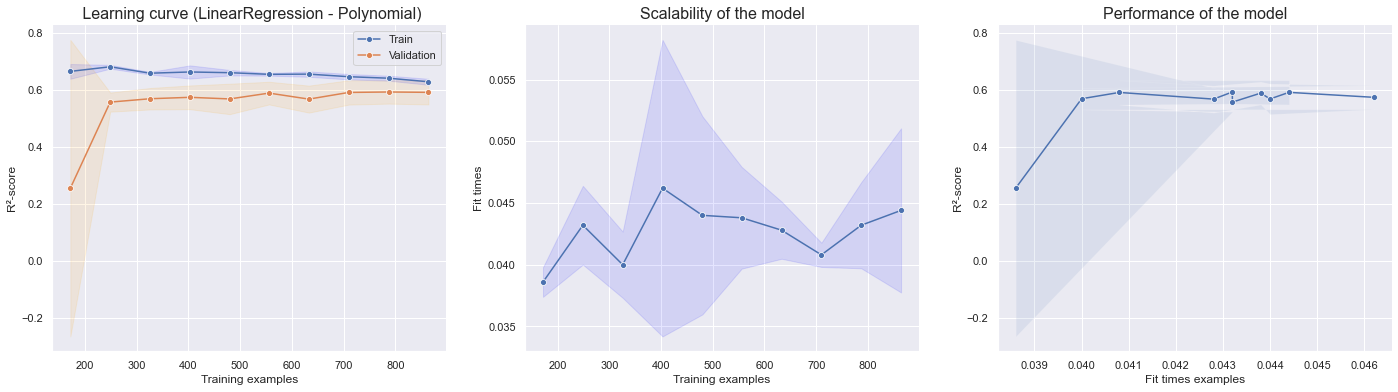

In [52]:
plot_learning_curve(reg, "LinearRegression - Polynomial", X_train, y_train, cv=kfold)

#### <font color= #00ADEF>6.1.4.3. Linear Regression and Polynomial Features predictions validations</font>

<div class="alert alert-block alert-info">
    To plot the <b>predictions validations</b>, we are going to use the <b>best  parameters</b> to analyze the model after <b>fitting</b> and <b>predicting</b> values</b>
</div>

In [53]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

reg = make_pipeline(preprocessor, PolynomialFeatures(degree=search.best_params_.get("linearregression__copy_X")), 
                    LinearRegression(fit_intercept=search.best_params_.get("linearregression__fit_intercept"),
                                     copy_X=search.best_params_.get("linearregression__copy_X"))
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

<div class="alert alert-block alert-info">
    Plotting <b>the Cross-Validated Predictions</b> based on the best parameters for <b>training data</b>
</div>

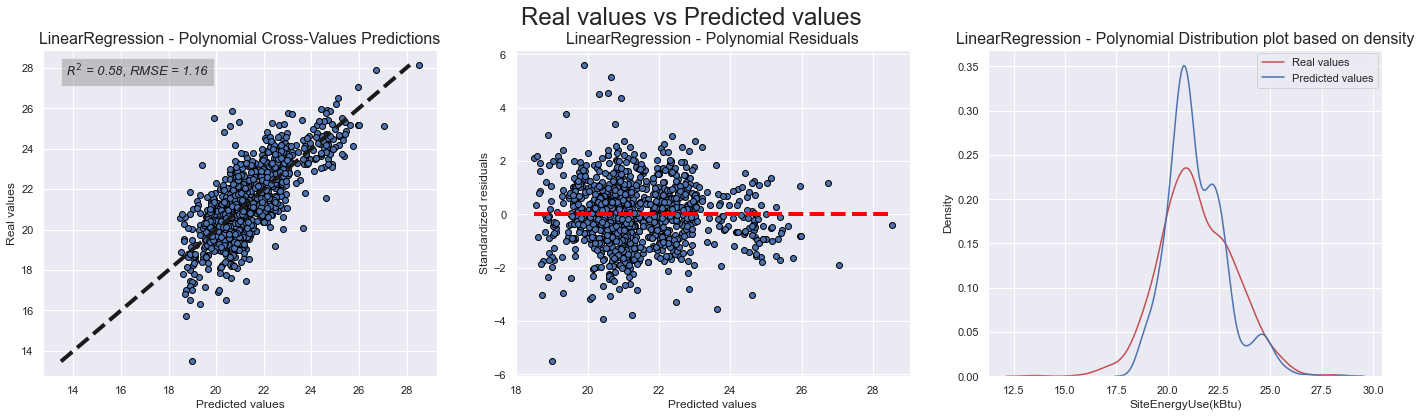

In [54]:
# Making the prediction using the testing data
plot_cross_val_predi(reg, "LinearRegression - Polynomial", "SiteEnergyUse(kBtu)", X_train, y_train, cv=kfold)

#### <font color= #00ADEF>6.1.4.4. Linear Regression and Polynomial Features Features Importance</font>


<div class="alert alert-block alert-info">
    To plot the <b>Features Importance</b>, we are going to use the <b>best  parameters</b> to analyze the model after <b>fitting</b> values</b>
</div>

In [55]:
reg = make_pipeline(preprocessor, PolynomialFeatures(degree=search.best_params_.get("linearregression__copy_X")), 
                    LinearRegression(fit_intercept=search.best_params_.get("linearregression__fit_intercept"),
                                     copy_X=search.best_params_.get("linearregression__copy_X"))
                   )

reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function boolean_transformation at 0x000002A42C107AC0>))]),
                                                  ['NaturalGas', 'SteamUse',
                                                   'OtherFuelUse']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Neighborhoo...
                                                                   FunctionTransformer(func=<functio

<div class="alert alert-block alert-info">
    Plotting <b>the Features Importance</b> based on the best parameters
</div>

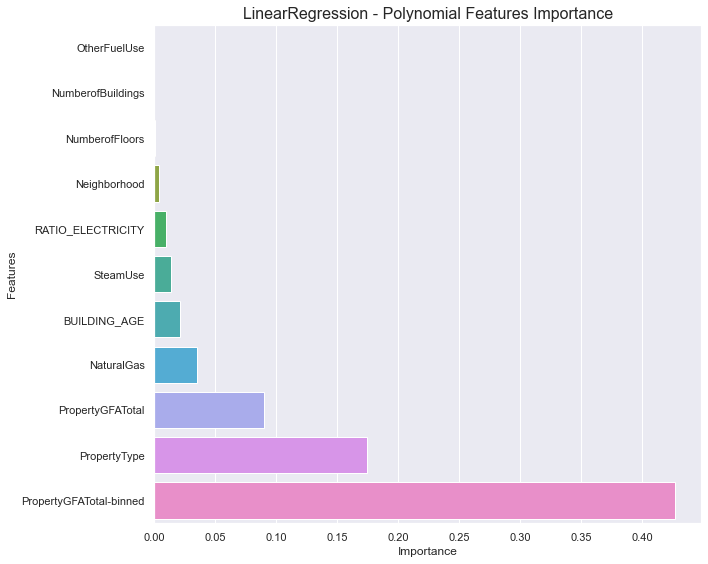

In [56]:
plot_features_importance(reg, "LinearRegression - Polynomial", X_train, y_train, scoring="r2")


### <font color= #00ADEF>6.1.5 Predictions metrics</font>

<div class="alert alert-block alert-info">
    <p>To make the comparison among predictions metrics, we are going to select the Linear Regresion without the transformation through Polynomial Features.</p>
    
    <p>At the same time, we are going to make the prediction with the testing set to compare the result with the model in default mode</p>
</div>

In [57]:
start_time_model = timeit.default_timer()

reg = make_pipeline(preprocessor, LinearRegression(fit_intercept=search.best_params_.get("linearregression__fit_intercept"),
                                                   copy_X=search.best_params_.get("linearregression__copy_X"))
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

# Calculating R2 Coefficient of determination for each model (Best possible score is 1.0, lower values are worse.)
R2SCORE = round((1 - r2_score(y_test, y_pred)), 5)
    
# Calculating the Mean absolute error (The best value is 0.0)
MAE = round(mean_absolute_error(y_test, y_pred), 3)
    
# Calculating Root Mean Square Error for each model (The best value is 0.0)
RMSE = round(mean_squared_error(y_test, y_pred, squared=False), 3)

<div class="alert alert-block alert-info">
    Adding the prediction to compare at the end
</div>

In [58]:
# Concatenating predictions to compare against y_test_transformed
df_temp = pd.DataFrame({
    "Model" : "LinearRegression",
    "y_pred" : y_pred
})

In [59]:
# Concatenating predictions to compare against y_test_transformed
df_y_pred_hyperparameters = pd.concat([df_y_pred_hyperparameters, df_temp])

<div class="alert alert-block alert-info">
    Verifying the prediction model into the dataset
</div>

In [60]:
df_y_pred_hyperparameters["Model"].unique()

array(['Original', 'LinearRegression'], dtype=object)

<div class="alert alert-block alert-info">
    Adding metrics to compare at the end
</div>

In [61]:
df_temp = pd.DataFrame({
    "Model" : ["LinearRegression"],
    "1 - " + "R2".translate(SUP) : [R2SCORE], 
    "MAE" : [MAE],    
    "RMSE" : [RMSE],
    "Duration" : [end_time_model]
})

In [62]:
# Concatenating metrics to compare against model with default parameters
df_models_hyperparameters = pd.concat([df_models_hyperparameters, df_temp])

In [63]:
df_models_hyperparameters

,Model,1 - R²,MAE,RMSE,Duration
0,LinearRegression,0.96092,1.09,1.801,0.043


<div class="alert alert-block alert-success">
    Compared to the model with default parameters, we can see that the result (for Linear Regression) is very similar
</div>


## <font color= #00ADEF>6.2. KNeighbors optimization</font>

<div class="alert alert-block alert-info">
    Initializing model
</div>

In [64]:
knn = KNeighborsRegressor()

<div class="alert alert-block alert-info">
    Data preprocessing based on the pipelines and the regressors setup
</div>

In [65]:
reg = make_pipeline(preprocessor, knn)

<div class="alert alert-block alert-info">
    Identifying the names of each parameter
</div>

In [66]:
sorted(reg.get_params().keys())

['columntransformer',
 'columntransformer__n_jobs',
 'columntransformer__pipeline-1',
 'columntransformer__pipeline-1__functiontransformer',
 'columntransformer__pipeline-1__functiontransformer__accept_sparse',
 'columntransformer__pipeline-1__functiontransformer__check_inverse',
 'columntransformer__pipeline-1__functiontransformer__func',
 'columntransformer__pipeline-1__functiontransformer__inv_kw_args',
 'columntransformer__pipeline-1__functiontransformer__inverse_func',
 'columntransformer__pipeline-1__functiontransformer__kw_args',
 'columntransformer__pipeline-1__functiontransformer__validate',
 'columntransformer__pipeline-1__memory',
 'columntransformer__pipeline-1__steps',
 'columntransformer__pipeline-1__verbose',
 'columntransformer__pipeline-2',
 'columntransformer__pipeline-2__memory',
 'columntransformer__pipeline-2__onehotencoder',
 'columntransformer__pipeline-2__onehotencoder__categories',
 'columntransformer__pipeline-2__onehotencoder__drop',
 'columntransformer__pipe

<div class="alert alert-block alert-info">
    Parameters settings
</div>

In [67]:
param_grid = {
    "kneighborsregressor__n_neighbors" : [3, 5, 7, 9, 11, 13, 15, 20, 50], # Number of neighbors to use by default for kneighbors queries.
    "kneighborsregressor__metric" : ["euclidean", "manhattan"] # The distance metric to use for the tree.
}

<div class="alert alert-block alert-info">
    Executing the model
</div>

In [68]:
# K-Folds cross-validator
kfold = KFold(n_splits=5, shuffle=False, random_state=None)

search = GridSearchCV(reg, param_grid, n_jobs=-2, cv=kfold, scoring=SCORINGS, refit="R2", return_train_score=True)

search.fit(X_train, y_train)

# Transforming the result to dataframe format
df_results = pd.DataFrame(search.cv_results_)

# Get the results
print("Metrics based on the best R2".translate(SUP))
print("- 1 " + "- R2:".translate(SUP), round((1 - search.best_score_), 3))
print("- MAE:", round(abs(df_results.iloc[search.best_index_]["mean_test_MAE"]), 3))
print("- RMSE:", round(math.sqrt(abs(df_results.iloc[search.best_index_]["mean_test_MSE"])), 3))
print("- Duration:", round(df_results.iloc[search.best_index_]["mean_score_time"], 3))
print("- Parameters:", search.best_params_)

Metrics based on the best R²
- 1 - R²: 0.362
- MAE: 0.812
- RMSE: 1.081
- Duration: 0.047
- Parameters: {'kneighborsregressor__metric': 'manhattan', 'kneighborsregressor__n_neighbors': 7}


<div class="alert alert-block alert-info">
    Adding metrics to compare at the end
</div>

In [69]:
df_temp = pd.DataFrame({
    "Model" : ["KNeighbors"],
    "1 - " + "R2".translate(SUP) : round((1 - search.best_score_), 3), 
    "MAE" : round(abs(df_results.iloc[search.best_index_]["mean_test_MAE"]), 3),    
    "RMSE" : round(math.sqrt(abs(df_results.iloc[search.best_index_]["mean_test_MSE"])), 3),
    "Duration" : round(df_results.iloc[search.best_index_]["mean_score_time"], 3)
})

In [70]:
# Concatenating metrics to compare against model with default parameters
df_models_metrics_gsc = pd.concat([df_models_metrics_gsc, df_temp])

In [71]:
df_models_metrics_gsc

,Model,1 - R²,MAE,RMSE,Duration
0,LinearRegression,0.418,0.891,1.164,0.027
0,KNeighbors,0.362,0.812,1.081,0.047


<div class="alert alert-block alert-success">
    We got the <b>best parameters</b> so, we are going to <b>analyze</b> them more in details 
</div>


### <font color= #00ADEF>6.2.1 KNeighbors Validation curve</font>

<div class="alert alert-block alert-info">
    To plot the <b>Validation curve</b>, we are going to use a <b>range of neighbors</b> to analyze the model through them
</div>

In [72]:
kfold = KFold(n_splits=5, shuffle=False, random_state=None)

n_neighbors = [3, 5, 7, 9, 11, 13, 15, 20, 25, 30, 35, 40, 45, 50]

reg = make_pipeline(preprocessor, KNeighborsRegressor(metric=search.best_params_.get("kneighborsregressor__metric")))

<div class="alert alert-block alert-info">
    Plotting <b>the validacion curve</b> based on the best parameters
</div>

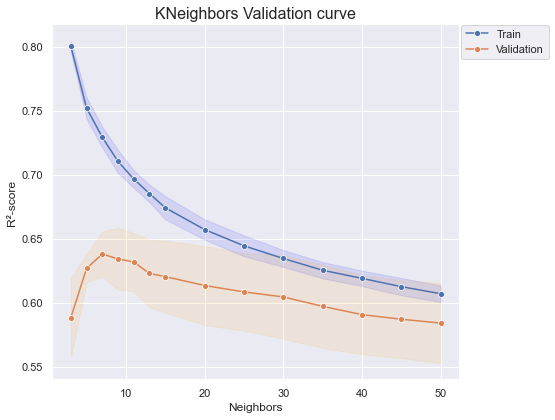

In [73]:
plot_validation_curve_by(reg, "KNeighbors", "R2SCORE", X_train, y_train, param_name="kneighborsregressor__n_neighbors", param_range=n_neighbors, param_name_short="Neighbors", cv=kfold)

   <p><b>Observations / Conclusions</b></p>
        <li>For <b>Neighbors values of 20 to 50</b>, we can see a <b>High Bias</b> and <b>Low Variance</b> so, for this parameters the model is <b>Underfitting</b> maybe due to have a poor feature set <br>or the relationships in the data are inherently</li>
        <li>For <b>Neighbors values of 3 to 13</b>, we have a poorly performs for train and validation set so, for this parameters the model is <b>Underfitting</b> as well</li>
        <li>The best result if for <b>Neighbors value of 15</b> but, like the previous point we have a poorly performs for both sets. So, in general the model is <b>Underfitting</b></li>


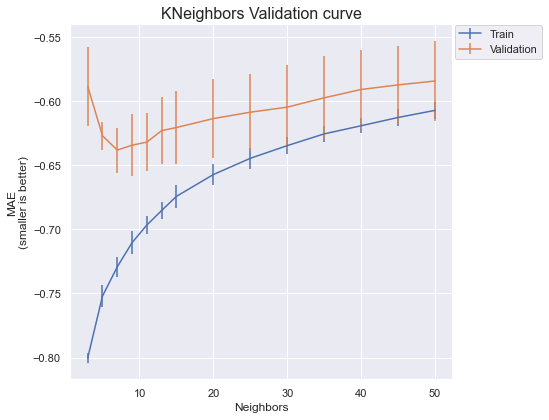

In [74]:
plot_validation_curve_by(reg, "KNeighbors", "MAE", X_train, y_train, param_name="kneighborsregressor__n_neighbors", param_range=n_neighbors, param_name_short="Neighbors", cv=kfold)


### <font color= #00ADEF>6.2.2 KNeighbors Learning curve</font>

<div class="alert alert-block alert-info">
    To plot the <b>Learning curve</b>, we are going to use the <b>best  parameters</b> to analyze the model
</div>

In [75]:
kfold = KFold(n_splits=5, shuffle=False, random_state=None)

reg = make_pipeline(preprocessor, KNeighborsRegressor(n_neighbors=search.best_params_.get("kneighborsregressor__n_neighbors"), 
                                                      metric=search.best_params_.get("kneighborsregressor__metric"))
                   )

<div class="alert alert-block alert-info">
    Plotting <b>the learning curve</b> based on the best parameters
</div>

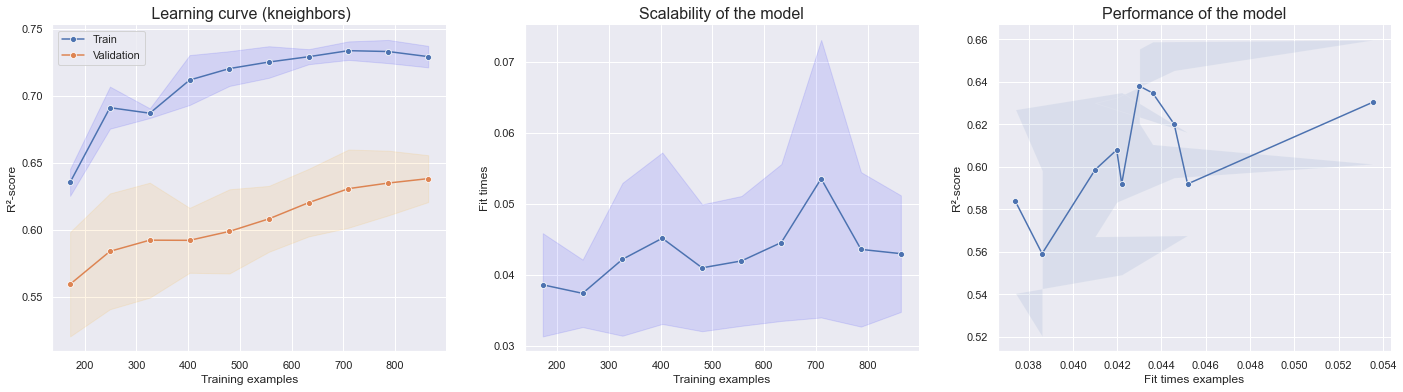

In [76]:
plot_learning_curve(reg, "kneighbors", X_train, y_train, cv=kfold)


### <font color= #00ADEF>6.2.3 KNeighbors predictions validations</font>

<div class="alert alert-block alert-info">
    To plot the <b>predictions validations</b>, we are going to use the <b>best  parameters</b> to analyze the model after <b>fitting</b> and <b>predicting</b> values</b>
</div>

In [77]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

reg = make_pipeline(preprocessor, KNeighborsRegressor(n_neighbors=search.best_params_.get("kneighborsregressor__n_neighbors"), 
                                                      metric=search.best_params_.get("kneighborsregressor__metric"))
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

<div class="alert alert-block alert-info">
    Plotting <b>the Cross-Validated Predictions</b> based on the best parameters for <b>training data</b>
</div>

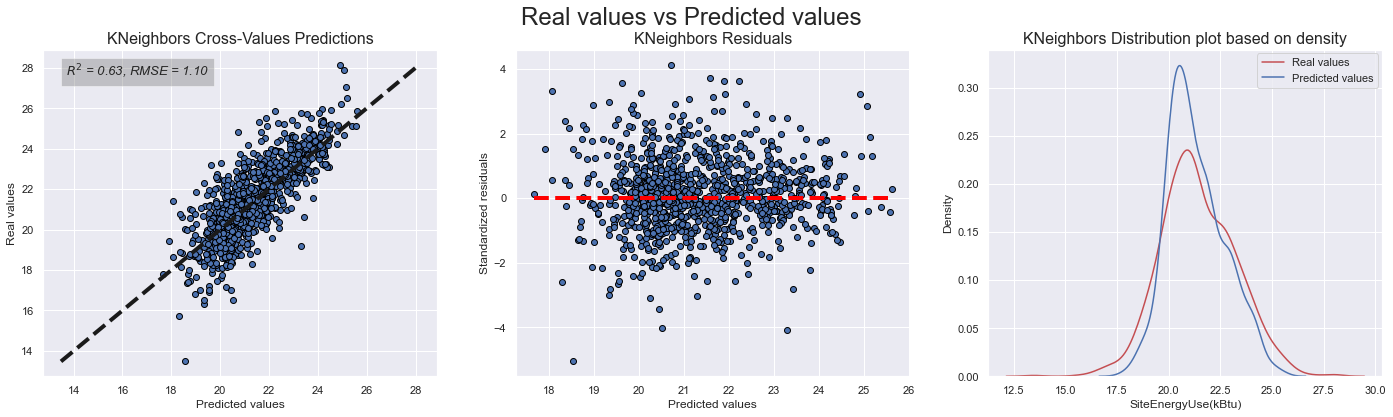

In [78]:
# Making the prediction using the testing data
plot_cross_val_predi(reg, "KNeighbors", "SiteEnergyUse(kBtu)", X_train, y_train, cv=kfold)

### <font color= #00ADEF>6.2.4 KNeighbors Features Importance</font>

<div class="alert alert-block alert-info">
    To plot the <b>Features Importance</b>, we are going to use the <b>best  parameters</b> to analyze the model after <b>fitting</b> values</b>
</div>

In [79]:
reg = make_pipeline(preprocessor, KNeighborsRegressor(n_neighbors=search.best_params_.get("kneighborsregressor__n_neighbors"), 
                                                      metric=search.best_params_.get("kneighborsregressor__metric"))
                   )

reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function boolean_transformation at 0x000002A42C107AC0>))]),
                                                  ['NaturalGas', 'SteamUse',
                                                   'OtherFuelUse']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Neighborhoo...
                                                                   FunctionTransformer(func=<functio

<div class="alert alert-block alert-info">
    Plotting <b>the Features Importance</b> based on the best parameters
</div>

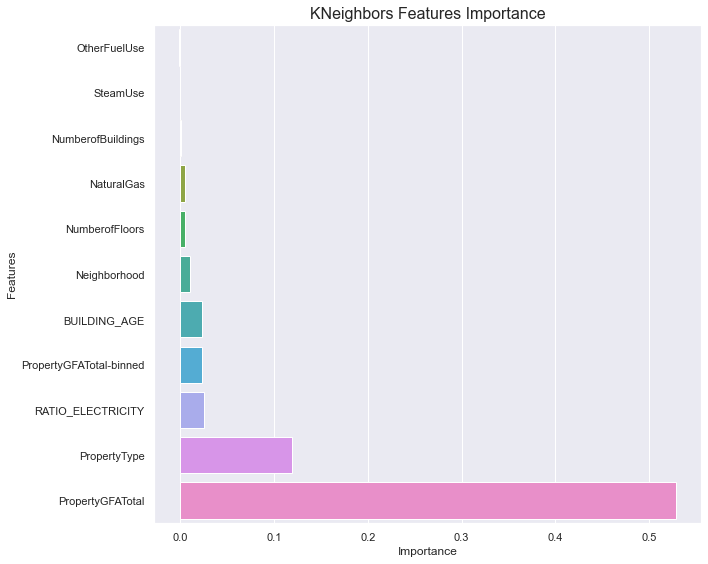

In [80]:
plot_features_importance(reg, "KNeighbors", X_train, y_train, scoring="r2")


### <font color= #00ADEF>6.2.5 Find the k Nearest Neighbors</font>

<div class="alert alert-block alert-info">
    We are going to <b>process data</b> directly with <b>make_column_transformer</b> already defined
</div>

In [81]:
X_train_transformed = preprocessor.fit_transform(X_train)

In [82]:
X_train_transformed.shape

(1080, 29)

In [83]:
X_test_transformed = preprocessor.fit_transform(X_test)

In [84]:
X_test_transformed.shape

(533, 29)

<div class="alert alert-block alert-info">
    Now, we are going to select <b>one random sample</b> of X_test to find its Neighbors
</div>

In [85]:
seed(0)

# considering the X_test shape
indice = randint(0, 496, 1)
indice

array([172])

In [86]:
X_test_sample_transformed = X_test_transformed[indice]

<div class="alert alert-block alert-info">
    Initializing model
</div>

In [87]:
nbrs = NearestNeighbors(n_neighbors=15, metric="euclidean")

<div class="alert alert-block alert-info">
    Fitting the NearestNeighbors
</div>

In [88]:
nbrs.fit(X_train_transformed)

NearestNeighbors(metric='euclidean', n_neighbors=15)

<div class="alert alert-block alert-info">
    Finding the neighbors
</div>

In [89]:
distances, indices = nbrs.kneighbors(X_test_sample_transformed)

<div class="alert alert-block alert-info">
    Sample selected
</div>

In [90]:
X_test.iloc[indice]

,NumberofFloors,NumberofBuildings,BUILDING_AGE,PropertyGFATotal,PropertyGFATotal-binned,Neighborhood,PropertyType,RATIO_ELECTRICITY,NaturalGas,SteamUse,OtherFuelUse
756,3.0,1.0,42.0,794592.0,Large,DOWNTOWN,Office,97.27586,True,False,False


<div class="alert alert-block alert-info">
    Sample selected neighbors
</div>

In [91]:
X_train.iloc[indices[0].tolist()]

,NumberofFloors,NumberofBuildings,BUILDING_AGE,PropertyGFATotal,PropertyGFATotal-binned,Neighborhood,PropertyType,RATIO_ELECTRICITY,NaturalGas,SteamUse,OtherFuelUse
708,3.0,1.0,13.0,824887.0,Large,DOWNTOWN,Office,100.00417,False,False,False
1124,6.0,1.0,22.0,706176.0,Large,DOWNTOWN,Office,100.00414,False,False,False
723,3.0,1.0,49.0,617684.0,Large,DOWNTOWN,Office,92.89225,False,True,False
781,5.0,1.0,20.0,560516.0,Large,LAKE UNION,Office,70.89466,True,False,False
977,5.0,1.0,13.0,508160.0,Large,LAKE UNION,Office,83.47400,True,False,False
1455,5.0,1.0,32.0,597519.0,Large,CENTRAL,Health,40.69882,True,False,False
896,8.0,1.0,24.0,446261.0,Large,DOWNTOWN,Office,100.00415,False,False,False
683,12.0,1.0,12.0,571329.0,Large,LAKE UNION,Office,82.03410,True,False,False
735,6.0,1.0,40.0,396626.0,Large,DOWNTOWN,Office,100.00414,False,False,False
764,14.0,1.0,30.0,690158.0,Large,EAST,Office,100.00416,False,False,False


<div class="alert alert-block alert-info">
    Mean values for features and target based on neighbors
</div>

In [92]:
X_train.iloc[indices[0].tolist()].mean()

C:\Users\victo\AppData\Local\Temp\ipykernel_1220\3438238569.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X_train.iloc[indices[0].tolist()].mean()


NumberofFloors            6.000000
NumberofBuildings         1.000000
BUILDING_AGE             31.933333
PropertyGFATotal     574371.200000
RATIO_ELECTRICITY        80.255590
NaturalGas                0.533333
SteamUse                  0.133333
OtherFuelUse              0.000000
dtype: float64

In [93]:
y_train.iloc[indices[0].tolist()].mean()

25.00544308543092

<div class="alert alert-block alert-info">
    Real values for test
</div>

In [94]:
y_test.iloc[indice]

756    24.602606
Name: SiteEnergyUse(kBtu), dtype: float64

<div class="alert alert-block alert-success">
    At this point, we can see that the prediction is very close to real value
</div>


### <font color= #00ADEF>6.2.6 Predictions metrics</font>

<div class="alert alert-block alert-info">
    We are going to make the prediction with the testing set to compare the result with the model in default mode
</div>

In [95]:
start_time_model = timeit.default_timer()

reg = make_pipeline(preprocessor, KNeighborsRegressor(n_neighbors=search.best_params_.get("kneighborsregressor__n_neighbors"), 
                                                      metric=search.best_params_.get("kneighborsregressor__metric"))
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

# Calculating R2 Coefficient of determination for each model (Best possible score is 1.0, lower values are worse.)
R2SCORE = round((1 - r2_score(y_test, y_pred)), 5)
    
# Calculating the Mean absolute error (The best value is 0.0)
MAE = round(mean_absolute_error(y_test, y_pred), 3)
    
# Calculating Root Mean Square Error for each model (The best value is 0.0)
RMSE = round(mean_squared_error(y_test, y_pred, squared=False), 3)

<div class="alert alert-block alert-info">
    Adding the prediction to compare at the end
</div>

In [96]:
# Concatenating predictions to compare against y_test_transformed
df_temp = pd.DataFrame({
    "Model" : "KNeighbors",
    "y_pred" : y_pred
})

In [97]:
# Concatenating predictions to compare against y_test_transformed
df_y_pred_hyperparameters = pd.concat([df_y_pred_hyperparameters, df_temp])

<div class="alert alert-block alert-info">
    Verifying the prediction model into the dataset
</div>

In [98]:
df_y_pred_hyperparameters["Model"].unique()

array(['Original', 'LinearRegression', 'KNeighbors'], dtype=object)

<div class="alert alert-block alert-info">
    Adding metrics to compare at the end
</div>

In [99]:
df_temp = pd.DataFrame({
    "Model" : ["KNeighbors"],
    "1 - " + "R2".translate(SUP) : [R2SCORE], 
    "MAE" : [MAE],    
    "RMSE" : [RMSE],
    "Duration" : [end_time_model]
})

In [100]:
# Concatenating metrics to compare against model with default parameters
df_models_hyperparameters = pd.concat([df_models_hyperparameters, df_temp])

In [101]:
df_models_hyperparameters

,Model,1 - R²,MAE,RMSE,Duration
0,LinearRegression,0.96092,1.090,1.801,0.043
0,KNeighbors,0.40705,0.835,1.172,0.448


<div class="alert alert-block alert-success">
    Compared to the model with default parameters, we can see that the result (for Linear Regression) has improved
</div>


## <font color= #00ADEF>6.3. Lasso optimization</font>

<div class="alert alert-block alert-info">
    Initializing model
</div>

In [102]:
ls = Lasso()

<div class="alert alert-block alert-info">
    Data preprocessing based on the pipelines and the regressors setup
</div>

In [103]:
reg = make_pipeline(preprocessor, ls)

<div class="alert alert-block alert-info">
    Identifying the names of each parameter
</div>

In [104]:
sorted(reg.get_params().keys())

['columntransformer',
 'columntransformer__n_jobs',
 'columntransformer__pipeline-1',
 'columntransformer__pipeline-1__functiontransformer',
 'columntransformer__pipeline-1__functiontransformer__accept_sparse',
 'columntransformer__pipeline-1__functiontransformer__check_inverse',
 'columntransformer__pipeline-1__functiontransformer__func',
 'columntransformer__pipeline-1__functiontransformer__inv_kw_args',
 'columntransformer__pipeline-1__functiontransformer__inverse_func',
 'columntransformer__pipeline-1__functiontransformer__kw_args',
 'columntransformer__pipeline-1__functiontransformer__validate',
 'columntransformer__pipeline-1__memory',
 'columntransformer__pipeline-1__steps',
 'columntransformer__pipeline-1__verbose',
 'columntransformer__pipeline-2',
 'columntransformer__pipeline-2__memory',
 'columntransformer__pipeline-2__onehotencoder',
 'columntransformer__pipeline-2__onehotencoder__categories',
 'columntransformer__pipeline-2__onehotencoder__drop',
 'columntransformer__pipe

<div class="alert alert-block alert-info">
    Parameters settings
</div>

In [105]:
param_grid = {
    "lasso__alpha" : np.arange(0.01, 1, 0.01), # Constant that multiplies the L1 term.
    "lasso__copy_X" : [True, False], # If True, X will be copied; else, it may be overwritten.
    "lasso__fit_intercept" : [True, False] # Whether to calculate the intercept for this model.
}

<div class="alert alert-block alert-info">
    Executing the model
</div>

In [106]:
# K-Folds cross-validator
kfold = KFold(n_splits=5, shuffle=False, random_state=None)

search = GridSearchCV(reg, param_grid, n_jobs=-2, cv=kfold, scoring=SCORINGS, refit="R2", return_train_score=True)

search.fit(X_train, y_train)

# Transforming the result to dataframe format
df_results = pd.DataFrame(search.cv_results_)

# Get the results
print("Metrics based on the best R2".translate(SUP))
print("- 1 - " + "R2:".translate(SUP), round((1 - search.best_score_), 3))
print("- MAE:", round(abs(df_results.iloc[search.best_index_]["mean_test_MAE"]), 3))
print("- RMSE:", round(math.sqrt(abs(df_results.iloc[search.best_index_]["mean_test_MSE"])), 3))
print("- Duration:", round(df_results.iloc[search.best_index_]["mean_score_time"], 3))
print("- Parameters:", search.best_params_)

Metrics based on the best R²
- 1 - R²: 0.407
- MAE: 0.885
- RMSE: 1.143
- Duration: 0.023
- Parameters: {'lasso__alpha': 0.01, 'lasso__copy_X': True, 'lasso__fit_intercept': True}


<div class="alert alert-block alert-info">
    Adding metrics to compare at the end
</div>

In [107]:
df_temp = pd.DataFrame({
    "Model" : ["Lasso"],
    "1 - " + "R2".translate(SUP) : round((1 - search.best_score_), 3), 
    "MAE" : round(abs(df_results.iloc[search.best_index_]["mean_test_MAE"]), 3),    
    "RMSE" : round(math.sqrt(abs(df_results.iloc[search.best_index_]["mean_test_MSE"])), 3),
    "Duration" : round(df_results.iloc[search.best_index_]["mean_score_time"], 3)
})

In [108]:
# Concatenating metrics to compare against model with default parameters
df_models_metrics_gsc = pd.concat([df_models_metrics_gsc, df_temp])

In [109]:
df_models_metrics_gsc

,Model,1 - R²,MAE,RMSE,Duration
0,LinearRegression,0.418,0.891,1.164,0.027
0,KNeighbors,0.362,0.812,1.081,0.047
0,Lasso,0.407,0.885,1.143,0.023


<div class="alert alert-block alert-success">
    We got the <b>best parameters</b> so, we are going to <b>analyze</b> them more in details 
</div>


### <font color= #00ADEF>6.3.1 Lasso Validation curve</font>

<div class="alert alert-block alert-info">
    To plot the <b>Validation curve</b>, we are going to use a <b>range of alpha</b> to analyze the model through them
</div>

In [110]:
kfold = KFold(n_splits=5, shuffle=False, random_state=None)

alpha = np.arange(0.01, 1, 0.01).tolist()

reg = make_pipeline(preprocessor, Lasso(copy_X=search.best_params_.get("lasso__copy_X"), 
                                        fit_intercept=search.best_params_.get("lasso__fit_intercept"))
                   )

<div class="alert alert-block alert-info">
    Plotting <b>the validacion curve</b> based on the best parameters
</div>

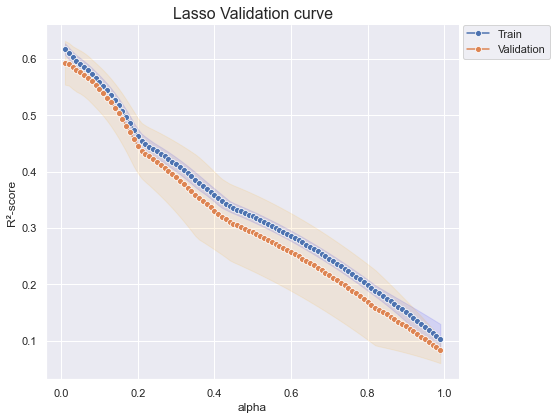

In [111]:
plot_validation_curve_by(reg, "Lasso", "R2SCORE", X_train, y_train, param_name="lasso__alpha", param_range=alpha, param_name_short="alpha", cv=kfold)

   <p><b>Observations / Conclusions</b></p>    
    <p>As you go through <b>alpha</b> you can see how the score decrease. We can say that the model is <b>Underfitting</b> maybe due to have a poor feature set <br>or the relationships in the data are inherently</p>
    <p>We have have to consider that <b>Lasso</b> is a type of regularized linear regression that includes an L1 penalsy so, it considers a Linear regresion among the features and the targed. On the other hand, we are working with a Non-linear dataset.</p>



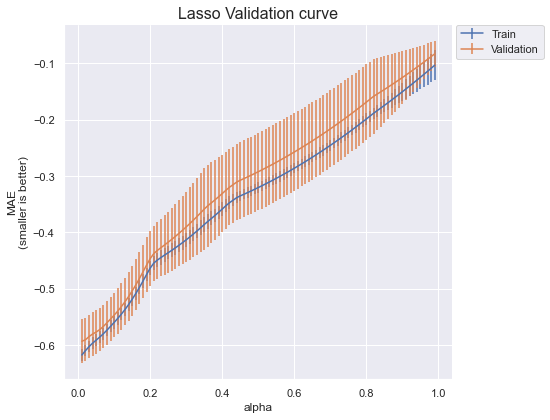

In [112]:
plot_validation_curve_by(reg, "Lasso", "MAE", X_train, y_train, param_name="lasso__alpha", param_range=alpha, param_name_short="alpha", cv=kfold)

### <font color= #00ADEF>6.3.2 Lasso Learning curve</font>

<div class="alert alert-block alert-info">
    To plot the <b>Learning curve</b>, we are going to use the <b>best  parameters</b> to analyze the model
</div>

In [113]:
kfold = KFold(n_splits=5, shuffle=False, random_state=None)

reg = make_pipeline(preprocessor, Lasso(alpha=search.best_params_.get("lasso__alpha"), 
                                        copy_X=search.best_params_.get("lasso__copy_X"), 
                                        fit_intercept=search.best_params_.get("lasso__fit_intercept"))
                   )

<div class="alert alert-block alert-info">
    Plotting <b>the learning curve</b> based on the best parameters
</div>

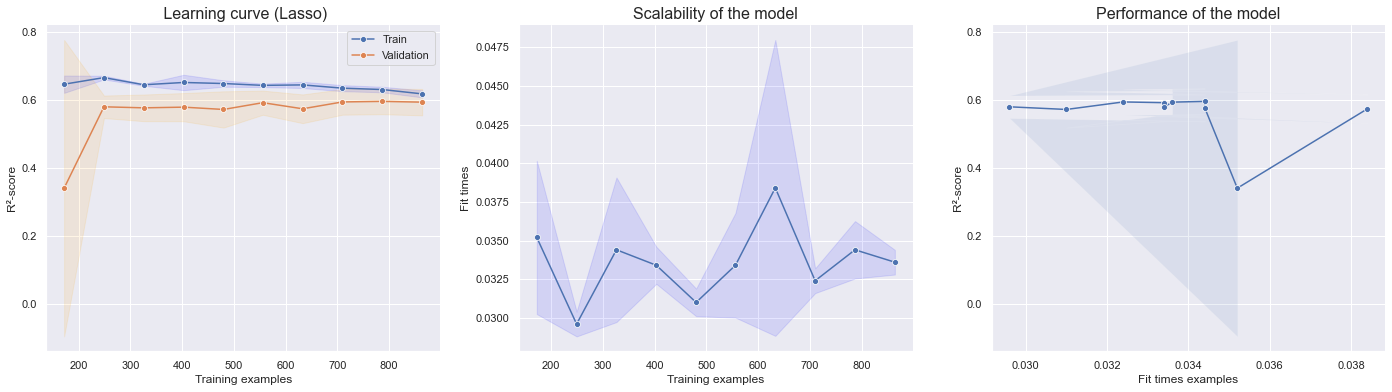

In [114]:
plot_learning_curve(reg, "Lasso", X_train, y_train, cv=kfold)


### <font color= #00ADEF>6.3.3 Lasso predictions validations</font>

<div class="alert alert-block alert-info">
    To plot the <b>predictions validations</b>, we are going to use the <b>best  parameters</b> to analyze the model after <b>fitting</b> and <b>predicting</b> values</b>
</div>

In [115]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

reg = make_pipeline(preprocessor, Lasso(alpha=search.best_params_.get("lasso__alpha"), 
                                        copy_X=search.best_params_.get("lasso__copy_X"), 
                                        fit_intercept=search.best_params_.get("lasso__fit_intercept"))
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

<div class="alert alert-block alert-info">
    Plotting <b>the Cross-Validated Predictions</b> based on the best parameters for <b>training data</b>
</div>

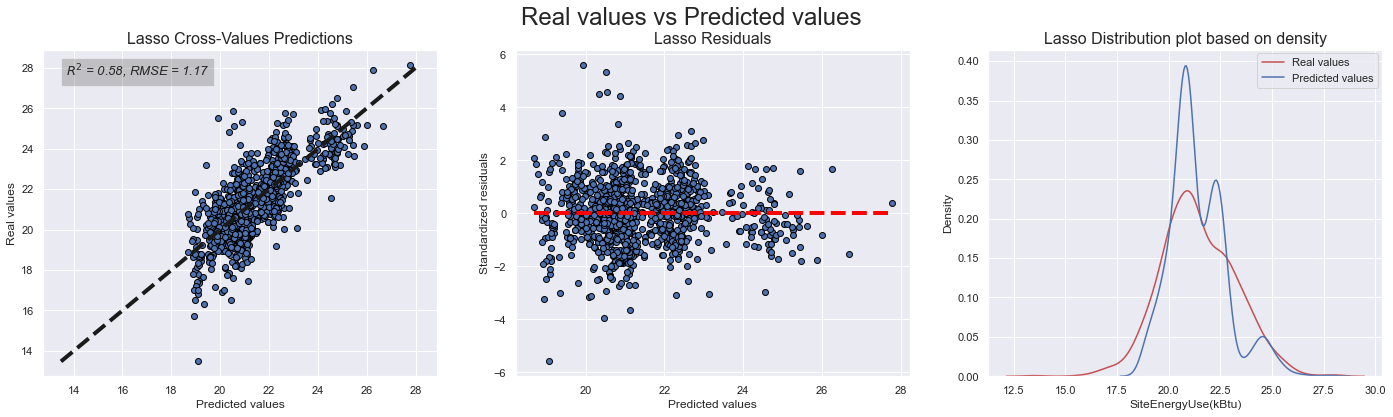

In [116]:
# Making the prediction using the testing data
plot_cross_val_predi(reg, "Lasso", "SiteEnergyUse(kBtu)", X_train, y_train, cv=kfold)

### <font color= #00ADEF>6.3.4 Lasso Features Importance</font>

<div class="alert alert-block alert-info">
    To plot the <b>Features Importance</b>, we are going to use the <b>best  parameters</b> to analyze the model after <b>fitting</b> values</b>
</div>

In [117]:
reg = make_pipeline(preprocessor, Lasso(alpha=search.best_params_.get("lasso__alpha"), 
                                        copy_X=search.best_params_.get("lasso__copy_X"), 
                                        fit_intercept=search.best_params_.get("lasso__fit_intercept"))
                   )

reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function boolean_transformation at 0x000002A42C107AC0>))]),
                                                  ['NaturalGas', 'SteamUse',
                                                   'OtherFuelUse']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Neighborhoo...
                                                                   KNNImputer()),
                  

<div class="alert alert-block alert-info">
    Plotting <b>the Features Importance</b> based on the best parameters
</div>

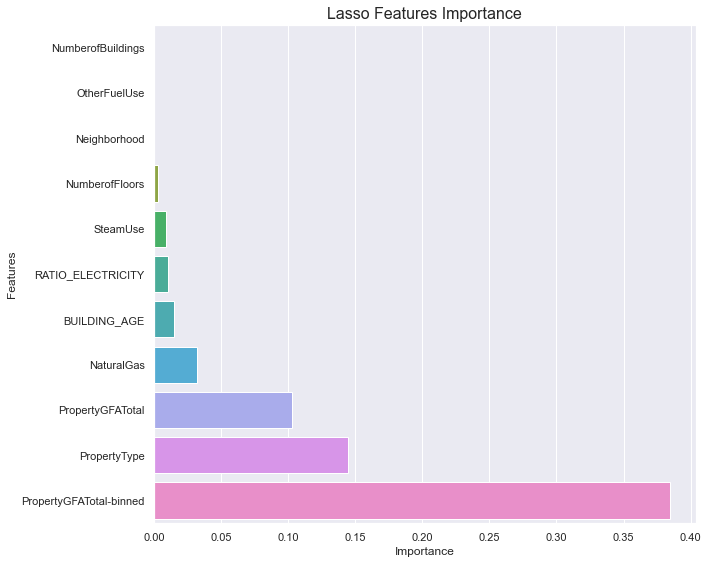

In [118]:
plot_features_importance(reg, "Lasso", X_train, y_train, scoring="r2")


### <font color= #00ADEF>6.3.5 Predictions metrics</font>

<div class="alert alert-block alert-info">
    We are going to make the prediction with the testing set to compare the result with the model in default mode
</div>

In [119]:
start_time_model = timeit.default_timer()

reg = make_pipeline(preprocessor, Lasso(alpha=search.best_params_.get("lasso__alpha"), 
                                        copy_X=search.best_params_.get("lasso__copy_X"), 
                                        fit_intercept=search.best_params_.get("lasso__fit_intercept"))
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

# Calculating R2 Coefficient of determination for each model (Best possible score is 1.0, lower values are worse.)
R2SCORE = round((1 - r2_score(y_test, y_pred)), 5)
    
# Calculating the Mean absolute error (The best value is 0.0)
MAE = round(mean_absolute_error(y_test, y_pred), 3)
    
# Calculating Root Mean Square Error for each model (The best value is 0.0)
RMSE = round(mean_squared_error(y_test, y_pred, squared=False), 3)

<div class="alert alert-block alert-info">
    Adding the prediction to compare at the end
</div>

In [120]:
# Concatenating predictions to compare against y_test_transformed
df_temp = pd.DataFrame({
    "Model" : "Lasso",
    "y_pred" : y_pred
})

In [121]:
# Concatenating predictions to compare against y_test_transformed
df_y_pred_hyperparameters = pd.concat([df_y_pred_hyperparameters, df_temp])

<div class="alert alert-block alert-info">
    Verifying the prediction model into the dataset
</div>

In [122]:
df_y_pred_hyperparameters["Model"].unique()

array(['Original', 'LinearRegression', 'KNeighbors', 'Lasso'],
      dtype=object)

<div class="alert alert-block alert-info">
    Adding metrics to compare at the end
</div>

In [123]:
df_temp = pd.DataFrame({
    "Model" : ["Lasso"],
    "1 - " + "R2".translate(SUP) : [R2SCORE], 
    "MAE" : [MAE],    
    "RMSE" : [RMSE],
    "Duration" : [end_time_model]
})

In [124]:
# Concatenating metrics to compare against model with default parameters
df_models_hyperparameters = pd.concat([df_models_hyperparameters, df_temp])

In [125]:
df_models_hyperparameters

,Model,1 - R²,MAE,RMSE,Duration
0,LinearRegression,0.96092,1.090,1.801,0.043
0,KNeighbors,0.40705,0.835,1.172,0.448
0,Lasso,0.47047,0.927,1.260,0.051


<div class="alert alert-block alert-success">
    Compared to the model with default parameters, we can see how the result improved for Lasso
</div>


## <font color= #00ADEF>6.4. SVR optimization</font>

<div class="alert alert-block alert-info">
    Initializing model
</div>

In [126]:
svr = SVR()

<div class="alert alert-block alert-info">
    Data preprocessing based on the pipelines and the regressors setup
</div>

In [127]:
reg = make_pipeline(preprocessor, svr)

<div class="alert alert-block alert-info">
    Identifying the names of each parameter
</div>

In [128]:
sorted(reg.get_params().keys())

['columntransformer',
 'columntransformer__n_jobs',
 'columntransformer__pipeline-1',
 'columntransformer__pipeline-1__functiontransformer',
 'columntransformer__pipeline-1__functiontransformer__accept_sparse',
 'columntransformer__pipeline-1__functiontransformer__check_inverse',
 'columntransformer__pipeline-1__functiontransformer__func',
 'columntransformer__pipeline-1__functiontransformer__inv_kw_args',
 'columntransformer__pipeline-1__functiontransformer__inverse_func',
 'columntransformer__pipeline-1__functiontransformer__kw_args',
 'columntransformer__pipeline-1__functiontransformer__validate',
 'columntransformer__pipeline-1__memory',
 'columntransformer__pipeline-1__steps',
 'columntransformer__pipeline-1__verbose',
 'columntransformer__pipeline-2',
 'columntransformer__pipeline-2__memory',
 'columntransformer__pipeline-2__onehotencoder',
 'columntransformer__pipeline-2__onehotencoder__categories',
 'columntransformer__pipeline-2__onehotencoder__drop',
 'columntransformer__pipe

<div class="alert alert-block alert-info">
    Parameters settings
</div>

In [129]:
param_grid = {
    "svr__kernel" : ["linear", "poly", "rbf"], # Specifies the kernel type to be used in the algorithm.
    "svr__gamma" : ["auto", "scale"], # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "svr__C" : [1.5, 10], # Regularization parameter. The strength of the regularization is inversely proportional to C.
    "svr__epsilon" : [0.1, 0.2, 0.5, 0.3] # It specifies the epsilon-tube within which no penalty is associated 
                                       # in the training loss function with points predicted within a distance epsilon from the actual value.
}

<div class="alert alert-block alert-info">
    Executing the model
</div>

In [130]:
# K-Folds cross-validator
kfold = KFold(n_splits=5, shuffle=False, random_state=None)

search = GridSearchCV(reg, param_grid, n_jobs=-2, cv=kfold, scoring=SCORINGS, refit="R2", return_train_score=True)

search.fit(X_train, y_train)

# Transforming the result to dataframe format
df_results = pd.DataFrame(search.cv_results_)

# Get the results
print("Metrics based on the best R2".translate(SUP))
print("- 1 - " + "R2:".translate(SUP), round((1 - search.best_score_), 3))
print("- MAE:", round(abs(df_results.iloc[search.best_index_]["mean_test_MAE"]), 3))
print("- RMSE:", round(math.sqrt(abs(df_results.iloc[search.best_index_]["mean_test_MSE"])), 3))
print("- Duration:", round(df_results.iloc[search.best_index_]["mean_score_time"], 3))
print("- Parameters:", search.best_params_)

Metrics based on the best R²
- 1 - R²: 0.319
- MAE: 0.757
- RMSE: 1.01
- Duration: 0.064
- Parameters: {'svr__C': 10, 'svr__epsilon': 0.2, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}


<div class="alert alert-block alert-info">
    Adding metrics to compare at the end
</div>

In [131]:
df_temp = pd.DataFrame({
    "Model" : ["SVR"],
    "1 - " + "R2".translate(SUP) : round((1 - search.best_score_), 3), 
    "MAE" : round(abs(df_results.iloc[search.best_index_]["mean_test_MAE"]), 3),    
    "RMSE" : round(math.sqrt(abs(df_results.iloc[search.best_index_]["mean_test_MSE"])), 3),
    "Duration" : round(df_results.iloc[search.best_index_]["mean_score_time"], 3)
})

In [132]:
# Concatenating metrics to compare against model with default parameters
df_models_metrics_gsc = pd.concat([df_models_metrics_gsc, df_temp])

In [133]:
df_models_metrics_gsc

,Model,1 - R²,MAE,RMSE,Duration
0,LinearRegression,0.418,0.891,1.164,0.027
0,KNeighbors,0.362,0.812,1.081,0.047
0,Lasso,0.407,0.885,1.143,0.023
0,SVR,0.319,0.757,1.010,0.064


<div class="alert alert-block alert-success">
    We got the <b>best parameters</b> so, we are going to <b>analyze</b> them more in details 
</div>


### <font color= #00ADEF>6.4.1 SVR Validation curve</font>

<div class="alert alert-block alert-info">
    To plot the <b>Validation curve</b>, we are going to use a <b>range of alpha</b> to analyze the model through them
</div>

In [134]:
kfold = KFold(n_splits=5, shuffle=False, random_state=None)

gamma = np.arange(0.01, 1, 0.05).tolist()

reg = make_pipeline(preprocessor, SVR(C=search.best_params_.get("svr__C"),
                                      epsilon=search.best_params_.get("svr__epsilon"), 
                                      kernel=search.best_params_.get("svr__kernel"))
                   )

<div class="alert alert-block alert-info">
    Plotting <b>the validacion curve</b> based on the best parameters
</div>

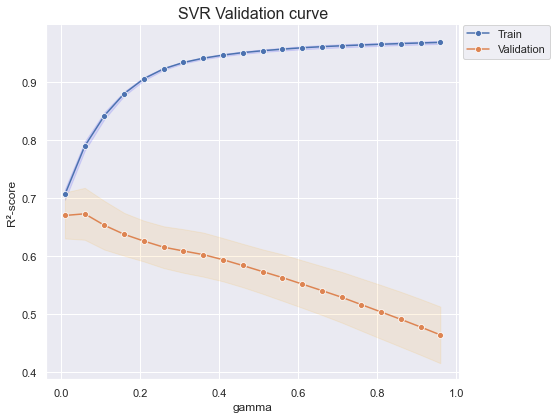

In [135]:
plot_validation_curve_by(reg, "SVR", "R2SCORE", X_train, y_train, param_name="svr__gamma", param_range=gamma, param_name_short="gamma", cv=kfold)

   <p><b>Observations / Conclusions</b></p>    
    <p>As you go through <b>gamma</b> you can see how the bias increase between train and validation set. We can say that the model is <b>Overfitting</b> 


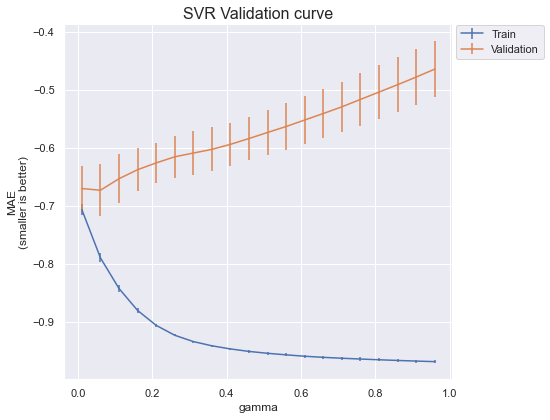

In [136]:
plot_validation_curve_by(reg, "SVR", "MAE", X_train, y_train, param_name="svr__gamma", param_range=gamma, param_name_short="gamma", cv=kfold)

### <font color= #00ADEF>6.4.2 SVR Learning curve</font>

<div class="alert alert-block alert-info">
    To plot the <b>Learning curve</b>, we are going to use the <b>best  parameters</b> to analyze the model
</div>

In [137]:
kfold = KFold(n_splits=5, shuffle=False, random_state=None)

reg = make_pipeline(preprocessor, SVR(C=search.best_params_.get("svr__C"),
                                      epsilon=search.best_params_.get("svr__epsilon"), 
                                      kernel=search.best_params_.get("svr__kernel"), 
                                      gamma=search.best_params_.get("svr__gamma"))
                   )

<div class="alert alert-block alert-info">
    Plotting <b>the learning curve</b> based on the best parameters
</div>

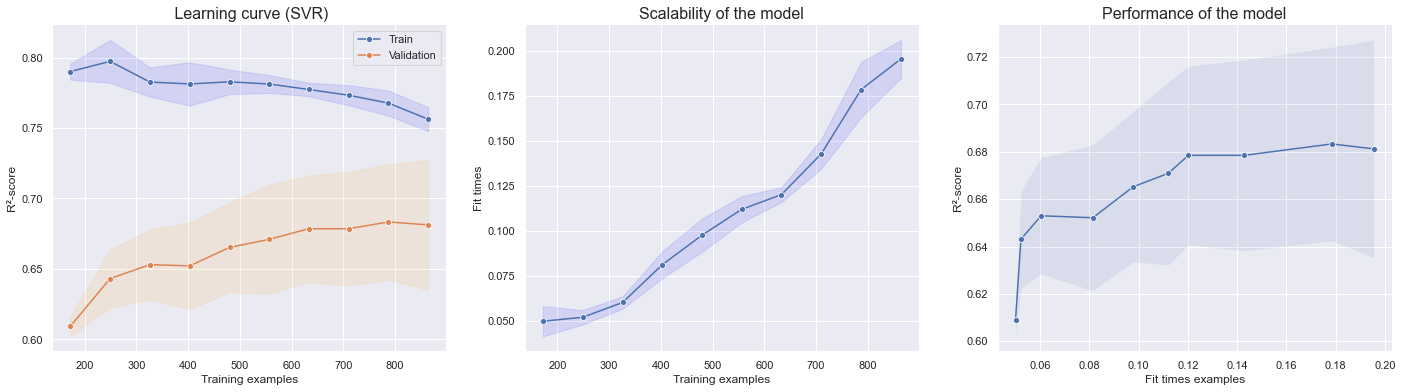

In [138]:
plot_learning_curve(reg, "SVR", X_train, y_train, cv=kfold)

### <font color= #00ADEF>6.4.3 SVR predictions validations</font>

<div class="alert alert-block alert-info">
    To plot the <b>predictions validations</b>, we are going to use the <b>best  parameters</b> to analyze the model after <b>fitting</b> and <b>predicting</b> values</b>
</div>

In [139]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

reg = make_pipeline(preprocessor, SVR(C=search.best_params_.get("svr__C"),
                                      epsilon=search.best_params_.get("svr__epsilon"), 
                                      kernel=search.best_params_.get("svr__kernel"), 
                                      gamma=search.best_params_.get("svr__gamma"))
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

<div class="alert alert-block alert-info">
    Plotting <b>the Cross-Validated Predictions</b> based on the best parameters for <b>training data</b>
</div>

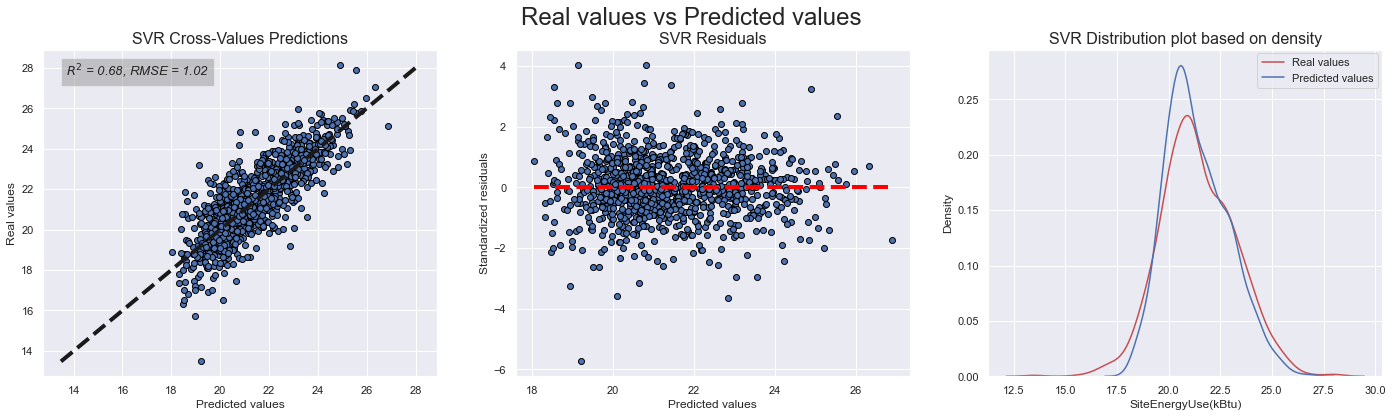

In [140]:
# Making the prediction using the testing data
plot_cross_val_predi(reg, "SVR", "SiteEnergyUse(kBtu)", X_train, y_train, cv=kfold)

### <font color= #00ADEF>6.4.4 SVR Features Importance</font>

<div class="alert alert-block alert-info">
    To plot the <b>Features Importance</b>, we are going to use the <b>best  parameters</b> to analyze the model after <b>fitting</b> values</b>
</div>

In [141]:
reg = make_pipeline(preprocessor, SVR(C=search.best_params_.get("svr__C"),
                                      epsilon=search.best_params_.get("svr__epsilon"), 
                                      kernel=search.best_params_.get("svr__kernel"), 
                                      gamma=search.best_params_.get("svr__gamma"))
                   )

reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function boolean_transformation at 0x000002A42C107AC0>))]),
                                                  ['NaturalGas', 'SteamUse',
                                                   'OtherFuelUse']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Neighborhoo...
                                                                  ('functiontransformer',
          

<div class="alert alert-block alert-info">
    Plotting <b>the Features Importance</b> based on the best parameters
</div>

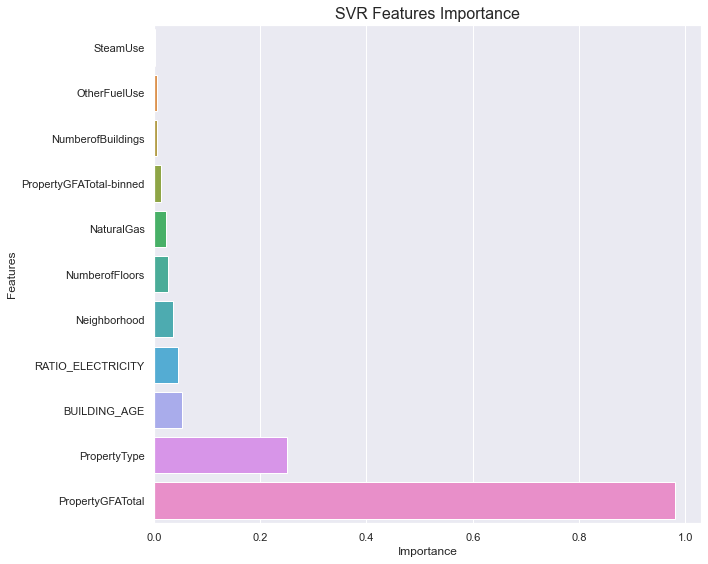

In [142]:
plot_features_importance(reg, "SVR", X_train, y_train, scoring="r2")


### <font color= #00ADEF>6.4.5 Predictions metrics</font>

<div class="alert alert-block alert-info">
    We are going to make the prediction with the testing set to compare the result with the model in default mode
</div>

In [143]:
start_time_model = timeit.default_timer()

reg = make_pipeline(preprocessor, SVR(C=search.best_params_.get("svr__C"),
                                      epsilon=search.best_params_.get("svr__epsilon"), 
                                      kernel=search.best_params_.get("svr__kernel"), 
                                      gamma=search.best_params_.get("svr__gamma"))
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

# Calculating R2 Coefficient of determination for each model (Best possible score is 1.0, lower values are worse.)
R2SCORE = round((1 - r2_score(y_test, y_pred)), 5)
    
# Calculating the Mean absolute error (The best value is 0.0)
MAE = round(mean_absolute_error(y_test, y_pred), 3)
    
# Calculating Root Mean Square Error for each model (The best value is 0.0)
RMSE = round(mean_squared_error(y_test, y_pred, squared=False), 3)

<div class="alert alert-block alert-info">
    Adding the prediction to compare at the end
</div>

In [144]:
# Concatenating predictions to compare against y_test_transformed
df_temp = pd.DataFrame({
    "Model" : "SVR",
    "y_pred" : y_pred
})

In [145]:
# Concatenating predictions to compare against y_test_transformed
df_y_pred_hyperparameters = pd.concat([df_y_pred_hyperparameters, df_temp])

<div class="alert alert-block alert-info">
    Verifying the prediction model into the dataset
</div>

In [146]:
df_y_pred_hyperparameters["Model"].unique()

array(['Original', 'LinearRegression', 'KNeighbors', 'Lasso', 'SVR'],
      dtype=object)

<div class="alert alert-block alert-info">
    Adding metrics to compare at the end
</div>

In [147]:
df_temp = pd.DataFrame({
    "Model" : ["SVR"],
    "1 - " + "R2".translate(SUP) : [R2SCORE], 
    "MAE" : [MAE],    
    "RMSE" : [RMSE],
    "Duration" : [end_time_model]
})

In [148]:
# Concatenating metrics to compare against model with default parameters
df_models_hyperparameters = pd.concat([df_models_hyperparameters, df_temp])

In [149]:
df_models_hyperparameters

,Model,1 - R²,MAE,RMSE,Duration
0,LinearRegression,0.96092,1.090,1.801,0.043
0,KNeighbors,0.40705,0.835,1.172,0.448
0,Lasso,0.47047,0.927,1.260,0.051
0,SVR,0.34677,0.772,1.082,0.278


<div class="alert alert-block alert-success">
    Compared to the model with default parameters, we can see how the result improved a little for SVR
</div>


## <font color= #00ADEF>6.5. Random Forest optimizatio</font>

<div class="alert alert-block alert-info">
    Initializing model
</div>

In [150]:
regr = RandomForestRegressor()

<div class="alert alert-block alert-info">
    Data preprocessing based on the pipelines and the regressors setup
</div>

In [151]:
reg = make_pipeline(preprocessor, regr)

<div class="alert alert-block alert-info">
    Identifying the names of each parameter
</div>

In [152]:
sorted(reg.get_params().keys())

['columntransformer',
 'columntransformer__n_jobs',
 'columntransformer__pipeline-1',
 'columntransformer__pipeline-1__functiontransformer',
 'columntransformer__pipeline-1__functiontransformer__accept_sparse',
 'columntransformer__pipeline-1__functiontransformer__check_inverse',
 'columntransformer__pipeline-1__functiontransformer__func',
 'columntransformer__pipeline-1__functiontransformer__inv_kw_args',
 'columntransformer__pipeline-1__functiontransformer__inverse_func',
 'columntransformer__pipeline-1__functiontransformer__kw_args',
 'columntransformer__pipeline-1__functiontransformer__validate',
 'columntransformer__pipeline-1__memory',
 'columntransformer__pipeline-1__steps',
 'columntransformer__pipeline-1__verbose',
 'columntransformer__pipeline-2',
 'columntransformer__pipeline-2__memory',
 'columntransformer__pipeline-2__onehotencoder',
 'columntransformer__pipeline-2__onehotencoder__categories',
 'columntransformer__pipeline-2__onehotencoder__drop',
 'columntransformer__pipe

<div class="alert alert-block alert-info">
    Parameters settings
</div>

<div class="alert alert-block alert-info">
    Executing the model
</div>

In [153]:
param_grid = {
    "randomforestregressor__max_depth" : [20, 30, 40, 50, 60, 70, 80], # The maximum depth of the tree.
    "randomforestregressor__max_features" : ["auto", "sqrt"], # The number of features to consider when looking for the best split.
    "randomforestregressor__min_samples_leaf" : [1, 2, 3, 4, 5], # The minimum number of samples required to be at a leaf node.
    "randomforestregressor__min_samples_split" : [2, 4, 6, 8, 10, 12], # The minimum number of samples required to split an internal node.
    "randomforestregressor__n_estimators" : [30, 40, 50, 80, 100, 120, 140] # The number of trees in the forest.
}

In [154]:
## K-Folds cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

start_time_model = timeit.default_timer()

# search = GridSearchCV(reg, param_grid, n_jobs=-1, cv=kfold, scoring=SCORINGS, refit="R2", return_train_score=True)
search = GridSearchCV(reg, param_grid, n_jobs=-2, cv=kfold, scoring=SCORINGS, refit="R2", return_train_score=True)

search.fit(X_train, y_train)

# Transforming the result to dataframe format
df_results = pd.DataFrame(search.cv_results_)

# Get the results
print("Metrics based on the best R2".translate(SUP))
print("- 1 - " + "R2:".translate(SUP), round((1 - search.best_score_), 3))
print("- MAE:", round(abs(df_results.iloc[search.best_index_]["mean_test_MAE"]), 3))
print("- RMSE:", round(math.sqrt(abs(df_results.iloc[search.best_index_]["mean_test_MSE"])), 3))
print("- Duration:", round(df_results.iloc[search.best_index_]["mean_score_time"], 3))
print("- Parameters:", search.best_params_)

Metrics based on the best R²
- 1 - R²: 0.32
- MAE: 0.777
- RMSE: 1.014
- Duration: 0.043
- Parameters: {'randomforestregressor__max_depth': 20, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__n_estimators': 120}


<div class="alert alert-block alert-info">
    Adding metrics to compare at the end
</div>

In [155]:
df_temp = pd.DataFrame({
    "Model" : ["Random Forest"],
    "1 - " + "R2".translate(SUP) : round((1 - search.best_score_), 3), 
    "MAE" : round(abs(df_results.iloc[search.best_index_]["mean_test_MAE"]), 3),    
    "RMSE" : round(math.sqrt(abs(df_results.iloc[search.best_index_]["mean_test_MSE"])), 3),
    "Duration" : round(df_results.iloc[search.best_index_]["mean_score_time"], 3)
})

In [156]:
# Concatenating metrics to compare against model with default parameters
df_models_metrics_gsc = pd.concat([df_models_metrics_gsc, df_temp])

In [157]:
df_models_metrics_gsc

,Model,1 - R²,MAE,RMSE,Duration
0,LinearRegression,0.418,0.891,1.164,0.027
0,KNeighbors,0.362,0.812,1.081,0.047
0,Lasso,0.407,0.885,1.143,0.023
0,SVR,0.319,0.757,1.010,0.064
0,Random Forest,0.320,0.777,1.014,0.043


<div class="alert alert-block alert-info">
    We got the <b>best parameters</b> so, we are going to <b>analyze</b> them more in details 
</div>


### <font color= #00ADEF>6.5.1 Random Forest Validation curve</font>

<div class="alert alert-block alert-info">
    To plot the <b>Validation curve</b>, we are going to use a <b>range of neighbors</b> to analyze the model through them
</div>

In [158]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

n_estimators = np.unique(np.logspace(0, 1.8, num=search.best_params_.get("randomforestregressor__n_estimators")).astype(int))

reg = make_pipeline(preprocessor, RandomForestRegressor(max_depth=search.best_params_.get("randomforestregressor__max_depth"), 
                                                        max_features=search.best_params_.get("randomforestregressor__max_features"),
                                                        min_samples_leaf=search.best_params_.get("randomforestregressor__min_samples_leaf"), 
                                                        min_samples_split=search.best_params_.get("randomforestregressor__min_samples_split"))
                   )

<div class="alert alert-block alert-info">
    Plotting <b>the validacion curve</b> based on the best parameters
</div>

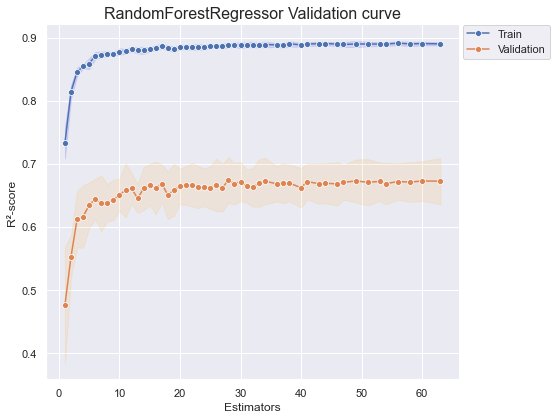

In [159]:
plot_validation_curve_by(reg, "RandomForestRegressor", "R2SCORE", X_train, y_train, param_name="randomforestregressor__n_estimators", param_range=n_estimators, param_name_short="Estimators", cv=kfold)

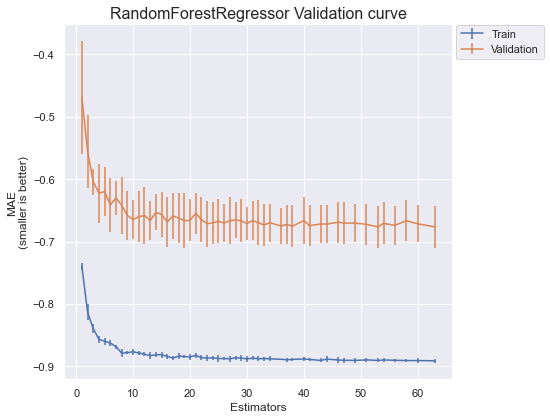

In [160]:
plot_validation_curve_by(reg, "RandomForestRegressor", "MAE", X_train, y_train, param_name="randomforestregressor__n_estimators", param_range=n_estimators, param_name_short="Estimators", cv=kfold)

### <font color= #00ADEF>6.5.2 Random Forest Learning curve</font>

<div class="alert alert-block alert-info">
    To plot the <b>Learning curve</b>, we are going to use the <b>best  parameters</b> to analyze the model
</div>

In [161]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

reg = make_pipeline(preprocessor, RandomForestRegressor(max_depth=search.best_params_.get("randomforestregressor__max_depth"), 
                                                        max_features=search.best_params_.get("randomforestregressor__max_features"),
                                                        min_samples_leaf=search.best_params_.get("randomforestregressor__min_samples_leaf"), 
                                                        min_samples_split=search.best_params_.get("randomforestregressor__min_samples_split"),
                                                        n_estimators=search.best_params_.get("randomforestregressor__n_estimators"))
                   )

<div class="alert alert-block alert-info">
    Plotting <b>the learning curve</b> based on the best parameters
</div>

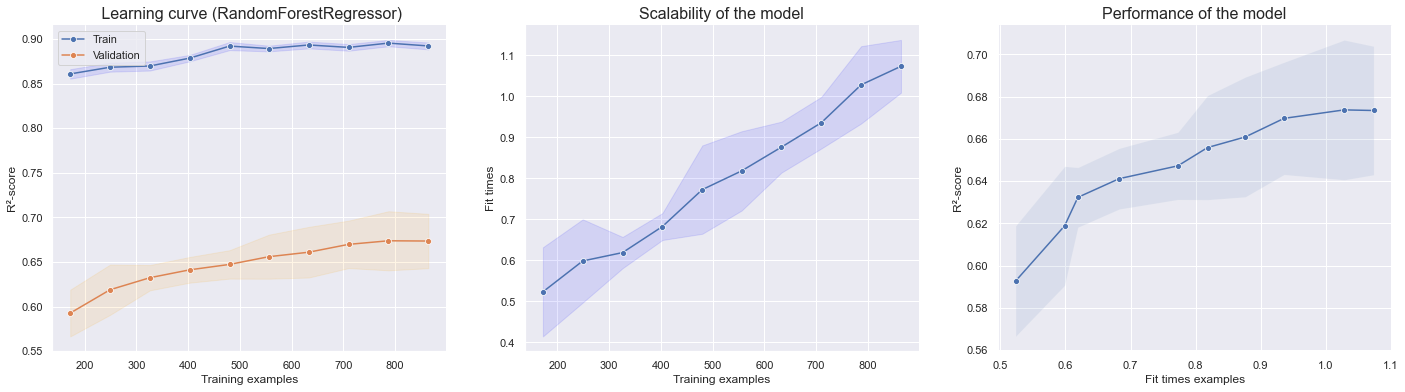

In [162]:
plot_learning_curve(reg, "RandomForestRegressor", X_train, y_train, cv=kfold)


### <font color= #00ADEF>6.5.3 Random Forest predictions validations</font>

<div class="alert alert-block alert-info">
    To plot the <b>predictions validations</b>, we are going to use the <b>best  parameters</b> to analyze the model after <b>fitting</b> and <b>predicting</b> values</b>
</div>

In [163]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

reg = make_pipeline(preprocessor, RandomForestRegressor(max_depth=search.best_params_.get("randomforestregressor__max_depth"), 
                                                        max_features=search.best_params_.get("randomforestregressor__max_features"),
                                                        min_samples_leaf=search.best_params_.get("randomforestregressor__min_samples_leaf"), 
                                                        min_samples_split=search.best_params_.get("randomforestregressor__min_samples_split"),
                                                        n_estimators=search.best_params_.get("randomforestregressor__n_estimators"))
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

<div class="alert alert-block alert-info">
    Plotting <b>the Cross-Validated Predictions</b> based on the best parameters for <b>training data</b>
</div>

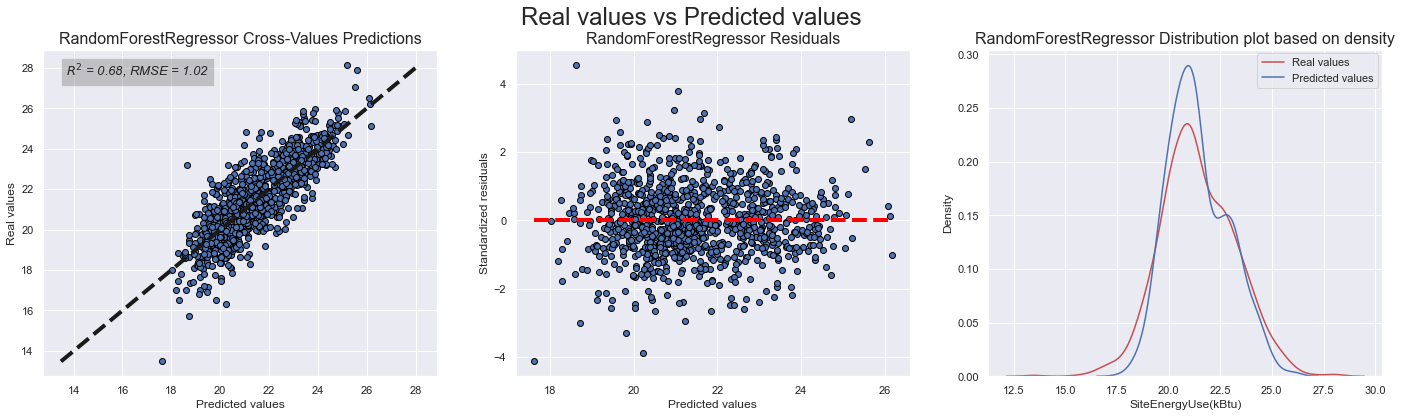

In [164]:
# Making the prediction using the testing data
plot_cross_val_predi(reg, "RandomForestRegressor", "SiteEnergyUse(kBtu)", X_train, y_train, cv=kfold)


### <font color= #00ADEF>6.5.4 Random Forest  Features Importance</font>

<div class="alert alert-block alert-info">
    To plot the <b>Features Importance</b>, we are going to use the <b>best  parameters</b> to analyze the model after <b>fitting</b> values</b>
</div>

In [165]:
reg = make_pipeline(preprocessor, RandomForestRegressor(max_depth=search.best_params_.get("randomforestregressor__max_depth"), 
                                                        max_features=search.best_params_.get("randomforestregressor__max_features"),
                                                        min_samples_leaf=search.best_params_.get("randomforestregressor__min_samples_leaf"), 
                                                        min_samples_split=search.best_params_.get("randomforestregressor__min_samples_split"),
                                                        n_estimators=search.best_params_.get("randomforestregressor__n_estimators"))
                   )

reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function boolean_transformation at 0x000002A42C107AC0>))]),
                                                  ['NaturalGas', 'SteamUse',
                                                   'OtherFuelUse']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Neighborhoo...
                                                                   FunctionTransformer(func=<functio

<div class="alert alert-block alert-info">
    Plotting <b>the Features Importance</b> based on the best parameters
</div>

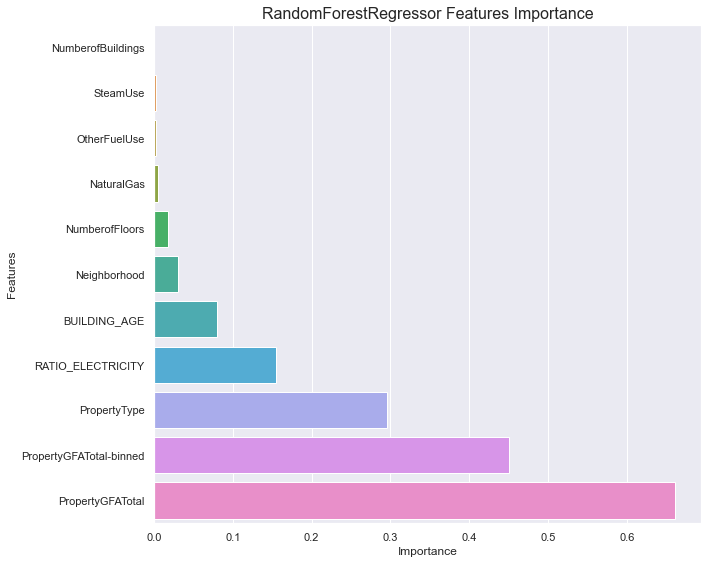

In [166]:
plot_features_importance(reg, "RandomForestRegressor", X_train, y_train, scoring="r2")

### <font color= #00ADEF>6.5.5 Predictions metrics</font>

In [167]:
reg = make_pipeline(preprocessor, RandomForestRegressor(max_depth=search.best_params_.get("randomforestregressor__max_depth"), 
                                                        max_features=search.best_params_.get("randomforestregressor__max_features"),
                                                        min_samples_leaf=search.best_params_.get("randomforestregressor__min_samples_leaf"), 
                                                        min_samples_split=search.best_params_.get("randomforestregressor__min_samples_split"),
                                                        n_estimators=search.best_params_.get("randomforestregressor__n_estimators"))
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

<div class="alert alert-block alert-info">
    Adding the prediction to compare at the end
</div>

In [168]:
# Concatenating predictions to compare against y_test_transformed
df_temp = pd.DataFrame({
    "Model" : "Random Forest",
    "y_pred" : y_pred
})

In [169]:
# Concatenating predictions to compare against y_test_transformed
df_y_pred_hyperparameters = pd.concat([df_y_pred_hyperparameters, df_temp])

<div class="alert alert-block alert-info">
    Verifying the prediction model into the dataset
</div>

In [170]:
df_y_pred_hyperparameters["Model"].unique()

array(['Original', 'LinearRegression', 'KNeighbors', 'Lasso', 'SVR',
       'Random Forest'], dtype=object)

<div class="alert alert-block alert-info">
    Adding metrics to compare at the end
</div>

In [171]:
df_temp = pd.DataFrame({
    "Model" : ["Random Forest"],
    "1 - " + "R2".translate(SUP) : [R2SCORE], 
    "MAE" : [MAE],    
    "RMSE" : [RMSE],
    "Duration" : [end_time_model]
})

In [172]:
# Concatenating metrics to compare against model with default parameters
df_models_hyperparameters = pd.concat([df_models_hyperparameters, df_temp])

In [173]:
df_models_hyperparameters

,Model,1 - R²,MAE,RMSE,Duration
0,LinearRegression,0.96092,1.090,1.801,0.043
0,KNeighbors,0.40705,0.835,1.172,0.448
0,Lasso,0.47047,0.927,1.260,0.051
0,SVR,0.34677,0.772,1.082,0.278
0,Random Forest,0.34677,0.772,1.082,0.278


<div class="alert alert-block alert-success">
    Compared to the model with default parameters, we can see that the result is similar
</div>


## <font color= #00ADEF>6.6. Gradient Boosting optimizations</font>

<div class="alert alert-block alert-info">
    Initializing model
</div>

In [174]:
gbr = GradientBoostingRegressor()

<div class="alert alert-block alert-info">
    Data preprocessing based on the pipelines and the regressors setup
</div>

In [175]:
reg = make_pipeline(preprocessor, gbr)

<div class="alert alert-block alert-info">
    Identifying the names of each parameter
</div>

In [176]:
sorted(reg.get_params().keys())

['columntransformer',
 'columntransformer__n_jobs',
 'columntransformer__pipeline-1',
 'columntransformer__pipeline-1__functiontransformer',
 'columntransformer__pipeline-1__functiontransformer__accept_sparse',
 'columntransformer__pipeline-1__functiontransformer__check_inverse',
 'columntransformer__pipeline-1__functiontransformer__func',
 'columntransformer__pipeline-1__functiontransformer__inv_kw_args',
 'columntransformer__pipeline-1__functiontransformer__inverse_func',
 'columntransformer__pipeline-1__functiontransformer__kw_args',
 'columntransformer__pipeline-1__functiontransformer__validate',
 'columntransformer__pipeline-1__memory',
 'columntransformer__pipeline-1__steps',
 'columntransformer__pipeline-1__verbose',
 'columntransformer__pipeline-2',
 'columntransformer__pipeline-2__memory',
 'columntransformer__pipeline-2__onehotencoder',
 'columntransformer__pipeline-2__onehotencoder__categories',
 'columntransformer__pipeline-2__onehotencoder__drop',
 'columntransformer__pipe

<div class="alert alert-block alert-info">
    Parameters settings
</div>

In [177]:
param_grid = {
    "gradientboostingregressor__learning_rate" : [0.01, 0.02, 0.03, 0.04], # Learning rate shrinks the contribution of each tree by learning_rate.
    "gradientboostingregressor__max_depth" : [2, 4, 6, 8], # Maximum depth of the individual regression estimators. 
    "gradientboostingregressor__n_estimators" : [100, 500, 1000, 1500], # The number of boosting stages to perform. 
    "gradientboostingregressor__subsample" : [0.9, 0.5, 0.2, 0.1] # The fraction of samples to be used for fitting the individual base learners.
}

<div class="alert alert-block alert-info">
    Executing the model
</div>

In [178]:
## K-Folds cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

search = GridSearchCV(reg, param_grid, n_jobs=-2, cv=kfold, scoring=SCORINGS, refit="R2", return_train_score=True)

search.fit(X_train, y_train)

# Transforming the result to dataframe format
df_results = pd.DataFrame(search.cv_results_)

# Get the results
print("Metrics based on the best R2".translate(SUP))
print("- 1 - " + "R2:".translate(SUP), round((1 - search.best_score_), 3))
print("- MAE:", round(abs(df_results.iloc[search.best_index_]["mean_test_MAE"]), 3))
print("- RMSE:", round(math.sqrt(abs(df_results.iloc[search.best_index_]["mean_test_MSE"])), 3))
print("- Duration:", round(df_results.iloc[search.best_index_]["mean_score_time"], 3))
print("- Parameters:", search.best_params_)

Metrics based on the best R²
- 1 - R²: 0.306
- MAE: 0.768
- RMSE: 0.991
- Duration: 0.024
- Parameters: {'gradientboostingregressor__learning_rate': 0.01, 'gradientboostingregressor__max_depth': 4, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__subsample': 0.5}


<div class="alert alert-block alert-info">
    Adding metrics to compare at the end
</div>

In [179]:
df_temp = pd.DataFrame({
    "Model" : ["Gradient Boosting"],
    "1 - " + "R2".translate(SUP) : round((1 - search.best_score_), 3), 
    "MAE" : round(abs(df_results.iloc[search.best_index_]["mean_test_MAE"]), 3),    
    "RMSE" : round(math.sqrt(abs(df_results.iloc[search.best_index_]["mean_test_MSE"])), 3),
    "Duration" : round(df_results.iloc[search.best_index_]["mean_score_time"], 3)
})

In [180]:
# Concatenating metrics to compare against model with default parameters
df_models_metrics_gsc = pd.concat([df_models_metrics_gsc, df_temp])

In [181]:
df_models_metrics_gsc

,Model,1 - R²,MAE,RMSE,Duration
0,LinearRegression,0.418,0.891,1.164,0.027
0,KNeighbors,0.362,0.812,1.081,0.047
0,Lasso,0.407,0.885,1.143,0.023
0,SVR,0.319,0.757,1.010,0.064
0,Random Forest,0.320,0.777,1.014,0.043
0,Gradient Boosting,0.306,0.768,0.991,0.024


In [182]:
df_models_metrics_gsc = pd.melt(df_models_metrics_gsc, id_vars="Model", var_name="Metric", value_name="Value")
df_models_metrics_gsc.head(3)

,Model,Metric,Value
0,LinearRegression,1 - R²,0.418
1,KNeighbors,1 - R²,0.362
2,Lasso,1 - R²,0.407


<div class="alert alert-block alert-success">
    We got the <b>best parameters</b> so, we are going to <b>analyze</b> them more in details 
</div>


### <font color= #00ADEF>6.6.1 Gradient Boosting Validation curve</font>

<div class="alert alert-block alert-info">
    To plot the <b>Validation curve</b>, we are going to use a <b>range of estimators</b> to analyze the model through them
</div>

In [183]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

n_estimators = np.arange(start=50, stop=650, step=50)

reg = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                                            max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                                            subsample=search.best_params_.get("gradientboostingregressor__subsample"))
                   )

<div class="alert alert-block alert-info">
    Plotting <b>the validacion curve</b> based on the best parameters
</div>

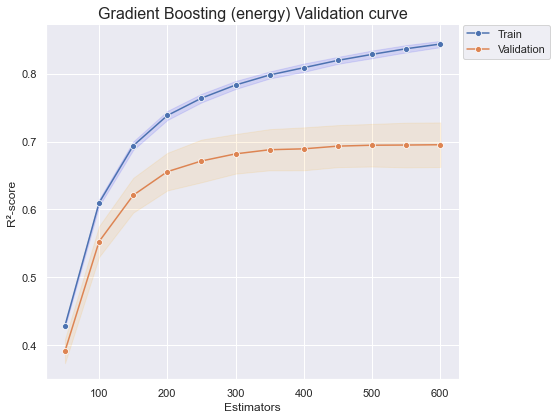

In [184]:
plot_validation_curve_by(reg, "Gradient Boosting (energy)", "R2SCORE", X_train, y_train, param_name="gradientboostingregressor__n_estimators", param_range=n_estimators, param_name_short="Estimators", cv=kfold)

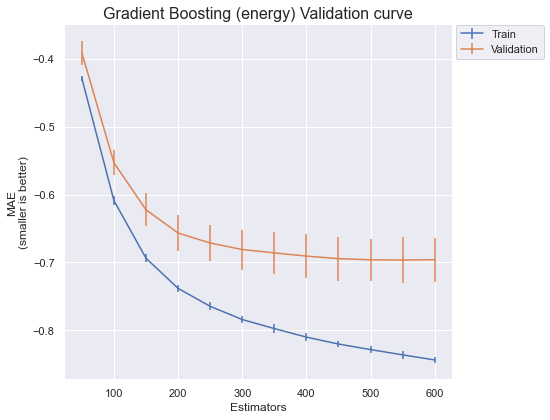

In [185]:
plot_validation_curve_by(reg, "Gradient Boosting (energy)", "MAE", X_train, y_train, param_name="gradientboostingregressor__n_estimators", param_range=n_estimators, param_name_short="Estimators", cv=kfold)



### <font color= #00ADEF>6.6.2 Gradient Boosting Learning curve</font>

<div class="alert alert-block alert-info">
    To plot the <b>Learning curve</b>, we are going to use the <b>best  parameters</b> to analyze the model
</div>

In [186]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

reg = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                                            max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                                            n_estimators=search.best_params_.get("gradientboostingregressor__n_estimators"),
                                                            subsample=search.best_params_.get("gradientboostingregressor__subsample"))
                   )

<div class="alert alert-block alert-info">
    Plotting <b>the learning curve</b> based on the best parameters
</div>

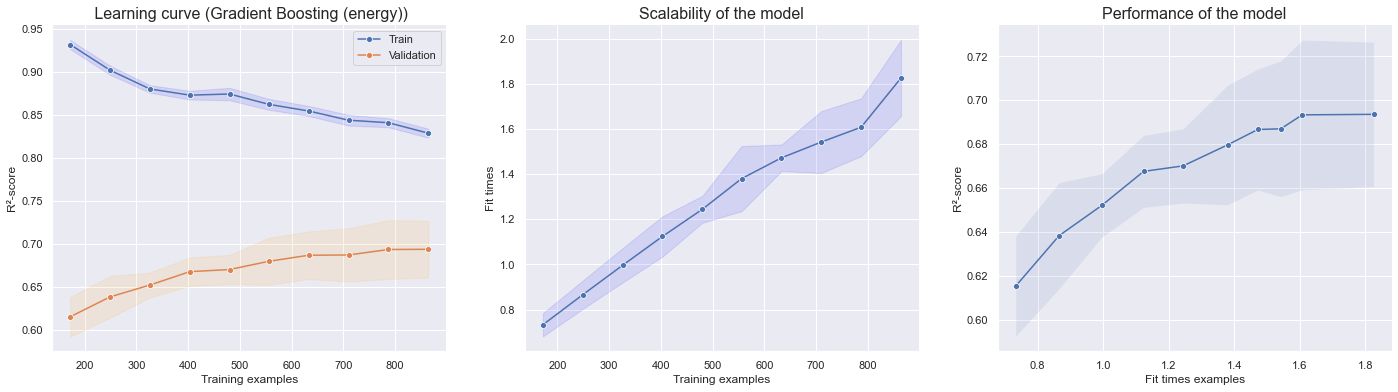

In [187]:
plot_learning_curve(reg, "Gradient Boosting (energy)", X_train, y_train, cv=kfold)


### <font color= #00ADEF>6.6.3 Gradient Boosting predictions validations</font>

<div class="alert alert-block alert-info">
    To plot the <b>predictions validations</b>, we are going to use the <b>best  parameters</b> to analyze the model after <b>fitting</b> and <b>predicting</b> values</b>
</div>

In [188]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

reg = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                                            max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                                            n_estimators=search.best_params_.get("gradientboostingregressor__n_estimators"),
                                                            subsample=search.best_params_.get("gradientboostingregressor__subsample"))
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

<div class="alert alert-block alert-info">
    Plotting <b>the Cross-Validated Predictions</b> based on the best parameters for <b>training data</b>
</div>

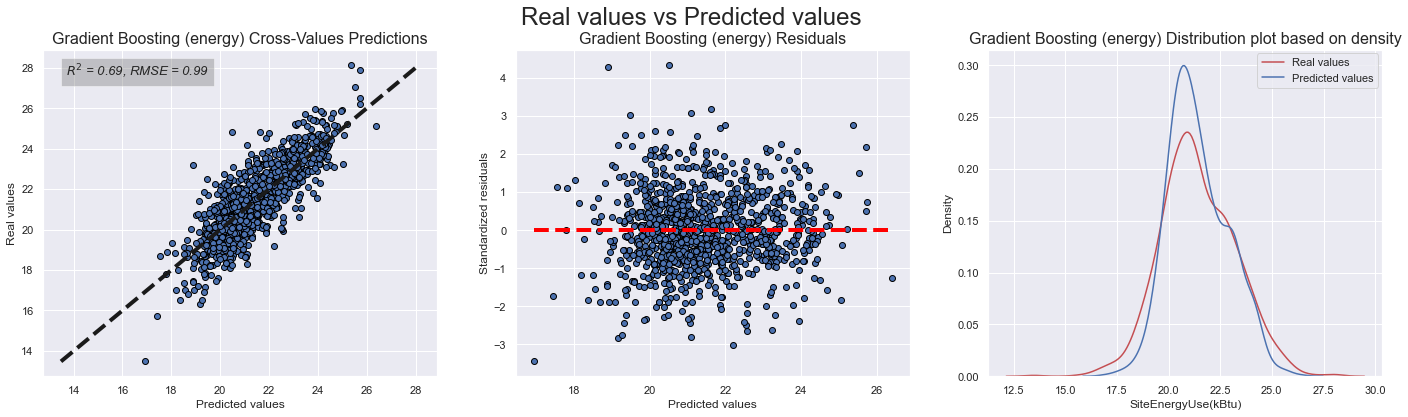

In [189]:
# Making the prediction using the testing data
plot_cross_val_predi(reg, "Gradient Boosting (energy)", "SiteEnergyUse(kBtu)", X_train, y_train, cv=kfold)

### <font color= #00ADEF>6.6.4 Gradient Boosting Features Importance</font>

<div class="alert alert-block alert-info">
    To plot the <b>Features Importance</b>, we are going to use the <b>best  parameters</b> to analyze the model after <b>fitting</b> values</b>
</div>

In [190]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

reg = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                                            max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                                            n_estimators=search.best_params_.get("gradientboostingregressor__n_estimators"),
                                                            subsample=search.best_params_.get("gradientboostingregressor__subsample"))
                   )

reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function boolean_transformation at 0x000002A42C107AC0>))]),
                                                  ['NaturalGas', 'SteamUse',
                                                   'OtherFuelUse']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Neighborhoo...
                                                                   FunctionTransformer(func=<functio

<div class="alert alert-block alert-info">
    Plotting <b>the Features Importance</b> based on the best parameters
</div>

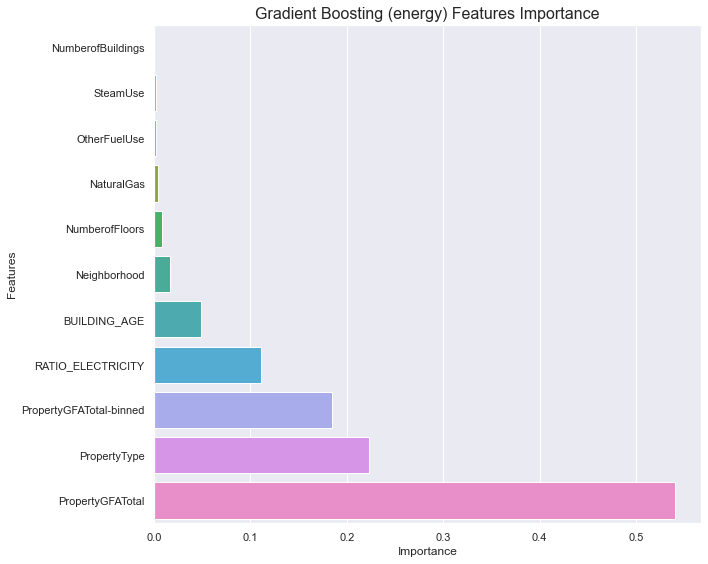

In [191]:
plot_features_importance(reg, "Gradient Boosting (energy)", X_train, y_train, scoring="r2")

### <font color= #00ADEF>6.6.5 Predictions metrics</font>

<div class="alert alert-block alert-info">
    We are going to make the prediction with the testing set to compare the result with the model in default mode
</div>

In [192]:
start_time_model = timeit.default_timer()

reg = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                                            max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                                            n_estimators=search.best_params_.get("gradientboostingregressor__n_estimators"),
                                                            subsample=search.best_params_.get("gradientboostingregressor__subsample"))
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

# Calculating R2 Coefficient of determination for each model (Best possible score is 1.0, lower values are worse.)
R2SCORE = round((1 - r2_score(y_test, y_pred)), 5)
    
# Calculating the Mean absolute error (The best value is 0.0)
MAE = round(mean_absolute_error(y_test, y_pred), 3)
    
# Calculating Root Mean Square Error for each model (The best value is 0.0)
RMSE = round(mean_squared_error(y_test, y_pred, squared=False), 3)

LIST_ENERGY = [R2SCORE, MAE, RMSE, end_time_model]

<div class="alert alert-block alert-info">
    Adding the prediction to compare at the end
</div>

In [193]:
# Concatenating predictions to compare against y_test_transformed
df_temp = pd.DataFrame({
    "Model" : "Gradient Boosting",
    "y_pred" : y_pred
})

In [194]:
# Concatenating predictions to compare against y_test_transformed
df_y_pred_hyperparameters = pd.concat([df_y_pred_hyperparameters, df_temp])

<div class="alert alert-block alert-info">
    Verifying the prediction model into the dataset
</div>

In [195]:
df_y_pred_hyperparameters["Model"].unique()

array(['Original', 'LinearRegression', 'KNeighbors', 'Lasso', 'SVR',
       'Random Forest', 'Gradient Boosting'], dtype=object)

<div class="alert alert-block alert-info">
    Adding metrics to compare at the end
</div>

In [196]:
df_temp = pd.DataFrame({
    "Model" : ["Gradient Boosting"],
    "1 - " + "R2".translate(SUP) : [R2SCORE], 
    "MAE" : [MAE],    
    "RMSE" : [RMSE],
    "Duration" : [end_time_model]
})

In [197]:
# Concatenating metrics to compare against model with default parameters
df_models_hyperparameters = pd.concat([df_models_hyperparameters, df_temp])

In [198]:
df_models_hyperparameters

,Model,1 - R²,MAE,RMSE,Duration
0,LinearRegression,0.96092,1.090,1.801,0.043
0,KNeighbors,0.40705,0.835,1.172,0.448
0,Lasso,0.47047,0.927,1.260,0.051
0,SVR,0.34677,0.772,1.082,0.278
0,Random Forest,0.34677,0.772,1.082,0.278
0,Gradient Boosting,0.34329,0.787,1.077,1.531


<div class="alert alert-block alert-success">
    Compared to the model with default parameters, we can see that the result is similar
</div>


---
# <font color=#00d4ff>7. Comparison metricss</font>


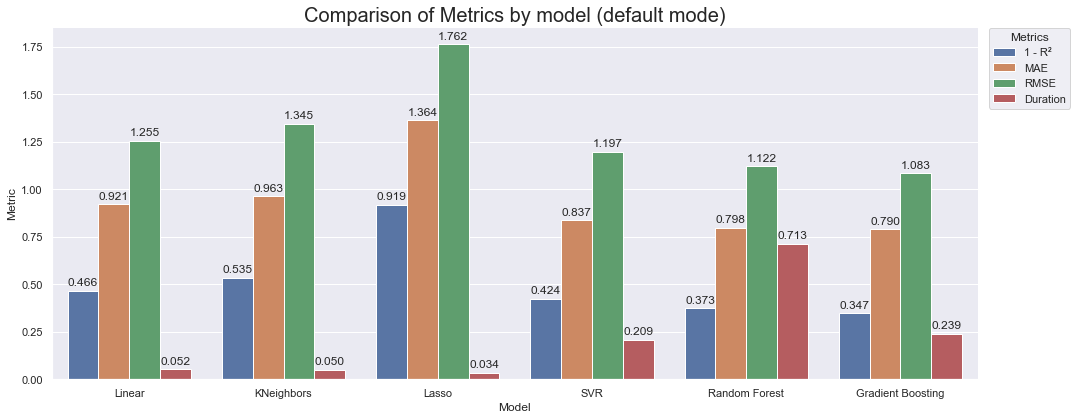

In [199]:
fig, ax1 = plt.subplots(figsize=(15, 6))
plot = sns.barplot(x="Model", y="Value", hue="Metric", data=df_models_metrics_melt, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.title("Comparison of Metrics by model (default mode)", size=20)
plt.legend(bbox_to_anchor=(1.10, 1), borderaxespad=0, title="Metrics")
plt.tight_layout()
plt.xlabel("Model", size=12)
plt.ylabel("Metric", size=12)
plt.savefig("img/comparisonMetricsByModel.png")
sns.despine(fig)

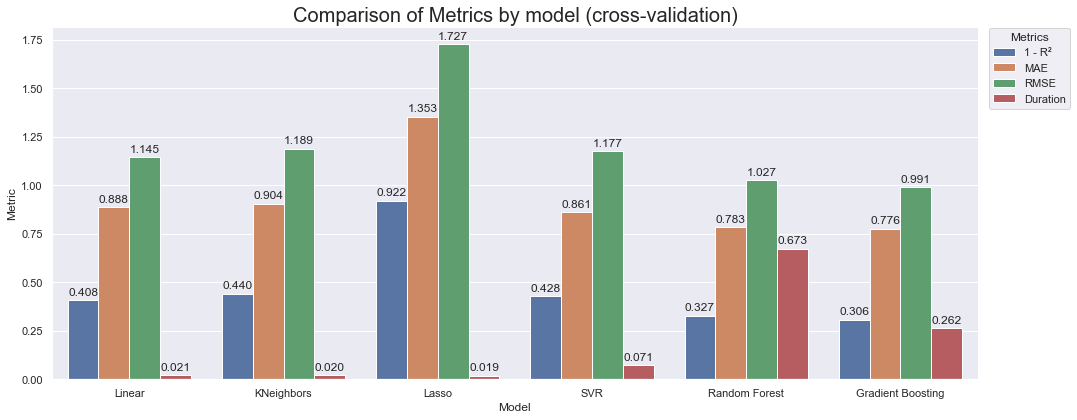

In [200]:
fig, ax1 = plt.subplots(figsize=(15, 6))
plot = sns.barplot(x="Model", y="Value", hue="Metric", data=df_models_metrics_melt_cross, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.title("Comparison of Metrics by model (cross-validation)", size=20)
plt.legend(bbox_to_anchor=(1.10, 1), borderaxespad=0, title="Metrics")
plt.tight_layout()
plt.xlabel("Model", size=12)
plt.ylabel("Metric", size=12)
plt.savefig("img/comparisonMetrics_crossByModel.png")
sns.despine(fig)

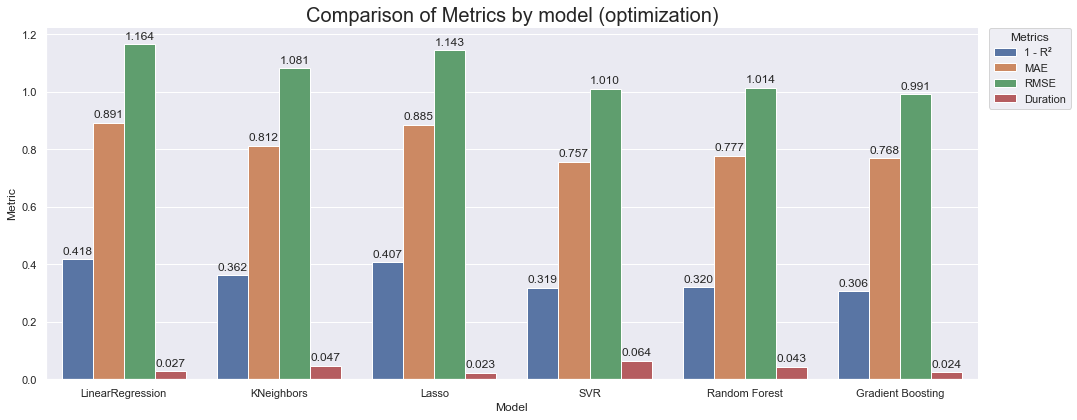

In [201]:
fig, ax1 = plt.subplots(figsize=(15, 6))
plot = sns.barplot(x="Model", y="Value", hue="Metric", data=df_models_metrics_gsc, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.title("Comparison of Metrics by model (optimization)", size=20)
plt.legend(bbox_to_anchor=(1.10, 1), borderaxespad=0, title="Metrics")
plt.tight_layout()
plt.xlabel("Model", size=12)
plt.ylabel("Metric", size=12)
plt.savefig("img/comparisonMetricsByModel-after-optimization.png")
sns.despine(fig)

   <b>Conclusions</b>
        <li><b>1-R2:</b> Gradient Boosting(0.31) </li>
        <li><b>MAE:</b> Gradient Boosting(0.754) </li>
        <li><b>RMSE:</b> Gradient Boosting(1.008) </li>
        <li><b>Duration:</b> Lasso(0.035) </li>    
    Based on the result, we are going to continue with <b>Gradient Boosting</b>


## <font color=#00d4ff>7.1. Comparing with baseline</font>

<div class="alert alert-block alert-info">
    <p>Now, we are going to compare the result with a <b>dummy baseline</b> and the chance level</p>
    <p>First of all, we are going to run the cross-validate for the <b>Gradient Boosting Regressor</b>. </p>
</div>

In [202]:
cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)

In [203]:
reg = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.5))

result_regressor = cross_validate(reg, X_train, y_train, cv=cv, scoring=("neg_mean_absolute_error"), n_jobs=-2)

errors_regressor = pd.Series(-result_regressor["test_score"], name="Regressor error")

<div class="alert alert-block alert-info">
    <p>Now, we run the cross-validate for the Dummy Regressor</p>
</div>

In [204]:
dummy = DummyRegressor()

result_dummy = cross_validate(dummy, X_train, y_train, cv=cv, scoring=("neg_mean_absolute_error"), n_jobs=-2)

errors_dummy = pd.Series(-result_dummy["test_score"], name="Dummy error")

<div class="alert alert-block alert-info">
    Evaluating the generalization performance of the second baseline
</div>

In [205]:
reg = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                                            max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                                            n_estimators=search.best_params_.get("gradientboostingregressor__n_estimators"),
                                                            subsample=search.best_params_.get("gradientboostingregressor__subsample"))
                   )

score, permutation_score, pvalue = permutation_test_score(reg, X_train, y_train, cv=cv, scoring=("neg_mean_absolute_error"), n_jobs=-2, n_permutations=30)

errors_permutation = pd.Series(-permutation_score, name="Permuted error")

<div class="alert alert-block alert-info">
    Plotting the resultats
</div>

In [206]:
final_errors = pd.concat([errors_regressor, errors_dummy, errors_permutation], axis=1)

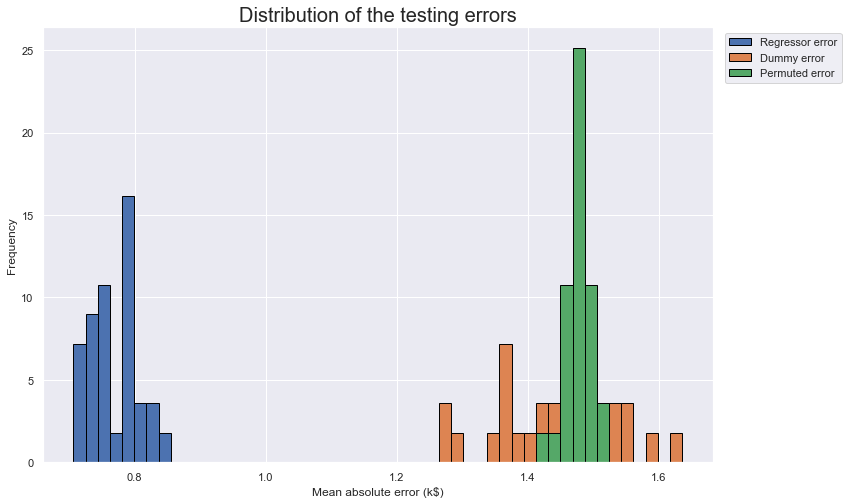

In [207]:
fig, ax1 = plt.subplots(figsize=(12, 8))
final_errors.plot.hist(bins=50, density=True, edgecolor="black", ax=ax1)
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
plt.xlabel("Mean absolute error (k$)")
plt.title("Distribution of the testing errors", size=20)
plt.savefig("img/comparison-with-baselines.png")

<div class="alert alert-block alert-success">
    <p><b>Conclusions</b></p>
    We can see that the performance of Gradient Boosting it is better than the two baselines. 

</div>


---
# <font color=#00d4ff>8. Splitting data - GHGEmissions(MetricTonsCO2e)n</font>

## <font color=#00d4ff>8.1. Splitting dataset based on the features and targets</font>

<div class="alert alert-block alert-info">
    Splitting dataset based on the features and targets
</div>

In [208]:
X = data.drop(columns=["SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)", "ENERGYSTARScore"])

In [209]:
X.head()

,NumberofFloors,NumberofBuildings,BUILDING_AGE,PropertyGFATotal,PropertyGFATotal-binned,Neighborhood,PropertyType,RATIO_ELECTRICITY,NaturalGas,SteamUse,OtherFuelUse
0,12.0,1.0,95.0,88434.0,Medium,DOWNTOWN,Hotel,52.79951,True,True,False
1,11.0,1.0,26.0,103566.0,Medium,DOWNTOWN,Hotel,46.74768,True,False,False
2,10.0,1.0,96.0,61320.0,Medium,DOWNTOWN,Hotel,9.80903,True,True,False
3,18.0,1.0,42.0,175580.0,Medium,DOWNTOWN,Hotel,40.90771,True,False,False
4,11.0,1.0,96.0,83008.0,Medium,DOWNTOWN,Hotel,42.85568,True,False,False


<div class="alert alert-block alert-info">
    Based on the Exploratory Data Analysis realized, we are going to transform to log2 the target variable
</div>

In [210]:
y_co2 = np.log2(data.loc[:,"GHGEmissions(MetricTonsCO2e)"])
y_co2.head()

0     7.962491
1     8.041714
2    10.919117
3     8.987832
4     7.703627
Name: GHGEmissions(MetricTonsCO2e), dtype: float64

In [211]:
y_co2_values = y_co2.values
y_co2_values[:5]

array([ 7.96249118,  8.0417139 , 10.91911658,  8.98783245,  7.70362677])


## <font color=#00d4ff>8.2. Train/Test split</font>

<div class="alert alert-block alert-info">
    At this point, we are going to predict <b>SiteEnergyUse(kBtu)</b>
</div>

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y_co2, test_size=0.33, random_state=42)

In [213]:
print("X_train: {}".format(X_train.shape))
print("y_train: {}".format(y_train.shape))
print("---------------------")
print("X_test: {}".format(X_test.shape))
print("y_test: {}".format(y_test.shape))

X_train: (1080, 11)
y_train: (1080,)
---------------------
X_test: (533, 11)
y_test: (533,)



## <font color=#00d4ff>8.3. Predictions metrics</font>

<div class="alert alert-block alert-info">
    We are going to make the prediction with the testing set to compare the result with the model in default mode
</div>

In [214]:
start_time_model = timeit.default_timer()

reg = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                                            max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                                            n_estimators=search.best_params_.get("gradientboostingregressor__n_estimators"),
                                                            subsample=search.best_params_.get("gradientboostingregressor__subsample"))
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

# Calculating R2 Coefficient of determination for each model (Best possible score is 1.0, lower values are worse.)
R2SCORE = round((1 - r2_score(y_test, y_pred)), 5)
    
# Calculating the Mean absolute error (The best value is 0.0)
MAE = round(mean_absolute_error(y_test, y_pred), 3)
    
# Calculating Root Mean Square Error for each model (The best value is 0.0)
RMSE = round(mean_squared_error(y_test, y_pred, squared=False), 3)

LIST_CO2 = [R2SCORE, MAE, RMSE, end_time_model]

print("R2 =".translate(SUP), R2SCORE)
print("MAE =", MAE)
print("RMSE =", RMSE)
print("Duration =", end_time_model)

R² = 0.26966
MAE = 0.778
RMSE = 1.085
Duration = 1.422


<div class="alert alert-block alert-info">
    Adding results of predictions to compare before with others predictions
</div>

In [215]:
df_original_results_energy = pd.DataFrame({
    "Data" : ["Original", "Original", "Original", "Original"],
    "Metric" : ["1 - " + "R2".translate(SUP), "MAE", "RMSE", "Duration"],
    "Value" : LIST_ENERGY
})

df_original_results_energy

,Data,Metric,Value
0,Original,1 - R²,0.34329
1,Original,MAE,0.78700
2,Original,RMSE,1.07700
3,Original,Duration,1.53100


In [216]:
df_original_results_co2 = pd.DataFrame({
    "Data" : ["Original", "Original", "Original", "Original"],
    "Metric" : ["1 - " + "R2".translate(SUP), "MAE", "RMSE", "Duration"],
    "Value" : LIST_CO2
})

df_original_results_co2

,Data,Metric,Value
0,Original,1 - R²,0.26966
1,Original,MAE,0.77800
2,Original,RMSE,1.08500
3,Original,Duration,1.42200


## <font color=#00d4ff>8.4. Gradient Boosting Validation curve</font>

<div class="alert alert-block alert-info">
    To plot the <b>Validation curve</b>, we are going to use a <b>range of estimators</b> to analyze the model through them
</div>

In [217]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

n_estimators = np.arange(start=50, stop=650, step=50)

reg = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                                            max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                                            subsample=search.best_params_.get("gradientboostingregressor__subsample"))
                   )

<div class="alert alert-block alert-info">
    Plotting <b>the validacion curve</b> based on the best parameters
</div>

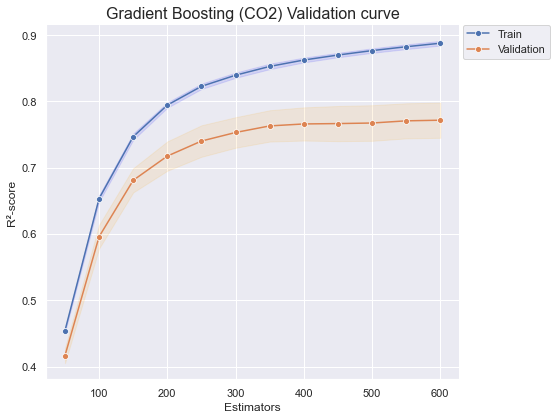

In [218]:
plot_validation_curve_by(reg, "Gradient Boosting (CO2)", "R2SCORE", X_train, y_train, param_name="gradientboostingregressor__n_estimators", param_range=n_estimators, param_name_short="Estimators", cv=kfold)


## <font color=#00d4ff>8.5. Gradient Boosting Learning curve</font>

<div class="alert alert-block alert-info">
    To plot the <b>Learning curve</b>, we are going to use the <b>best  parameters</b> to analyze the model
</div>

In [219]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

reg = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                                            max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                                            n_estimators=search.best_params_.get("gradientboostingregressor__n_estimators"),
                                                            subsample=search.best_params_.get("gradientboostingregressor__subsample"))
                   )

<div class="alert alert-block alert-info">
    Plotting <b>the learning curve</b> based on the best parameters
</div>

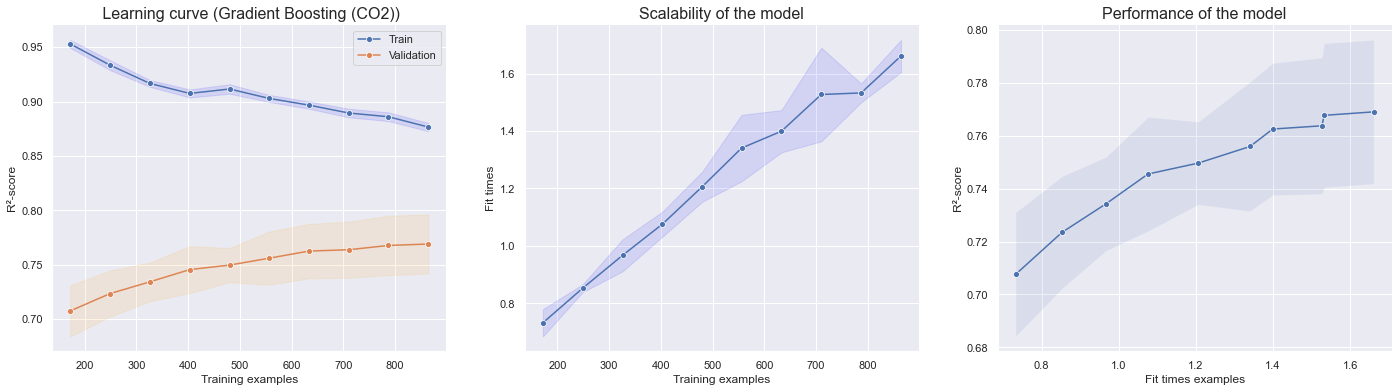

In [220]:
plot_learning_curve(reg, "Gradient Boosting (CO2)", X_train, y_train, cv=kfold)

## <font color=#00d4ff>8.6. Gradient Boosting predictions validations</font>

<div class="alert alert-block alert-info">
    To plot the <b>predictions validations</b>, we are going to use the <b>best  parameters</b> to analyze the model after <b>fitting</b> and <b>predicting</b> values</b>
</div>

In [221]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

reg = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                                            max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                                            n_estimators=search.best_params_.get("gradientboostingregressor__n_estimators"),
                                                            subsample=search.best_params_.get("gradientboostingregressor__subsample"))
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

<div class="alert alert-block alert-info">
    Plotting <b>the Cross-Validated Predictions</b> based on the best parameters for <b>training data</b>
</div>

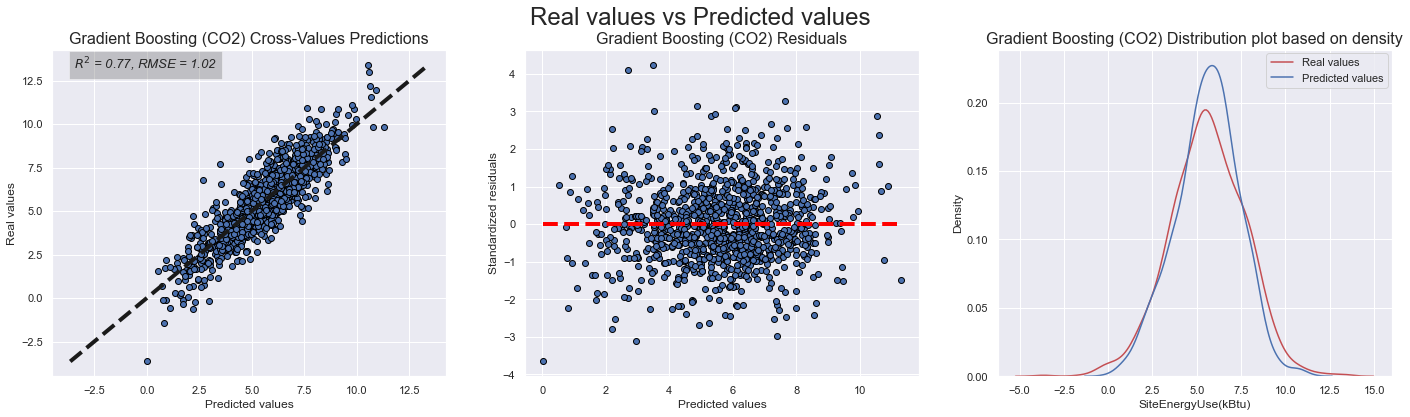

In [222]:
# Making the prediction using the testing data
plot_cross_val_predi(reg, "Gradient Boosting (CO2)", "GHGEmissions(MetricTonsCO2e)", X_train, y_train, cv=kfold)


## <font color=#00d4ff>8.7. Gradient Boosting Features Importance</font>

<div class="alert alert-block alert-info">
    To plot the <b>Features Importance</b>, we are going to use the <b>best  parameters</b> to analyze the model after <b>fitting</b> values</b>
</div>

In [223]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

reg = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                                            max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                                            n_estimators=search.best_params_.get("gradientboostingregressor__n_estimators"),
                                                            subsample=search.best_params_.get("gradientboostingregressor__subsample"))
                   )

reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function boolean_transformation at 0x000002A42C107AC0>))]),
                                                  ['NaturalGas', 'SteamUse',
                                                   'OtherFuelUse']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Neighborhoo...
                                                                   FunctionTransformer(func=<functio

<div class="alert alert-block alert-info">
    Plotting <b>the Features Importance</b> based on the best parameters
</div>

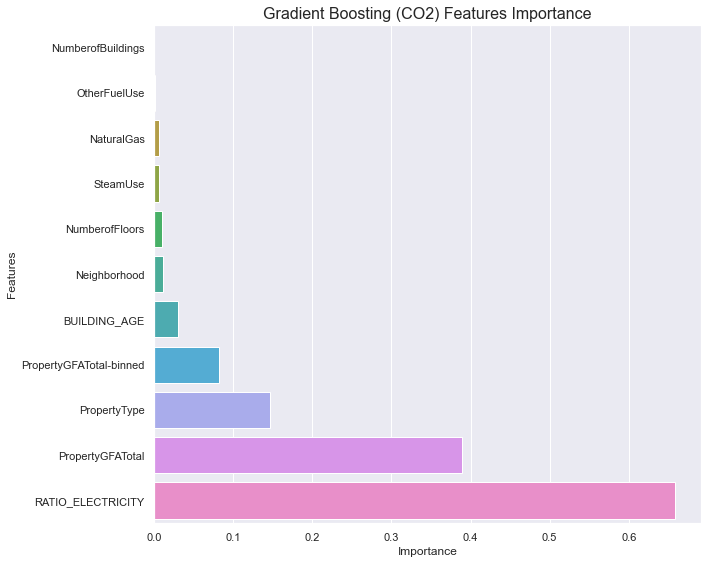

In [224]:
plot_features_importance(reg, "Gradient Boosting (CO2)", X_train, y_train, scoring="r2")


---
# <font color=#00d4ff>9. PCA - Predictions</font>

<div class="alert alert-block alert-info">
    So far, we got the best result through Gradient Boosting. Now, we are going to test the same model with the PCA results
</div>

## <font color=#00d4ff>9.1. Importing and preparing files</font>

In [225]:
data_pca = pd.read_csv(r"df_PCA.csv")

In [226]:
data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e)
0,2.224545,1.977893,-3.223262,0.509725,0.465146,-0.892848,-1.571427,-0.796613,22.735091,7.968264
1,1.763556,1.431056,0.156956,-0.425879,-0.402610,-0.060106,0.835972,-0.807931,22.994076,8.047178
2,1.393128,2.997969,-3.313584,0.599215,0.412970,-0.860284,-1.734895,-0.973242,24.750691,10.919861
3,2.802129,1.782291,-0.408070,-0.617077,-0.457471,-0.236118,0.812618,-0.223475,23.821928,8.990671
4,1.186983,1.614750,-1.128857,-0.645575,0.007628,-0.399337,0.969587,0.692181,22.576081,7.710531


<div class="alert alert-block alert-info">
    It is not necessary to make any preprocessing on data
</div>


## <font color=#00d4ff>9.2. Splitting dataset based on the features and targets</font>

<div class="alert alert-block alert-info">
    Splitting dataset based on the features and targets
</div>

In [227]:
X = data_pca.drop(columns=["SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)"])

In [228]:
X.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,2.224545,1.977893,-3.223262,0.509725,0.465146,-0.892848,-1.571427,-0.796613
1,1.763556,1.431056,0.156956,-0.425879,-0.402610,-0.060106,0.835972,-0.807931
2,1.393128,2.997969,-3.313584,0.599215,0.412970,-0.860284,-1.734895,-0.973242
3,2.802129,1.782291,-0.408070,-0.617077,-0.457471,-0.236118,0.812618,-0.223475
4,1.186983,1.614750,-1.128857,-0.645575,0.007628,-0.399337,0.969587,0.692181


In [229]:
y_energy = data_pca.loc[:,"SiteEnergyUse(kBtu)"]
y_energy.head()

0    22.735091
1    22.994076
2    24.750691
3    23.821928
4    22.576081
Name: SiteEnergyUse(kBtu), dtype: float64

In [230]:
y_co2 = data_pca.loc[:,"GHGEmissions(MetricTonsCO2e)"]
y_co2.head()

0     7.968264
1     8.047178
2    10.919861
3     8.990671
4     7.710531
Name: GHGEmissions(MetricTonsCO2e), dtype: float64

## <font color=#00d4ff>9.3. Predictions metrics - SiteEnergyUse(kBtu)</font>

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y_energy, test_size=0.33, random_state=42)

start_time_model = timeit.default_timer()

reg = GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                n_estimators=search.best_params_.get("gradientboostingregressor__n_estimators"),
                                subsample=search.best_params_.get("gradientboostingregressor__subsample"))

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

# Calculating R2 Coefficient of determination for each model (Best possible score is 1.0, lower values are worse.)
R2SCORE = round((1 - r2_score(y_test, y_pred)), 5)
    
# Calculating the Mean absolute error (The best value is 0.0)
MAE = round(mean_absolute_error(y_test, y_pred), 3)
    
# Calculating Root Mean Square Error for each model (The best value is 0.0)
RMSE = round(mean_squared_error(y_test, y_pred, squared=False), 3)

LIST_ENERGY_PCA = [R2SCORE, MAE, RMSE, end_time_model]

print("R2 =".translate(SUP), R2SCORE)
print("MAE =", MAE)
print("RMSE =", RMSE)
print("Duration =", end_time_model)

R² = 0.43296
MAE = 0.871
RMSE = 1.209
Duration = 1.55


## <font color=#00d4ff>9.4. Predictions metrics - GHGEmissions(MetricTonsCO2e)</font>

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y_co2, test_size=0.33, random_state=42)

start_time_model = timeit.default_timer()

reg = GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                n_estimators=search.best_params_.get("gradientboostingregressor__n_estimators"),
                                subsample=search.best_params_.get("gradientboostingregressor__subsample"))

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

# Calculating R2 Coefficient of determination for each model (Best possible score is 1.0, lower values are worse.)
R2SCORE = round((1 - r2_score(y_test, y_pred)), 5)
    
# Calculating the Mean absolute error (The best value is 0.0)
MAE = round(mean_absolute_error(y_test, y_pred), 3)
    
# Calculating Root Mean Square Error for each model (The best value is 0.0)
RMSE = round(mean_squared_error(y_test, y_pred, squared=False), 3)

LIST_CO2_PCA = [R2SCORE, MAE, RMSE, end_time_model]

print("R2 =".translate(SUP), R2SCORE)
print("MAE =", MAE)
print("RMSE =", RMSE)
print("Duration =", end_time_model)

R² = 0.33598
MAE = 0.835
RMSE = 1.118
Duration = 1.589


<div class="alert alert-block alert-info">
    Adding results of predictions to compare before with others predictions
</div>

In [233]:
df_PCA_results_energy = pd.DataFrame({
    "Data" : ["PCA", "PCA", "PCA", "PCA"],
    "Metric" : ["1 - " + "R2".translate(SUP), "MAE", "RMSE", "Duration"],
    "Value" : LIST_ENERGY_PCA
})

df_PCA_results_energy

,Data,Metric,Value
0,PCA,1 - R²,0.43296
1,PCA,MAE,0.87100
2,PCA,RMSE,1.20900
3,PCA,Duration,1.55000


In [234]:
df_PCA_results_co2 = pd.DataFrame({
    "Data" : ["PCA", "PCA", "PCA", "PCA"],
    "Metric" : ["1 - " + "R2".translate(SUP), "MAE", "RMSE", "Duration"],
    "Value" : LIST_CO2_PCA
})

df_PCA_results_co2

,Data,Metric,Value
0,PCA,1 - R²,0.33598
1,PCA,MAE,0.83500
2,PCA,RMSE,1.11800
3,PCA,Duration,1.58900


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">10. Reductions de features</h2>
</div>

<div class="alert alert-block alert-info">
    Now, we are going to reduce the features to make the predictions based on Gradient Boosting
</div>


## <font color=#00d4ff>10.1. Splitting dataset based on the features and targets</font>

<div class="alert alert-block alert-info">
    Splitting dataset based on the features and targets
</div>

In [235]:
X = data.drop(columns=["SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)", "ENERGYSTARScore", "NumberofBuildings", "PropertyGFATotal-binned", "SteamUse", "OtherFuelUse"])

In [236]:
X.head()

,NumberofFloors,BUILDING_AGE,PropertyGFATotal,Neighborhood,PropertyType,RATIO_ELECTRICITY,NaturalGas
0,12.0,95.0,88434.0,DOWNTOWN,Hotel,52.79951,True
1,11.0,26.0,103566.0,DOWNTOWN,Hotel,46.74768,True
2,10.0,96.0,61320.0,DOWNTOWN,Hotel,9.80903,True
3,18.0,42.0,175580.0,DOWNTOWN,Hotel,40.90771,True
4,11.0,96.0,83008.0,DOWNTOWN,Hotel,42.85568,True


<div class="alert alert-block alert-info">
    Based on the Exploratory Data Analysis realized, we are going to transform to log2 the target variable
</div>

In [237]:
y_energy = np.log2(data.loc[:,"SiteEnergyUse(kBtu)"])
y_energy.head()

0    22.735091
1    22.994076
2    24.750691
3    23.821928
4    22.576081
Name: SiteEnergyUse(kBtu), dtype: float64

In [238]:
y_co2 = np.log2(data.loc[:,"GHGEmissions(MetricTonsCO2e)"])
y_co2.head()

0     7.962491
1     8.041714
2    10.919117
3     8.987832
4     7.703627
Name: GHGEmissions(MetricTonsCO2e), dtype: float64

## <font color=#00d4ff>10.2. Data preprocessing</font>

<div class="alert alert-block alert-info">
    Updating the data preprocessing based on the features selected
</div>

In [239]:
BOOLEAN_FEATURES = ["NaturalGas"] # Features to be transformed into int
CATEGORICAL_FEATURES = ["Neighborhood", "PropertyType"] # Features to be transformed with OneHotEncoder()
FEATURES_TO_LOG = ["PropertyGFATotal"] # Features to be transformed into log2
NUMERICAL_FEATURES = ["NumberofFloors", "BUILDING_AGE", "PropertyGFATotal", "RATIO_ELECTRICITY"] # Features to be treated considering numerical values

In [240]:
boolean_pipeline = make_pipeline(FunctionTransformer(boolean_transformation))

categorical_pipeline = make_pipeline(OneHotEncoder(sparse=False, drop="first"))

log_transformation_pipeline = make_pipeline(KNNImputer(), FunctionTransformer(log_transformation))

numerical_pipeline = make_pipeline(KNNImputer(), StandardScaler())

In [241]:
preprocessor = make_column_transformer(
                (boolean_pipeline, BOOLEAN_FEATURES), 
                (categorical_pipeline, CATEGORICAL_FEATURES),
                (log_transformation_pipeline, FEATURES_TO_LOG), 
                (numerical_pipeline, NUMERICAL_FEATURES)
)


## <font color=#00d4ff>10.2. Predictions metrics - SiteEnergyUse(kBtu)</font>

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y_energy, test_size=0.33, random_state=42)

start_time_model = timeit.default_timer()

reg = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                                            max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                                            n_estimators=search.best_params_.get("gradientboostingregressor__n_estimators"),
                                                            subsample=search.best_params_.get("gradientboostingregressor__subsample"))
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

# Calculating R2 Coefficient of determination for each model (Best possible score is 1.0, lower values are worse.)
R2SCORE = round((1 - r2_score(y_test, y_pred)), 5)
    
# Calculating the Mean absolute error (The best value is 0.0)
MAE = round(mean_absolute_error(y_test, y_pred), 3)
    
# Calculating Root Mean Square Error for each model (The best value is 0.0)
RMSE = round(mean_squared_error(y_test, y_pred, squared=False), 3)

LIST_ENERGY_REDUCED_FEATURES = [R2SCORE, MAE, RMSE, end_time_model]

print("R2 =".translate(SUP), R2SCORE)
print("MAE =", MAE)
print("RMSE =", RMSE)
print("Duration =", end_time_model)

R² = 0.34652
MAE = 0.785
RMSE = 1.082
Duration = 1.381


## <font color=#00d4ff>10.3. Predictions metrics - GHGEmissions(MetricTonsCO2e)</font>

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y_co2, test_size=0.33, random_state=42)

start_time_model = timeit.default_timer()


reg = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                                            max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                                            n_estimators=search.best_params_.get("gradientboostingregressor__n_estimators"),
                                                            subsample=search.best_params_.get("gradientboostingregressor__subsample"))
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

# Calculating R2 Coefficient of determination for each model (Best possible score is 1.0, lower values are worse.)
R2SCORE = round((1 - r2_score(y_test, y_pred)), 5)
    
# Calculating the Mean absolute error (The best value is 0.0)
MAE = round(mean_absolute_error(y_test, y_pred), 3)
    
# Calculating Root Mean Square Error for each model (The best value is 0.0)
RMSE = round(mean_squared_error(y_test, y_pred, squared=False), 3)

LIST_CO2_REDUCED_FEATURES = [R2SCORE, MAE, RMSE, end_time_model]

print("R2 =".translate(SUP), R2SCORE)
print("MAE =", MAE)
print("RMSE =", RMSE)
print("Duration =", end_time_model)

R² = 0.27067
MAE = 0.783
RMSE = 1.087
Duration = 1.401


<div class="alert alert-block alert-info">
    Adding results of predictions to compare before with others predictions
</div>

In [244]:
df_FEATURES_REDUCED_results_energy = pd.DataFrame({
    "Data" : ["Reduced", "Reduced", "Reduced", "Reduced"],
    "Metric" : ["1 - " + "R2".translate(SUP), "MAE", "RMSE", "Duration"],
    "Value" : LIST_ENERGY_REDUCED_FEATURES
})

df_FEATURES_REDUCED_results_energy

,Data,Metric,Value
0,Reduced,1 - R²,0.34652
1,Reduced,MAE,0.78500
2,Reduced,RMSE,1.08200
3,Reduced,Duration,1.38100


In [245]:
df_FEATURES_REDUCED_results_co2 = pd.DataFrame({
    "Data" : ["Reduced", "Reduced", "Reduced", "Reduced"],
    "Metric" : ["1 - " + "R2".translate(SUP), "MAE", "RMSE", "Duration"],
    "Value" : LIST_CO2_REDUCED_FEATURES
})

df_FEATURES_REDUCED_results_co2

,Data,Metric,Value
0,Reduced,1 - R²,0.27067
1,Reduced,MAE,0.78300
2,Reduced,RMSE,1.08700
3,Reduced,Duration,1.40100



---
# <font color=#00d4ff>11. Comparison of predictions</font>

In [246]:
df_final_energy = pd.concat([df_original_results_energy, df_PCA_results_energy, df_FEATURES_REDUCED_results_energy], axis=0)

In [247]:
df_final_co2 = pd.concat([df_original_results_co2, df_PCA_results_co2, df_FEATURES_REDUCED_results_co2], axis=0)

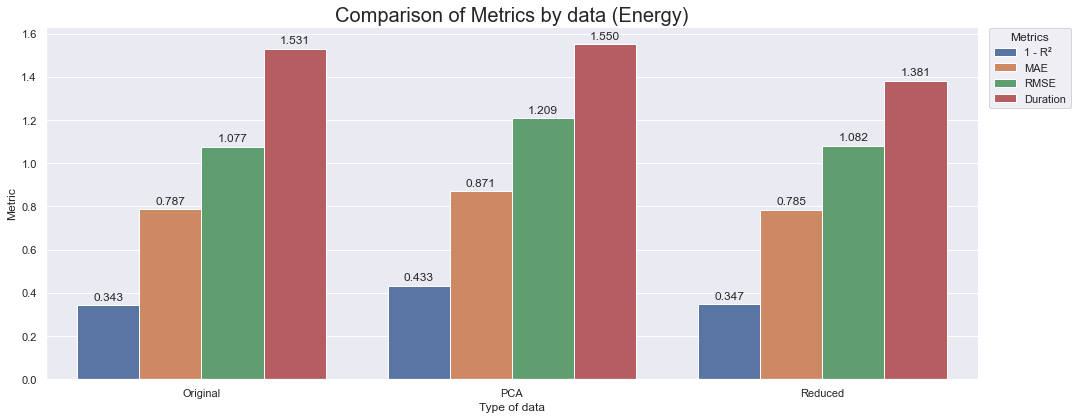

In [248]:
fig, ax1 = plt.subplots(figsize=(15, 6))
plot = sns.barplot(x="Data", y="Value", hue="Metric", data=df_final_energy, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.title("Comparison of Metrics by data (Energy)", size=20)
plt.legend(bbox_to_anchor=(1.10, 1), borderaxespad=0, title="Metrics")
plt.tight_layout()
plt.xlabel("Type of data", size=12)
plt.ylabel("Metric", size=12)
plt.savefig("img/comparisonMetricsByData-Energy.png")
sns.despine(fig)

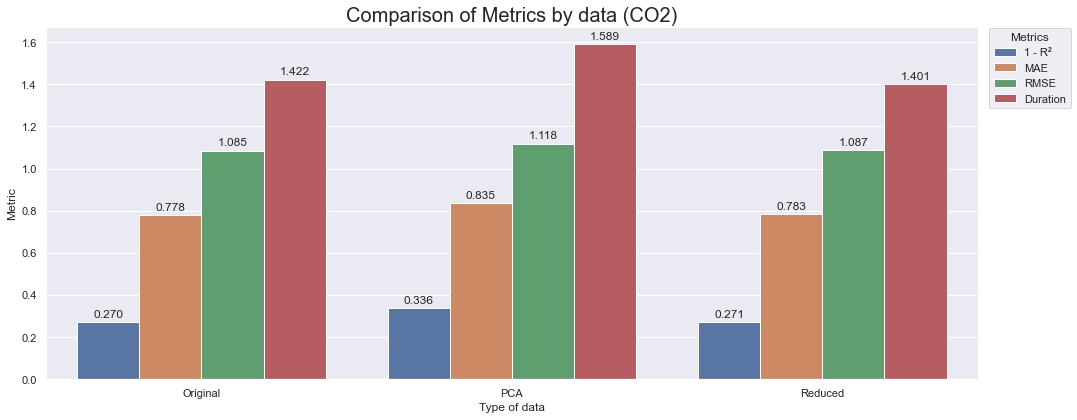

In [249]:
fig, ax1 = plt.subplots(figsize=(15, 6))
plot = sns.barplot(x="Data", y="Value", hue="Metric", data=df_final_co2, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.title("Comparison of Metrics by data (CO2)", size=20)
plt.legend(bbox_to_anchor=(1.10, 1), borderaxespad=0, title="Metrics")
plt.tight_layout()
plt.xlabel("Type of data", size=12)
plt.ylabel("Metric", size=12)
plt.savefig("img/comparisonMetricsByData-Co2.png")
sns.despine(fig)



---
# <font color=#00d4ff>12. Importance of ENERGYSTARScore in dataset reduced</font>

<div class="alert alert-block alert-info">
    Now, we are going to identify the importance of ENERGYSTARScore for the predictions
</div>

## <font color=#00d4ff>12.1. Splitting dataset based on the features and targets</font>

In [250]:
df_energy_star_score = data.drop(columns=["NumberofBuildings", "PropertyGFATotal-binned", "SteamUse", "OtherFuelUse"])

In [251]:
df_analysis(df_energy_star_score, "df_energy_star_score", type_analysis="complete")


Analysis of df_energy_star_score dataset
--------------------------------------------------------------------
- Dataset shape:                  1613 rows and 10 columns
- Total of NaN values:            524
- Percentage of NaN:              3.25 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 115.1+ KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,NumberofFloors,float64,1613,28,0,0.00000,3.42033,1.00000,1.00000,2.00000,4.00000,33.00000,3.73643
1,BUILDING_AGE,float64,1613,113,0,0.00000,60.45753,7.00000,33.00000,57.00000,92.00000,122.00000,32.76327
2,PropertyGFATotal,float64,1613,1527,0,0.00000,90695.87973,3.00000,28800.00000,47368.00000,97720.00000,1158691.00000,115427.84464
3,Neighborhood,object,1613,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PropertyType,object,1613,8,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,RATIO_ELECTRICITY,float64,1613,1252,0,0.00000,70.70959,0.00033,50.47997,72.50703,100.00002,100.00874,26.02542
6,NaturalGas,bool,1613,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,SiteEnergyUse(kBtu),float64,1613,1612,0,0.00000,6305355.53049,11441.00000,1189402.00000,2401148.00000,6507500.00000,295812640.00000,13697131.42559
8,GHGEmissions(MetricTonsCO2e),float64,1613,1540,0,0.00000,134.73136,0.08000,19.11000,47.24000,131.03000,10780.64000,422.64581
9,ENERGYSTARScore,float64,1089,100,524,32.49000,64.60698,1.00000,47.00000,72.00000,88.00000,100.00000,28.50467


<div class="alert alert-block alert-info">
    Here, we have a problem, there are 524 missing-values in <b>ENERGYSTARScore</b>. So, we are going to delete them to see how many samples left
</div>

In [252]:
df_energy_star_score = pd.DataFrame(df_energy_star_score[df_energy_star_score["ENERGYSTARScore"].notnull()]).reset_index(drop=True)

In [253]:
df_analysis(df_energy_star_score, "df_energy_star_score", type_analysis="complete")


Analysis of df_energy_star_score dataset
--------------------------------------------------------------------
- Dataset shape:                  1089 rows and 10 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 77.8+ KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,NumberofFloors,float64,1089,28,0,0.00000,3.83563,1.00000,1.00000,3.00000,4.00000,33.00000,4.30518
1,BUILDING_AGE,float64,1089,111,0,0.00000,58.62443,7.00000,33.00000,55.00000,84.00000,122.00000,31.82861
2,PropertyGFATotal,float64,1089,1056,0,0.00000,99998.46648,3.00000,31774.00000,52500.00000,110356.00000,1158691.00000,125438.57572
3,Neighborhood,object,1089,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PropertyType,object,1089,8,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,RATIO_ELECTRICITY,float64,1089,831,0,0.00000,72.37159,0.52808,52.52043,76.06063,100.00406,100.00455,26.09470
6,NaturalGas,bool,1089,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,SiteEnergyUse(kBtu),float64,1089,1088,0,0.00000,6352875.03065,43943.00000,1261714.00000,2467851.00000,6863464.00000,295812640.00000,14983861.02193
8,GHGEmissions(MetricTonsCO2e),float64,1089,1056,0,0.00000,133.74197,0.31000,18.99000,46.46000,127.78000,10780.64000,485.46695
9,ENERGYSTARScore,float64,1089,100,0,0.00000,64.60698,1.00000,47.00000,72.00000,88.00000,100.00000,28.50467


<div class="alert alert-block alert-info">
    1090 samples remained. So, let's go to Split dataset based on the features and targets
</div>

In [254]:
X = df_energy_star_score.drop(columns=["SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)"])

In [255]:
X.head()

,NumberofFloors,BUILDING_AGE,PropertyGFATotal,Neighborhood,PropertyType,RATIO_ELECTRICITY,NaturalGas,ENERGYSTARScore
0,12.0,95.0,88434.0,DOWNTOWN,Hotel,52.79951,True,65.0
1,11.0,26.0,103566.0,DOWNTOWN,Hotel,46.74768,True,51.0
2,10.0,96.0,61320.0,DOWNTOWN,Hotel,9.80903,True,1.0
3,18.0,42.0,175580.0,DOWNTOWN,Hotel,40.90771,True,67.0
4,11.0,96.0,83008.0,DOWNTOWN,Hotel,42.85568,True,25.0


<div class="alert alert-block alert-info">
    Based on the Exploratory Data Analysis realized, we are going to transform to log2 the target variable
</div>

In [256]:
y_energy = np.log2(df_energy_star_score.loc[:,"SiteEnergyUse(kBtu)"])
y_energy.head()

0    22.735091
1    22.994076
2    24.750691
3    23.821928
4    22.576081
Name: SiteEnergyUse(kBtu), dtype: float64

In [257]:
y_co2 = np.log2(df_energy_star_score.loc[:,"GHGEmissions(MetricTonsCO2e)"])
y_co2.head()

0     7.962491
1     8.041714
2    10.919117
3     8.987832
4     7.703627
Name: GHGEmissions(MetricTonsCO2e), dtype: float64

## <font color=#00d4ff>12.2. Data preprocessing</font>

<div class="alert alert-block alert-info">
    Updating the data preprocessing based on the features selected
</div>

In [258]:
BOOLEAN_FEATURES = ["NaturalGas"] # Features to be transformed into int
CATEGORICAL_FEATURES = ["Neighborhood", "PropertyType"] # Features to be transformed with OneHotEncoder()
FEATURES_TO_LOG = ["PropertyGFATotal"] # Features to be transformed into log2
NUMERICAL_FEATURES = ["NumberofFloors", "BUILDING_AGE", "PropertyGFATotal", "RATIO_ELECTRICITY", "ENERGYSTARScore"] # Features to be treated considering numerical values

In [259]:
boolean_pipeline = make_pipeline(FunctionTransformer(boolean_transformation))

categorical_pipeline = make_pipeline(OneHotEncoder(sparse=False, drop="first"))

log_transformation_pipeline = make_pipeline(KNNImputer(), FunctionTransformer(log_transformation))

numerical_pipeline = make_pipeline(KNNImputer(), StandardScaler())

In [260]:
preprocessor = make_column_transformer(
                (boolean_pipeline, BOOLEAN_FEATURES), 
                (categorical_pipeline, CATEGORICAL_FEATURES),
                (log_transformation_pipeline, FEATURES_TO_LOG), 
                (numerical_pipeline, NUMERICAL_FEATURES)
)


## <font color=#00d4ff>12.4. Predictions - SiteEnergyUse(kBtu)</font>

In [261]:
X_train, X_test, y_train, y_test = train_test_split(X, y_energy, test_size=0.33, random_state=42)

start_time_model = timeit.default_timer()

reg = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                                            max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                                            n_estimators=search.best_params_.get("gradientboostingregressor__n_estimators"),
                                                            subsample=search.best_params_.get("gradientboostingregressor__subsample"))
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

# Calculating R2 Coefficient of determination for each model (Best possible score is 1.0, lower values are worse.)
R2SCORE = round((1 - r2_score(y_test, y_pred)), 5)
    
# Calculating the Mean absolute error (The best value is 0.0)
MAE = round(mean_absolute_error(y_test, y_pred), 3)
    
# Calculating Root Mean Square Error for each model (The best value is 0.0)
RMSE = round(mean_squared_error(y_test, y_pred, squared=False), 3)

LIST_ENERGY_REDUCED_ENERGYSTARSCORE_FEATURES = [R2SCORE, MAE, RMSE, end_time_model]

print("R2 =".translate(SUP), R2SCORE)
print("MAE =", MAE)
print("RMSE =", RMSE)
print("Duration =", end_time_model)

R² = 0.15237
MAE = 0.519
RMSE = 0.706
Duration = 1.184


<div class="alert alert-block alert-info">
    Adding results of predictions to compare before with others predictions
</div>

In [262]:
df_ENERGY_REDUCED_ENERGYSTARSCORE_FEATURES = pd.DataFrame({
    "Target" : ["Energy", "Energy", "Energy", "Energy"],
    "Metric" : ["1 - " + "R2".translate(SUP), "MAE", "RMSE", "Duration"],
    "Value" : LIST_ENERGY_REDUCED_ENERGYSTARSCORE_FEATURES
})

df_ENERGY_REDUCED_ENERGYSTARSCORE_FEATURES

,Target,Metric,Value
0,Energy,1 - R²,0.15237
1,Energy,MAE,0.51900
2,Energy,RMSE,0.70600
3,Energy,Duration,1.18400



### <font color=#00d4ff>12.4.1 Features Importance - SiteEnergyUse(kBtu)</font>

<div class="alert alert-block alert-info">
    To plot the <b>Features Importance</b>, we are going to use the <b>best  parameters</b> to analyze the model after <b>fitting</b> values</b>
</div>

In [263]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

reg = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                                            max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                                            n_estimators=search.best_params_.get("gradientboostingregressor__n_estimators"),
                                                            subsample=search.best_params_.get("gradientboostingregressor__subsample"))
                   )

reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function boolean_transformation at 0x000002A42C107AC0>))]),
                                                  ['NaturalGas']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Neighborhood',
                                                   'PropertyType']),
                                                 ('pipe...
                                                   

<div class="alert alert-block alert-info">
    Plotting <b>the Features Importance</b> based on the best parameters
</div>

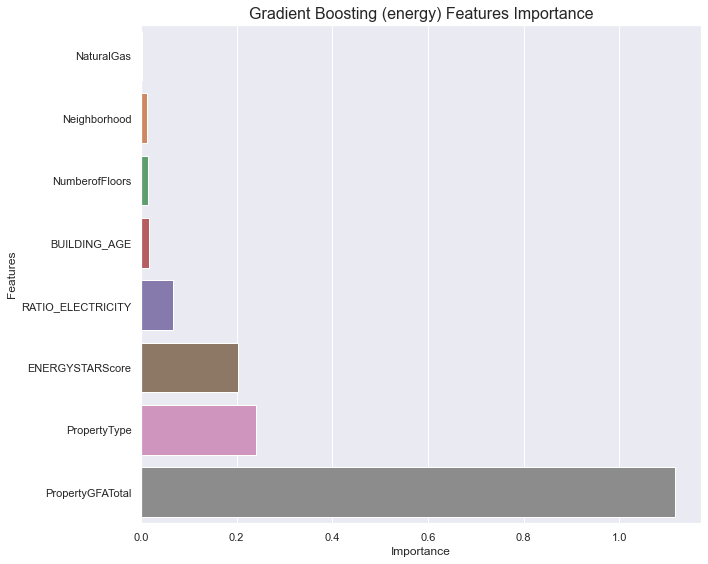

In [264]:
plot_features_importance(reg, "Gradient Boosting (energy)", X_train, y_train, scoring="r2")

## <font color=#00d4ff>12.5. Predictions - GHGEmissions(MetricTonsCO2e</font>

In [265]:
X_train, X_test, y_train, y_test = train_test_split(X, y_co2, test_size=0.33, random_state=42)

start_time_model = timeit.default_timer()


reg = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                                            max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                                            n_estimators=search.best_params_.get("gradientboostingregressor__n_estimators"),
                                                            subsample=search.best_params_.get("gradientboostingregressor__subsample"))
                   )

reg.fit(X_train, y_train)

# Making the prediction using the testing data
y_pred = reg.predict(X_test)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

# Calculating R2 Coefficient of determination for each model (Best possible score is 1.0, lower values are worse.)
R2SCORE = round((1 - r2_score(y_test, y_pred)), 5)
    
# Calculating the Mean absolute error (The best value is 0.0)
MAE = round(mean_absolute_error(y_test, y_pred), 3)
    
# Calculating Root Mean Square Error for each model (The best value is 0.0)
RMSE = round(mean_squared_error(y_test, y_pred, squared=False), 3)

LIST_CO2_REDUCED_ENERGYSTARSCORE_FEATURES = [R2SCORE, MAE, RMSE, end_time_model]

print("R2 =".translate(SUP), R2SCORE)
print("MAE =", MAE)
print("RMSE =", RMSE)
print("Duration =", end_time_model)

R² = 0.15361
MAE = 0.569
RMSE = 0.786
Duration = 0.967


<div class="alert alert-block alert-info">
    Adding results of predictions to compare before with others predictions
</div>

In [266]:
df_CO2_REDUCED_ENERGYSTARSCORE_FEATURES = pd.DataFrame({
    "Target" : ["CO2", "CO2", "CO2", "CO2"],
    "Metric" : ["1 - " + "R2".translate(SUP), "MAE", "RMSE", "Duration"],
    "Value" : LIST_CO2_REDUCED_ENERGYSTARSCORE_FEATURES
})

df_CO2_REDUCED_ENERGYSTARSCORE_FEATURES

,Target,Metric,Value
0,CO2,1 - R²,0.15361
1,CO2,MAE,0.56900
2,CO2,RMSE,0.78600
3,CO2,Duration,0.96700


### <font color=#00d4ff>12.5.1 Features Importance - GHGEmissions(MetricTonsCO2e)</font>

<div class="alert alert-block alert-info">
    To plot the <b>Features Importance</b>, we are going to use the <b>best  parameters</b> to analyze the model after <b>fitting</b> values</b>
</div>

In [267]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

reg = make_pipeline(preprocessor, GradientBoostingRegressor(learning_rate=search.best_params_.get("gradientboostingregressor__learning_rate"),
                                                            max_depth=search.best_params_.get("gradientboostingregressor__max_depth"),
                                                            n_estimators=search.best_params_.get("gradientboostingregressor__n_estimators"),
                                                            subsample=search.best_params_.get("gradientboostingregressor__subsample"))
                   )

reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function boolean_transformation at 0x000002A42C107AC0>))]),
                                                  ['NaturalGas']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Neighborhood',
                                                   'PropertyType']),
                                                 ('pipe...
                                                   

<div class="alert alert-block alert-info">
    Plotting <b>the Features Importance</b> based on the best parameters
</div>

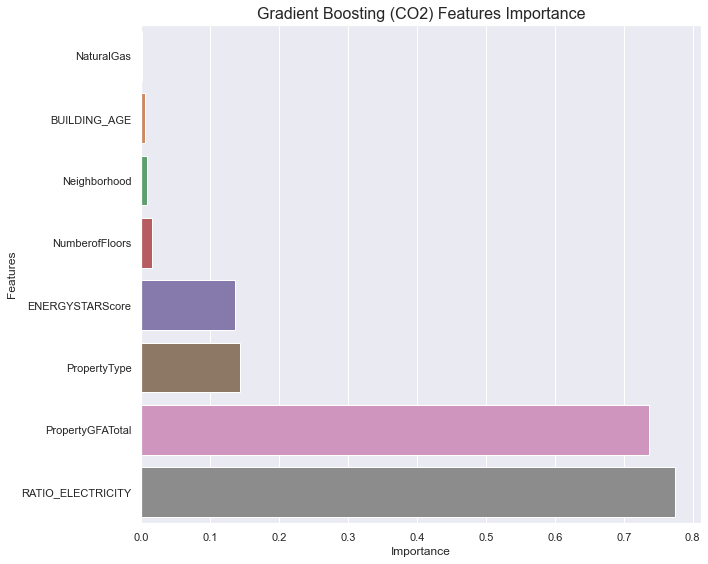

In [268]:
plot_features_importance(reg, "Gradient Boosting (CO2)", X_train, y_train, scoring="r2")

## <font color=#00d4ff>12.6. Plotting the final results</font>

In [269]:
df_final_reduced_energystarscore = pd.concat([df_ENERGY_REDUCED_ENERGYSTARSCORE_FEATURES, df_CO2_REDUCED_ENERGYSTARSCORE_FEATURES], axis=0)

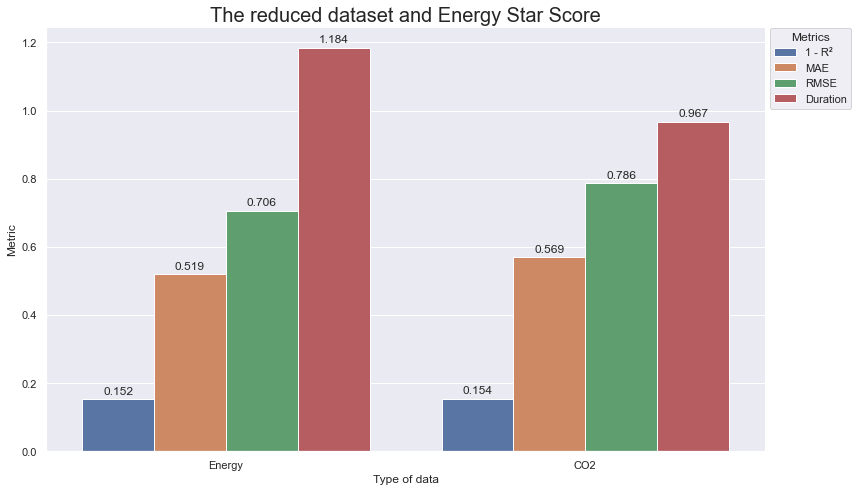

In [270]:
fig, ax1 = plt.subplots(figsize=(12, 7))
plot = sns.barplot(x="Target", y="Value", hue="Metric", data=df_final_reduced_energystarscore, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.title("The reduced dataset and Energy Star Score", size=20)
plt.legend(bbox_to_anchor=(1.12, 1), borderaxespad=0, title="Metrics")
plt.tight_layout()
plt.xlabel("Type of data", size=12)
plt.ylabel("Metric", size=12)
plt.savefig("img/EnergyStarScore-reduced-dataset.png")
sns.despine(fig)

<div class="alert alert-block alert-info">
    Here, we can conclude that the importance of the Energy Star Score in the model
</div>